# Got Raps?

## Background

I am someone who *loves* to music. One of my favorite genres to listen to is hip-hop/rap because of, in some cases, the focus on lyricism. 

In recent years, there has been less of a focus in this regard, leading some fans of "true hip-hop" to look down upon the musicians currently in the spotlight. Part of the criticism of modern rap is how forgettable the lyrics and songs are due to their simplistic nature. 

While learning about *recurrent neural networks* (RNNs)I came across a [video](https://www.youtube.com/watch?v=ZMudJXhsUpY) by Laurence Moroney explaining how AI can be used to generate poetry after training upon a corpus of Irish poems. This sparked an idea to try and do the same with a modern song lyrics. I specifically decided to choose rap because of my familiarity with the genre and thinking that the songs may have more words since the artists are not singing (most of the time).

I will be scraping lyrics from [azlyrics](https://www.azlyrics.com/t/tyga.html) using BeautifulSoup and Keras to create my RNN.

supplemental site https://www.allthelyrics.com/lyrics/tyga
alternative https://www.lyricsbox.com/tyga-lyrics-hdgvd.html

**Subsitute Cuss Words With Nonsensical Words OR Censor Words As-Is**

## Imports

In [1]:
import os
import requests
import regex
import pickle
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import functions as dlf
import matplotlib.pyplot as plt
import nltk.corpus as nltkcorpus
import nltk.collocations as collc
from bs4 import BeautifulSoup
from nltk import word_tokenize, FreqDist
from nltk.stem import PorterStemmer
from importlib import reload

In [2]:
def lyric_header_checker(dict_, display_multi=True, sort=True):

    tag_ = 'Tag'
    nav_str_ = 'NavigableString'
    tag_res = {}

    for key in dict_:
        song = dict_[key]

        for lyric in song:
            type_ = type(lyric)

            if type_.__name__ == nav_str_:
                continue

            reg_res = regex.findall(r'\[.+\]', lyric.text)

            if len(reg_res) == 1:
                item = reg_res.pop()

                try:
                    tag_res[item] += 1
                except:
                    tag_res[item] = 1

            elif len(reg_res) > 1:
                if display_multi:
                    print('--'*10)
                    print(reg_res)

            else:
                continue
    
    if sort:
        fin_res = {k: v for k, v in sorted(tag_res.items(),
                                           key=lambda item:item[1],
                                           reverse=True)}
        return fin_res

In [3]:
def lyric_header_filter(dict_, to_drop, display_multi=True, sort=True):

    tag_ = 'Tag'
    nav_str_ = 'NavigableString'
    tag_res = {}

    for key in dict_:
        song = dict_[key]
        lyric_holder = []

        for lyric in song:
            type_ = type(lyric)

            if type_.__name__ == nav_str_:
                continue

            reg_res = regex.findall(r'\[.+\]', lyric.text)

            if len(reg_res) == 1:
                item = reg_res.pop()
                
                if item in to_drop:
                    pass
                else:
                    lyric_holder.append(lyric.text)

            elif len(reg_res) > 1:
                if display_multi:
                    print('--'*10)
                    print(reg_res)
                
                for item in reg_res:
                    if item in to_drop:
                        pass
                    else:
                        lyric_holder.append(lyric.text)                    

            else:
                lyric_holder.append(lyric.text)
                
        tag_res[key] = lyric_holder
    
    if sort:
        fin_res = {k: v for k, v in sorted(tag_res.items(),
                                           key=lambda item:item[1],
                                           reverse=True)}
        return fin_res

In [4]:
def lyric_line_splitter(lyric_dict):
    ## Results container
    result_dict = {}
    
    ## Iterate through each song
    for song_title in lyric_dict:
        ## Store copied lyrics in variable + set merge container
        song = lyric_dict[song_title].copy()
        song_merged = []
        
        ## Iterate through each grouping of lyrics + merge split results
        for lyric in song:
            song_merged.extend(lyric.splitlines())
            
        ## Store list of merged lyrics
        result_dict[song_title] = song_merged
        
    return result_dict

In [5]:
def clean_song(list_of_lyrics):
    #import regex
    
    cleaned = []
    for line in list_of_lyrics:
        
        if not '[' in line and not ']' in line:
            clean_line = regex.sub(r'[^\w\s]', '', line)
            cleaned.append(clean_line.lower())
            
    return cleaned

def song_cleaner(dict_of_songs):
    
    results = {}
    
    for song_title in dict_of_songs:
        song_raw = dict_of_songs[song_title].copy()
        results[song_title] = clean_song(song_raw)
        
    return results

In [6]:
def tokenize_lyrics(list_of_lyrics):
    #from nltk import word_tokenize
    lyrics_joined = ' '.join(list_of_lyrics)
    lyrics_tokens = word_tokenize(lyrics_joined)
    
    return lyrics_tokens

def lyric_tokenizer(dict_of_songs):
    
    results = {}
    
    for song_title in dict_of_songs:
        lyrics_raw = dict_of_songs[song_title].copy()
        lyrics_tokens = tokenize_lyrics(lyrics_raw)
        results[song_title] = lyrics_tokens
        
    return results

**Blog post about non-contiguous bigrams?** [Link](https://www.frontiersin.org/articles/10.3389/fpsyg.2011.00136/full)

In [95]:
def series_ratio(series, keep_df=False, keep_series=True):
        import pandas as pd
        
        total = series.values.sum()
        res_df = pd.DataFrame(series)
        res_df.columns = ['Values']
        res_df['Ratio'] = res_df['Values'] / total
        ratio_series = res_df['Ratio'].copy()
        
        if keep_df:
            return res_df
        elif keep_series:
            return ratio_series
        else:
            return ''

def freqdist_plotter(tokens, premade_fd=False, n_common=None, h_plot=False, normalize_plot=False, show_ratio=False, figsize=(10,10)):
    import nltk
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    if isinstance(n_common, int):
        freqdist = pd.Series(dict(nltk.FreqDist(tokens).most_common(n_common)))
    elif isinstance(n_common, type(None)):
        freqdist = pd.Series(dict(nltk.FreqDist(tokens)))
    elif premade_fd:
        freqdist = pd.Series(tokens)
    else:
        return f"Wrong input {type(n_common)}, use 'int' or 'None'."
        
    fig, ax = plt.subplots(figsize=figsize)
    
    if normalize_plot:
        percent_plot = series_ratio(freqdist)
        
        if n_common:
            percent_plot = percent_plot.sort_values(ascending=False).head(n_common)
        else:
            percent_plot = percent_plot.sort_values(ascending=False)
            
        if h_plot:
            bar_plot = sns.barplot(x=percent_plot.values, y=percent_plot.index, orient='h', ax=ax)
        else:
            bar_plot = sns.barplot(x=percent_plot.index, y=percent_plot.values, ax=ax)
            
        plt.title('Normalized Frequency Distribution')    
    else:
        if h_plot:
            bar_plot = sns.barplot(x=freqdist.values, y=freqdist.index, orient='h', ax=ax)
        else:
            bar_plot = sns.barplot(x=freqdist.index, y=freqdist.values, ax=ax)
            
        plt.title('Frequency Distribution')
    
    if h_plot:
        plt.show();
    else:
        plt.xticks(rotation=30)
        plt.show();
    
    if show_ratio:
        
        try:
            type(percent_plot)
            print('**'*10)
            print(f'Top {n_common} tokens usage rate (%):')
            print('**'*10)
            display(percent_plot)
        except NameError:
            ratios = series_ratio(freqdist)
            
            if n_common:
                ratios_sorted = ratios.sort_values(ascending=False).head(n_common)
            else:
                ratios_sorted = ratios.sort_values(ascending=False)
            
            print('**'*10)
            print(f'Top {n_common} tokens usage rate (%):')
            print('**'*10)
            display(ratios_sorted)
    
def n_gram_creator(tokens, top_n=20, n=2, freq_filter=None, window_size=None, counts=False, show_freq=True, show_pmi=False, keep=None):
    import nltk.collocations as colloc
    from nltk import bigrams, trigrams
    
    if n in [2,3,4]:
        
        if isinstance(window_size, int):
            window = window_size
        else:
            window = n
        
        if n == 2:
            word = 'Bi'
            
            if counts:
                ngrams = bigrams(tokens)
                return ngrams
            else:
                ngram_measures = colloc.BigramAssocMeasures()
                ngram_finder = colloc.BigramCollocationFinder.from_words(tokens, window_size=window)
            
        elif n == 3:
            word = 'Tri'
            
            if counts:
                ngrams = trigrams(tokens)
                return ngrams
            else:
                ngram_measures = colloc.TrigramAssocMeasures()
                ngram_finder = colloc.TrigramCollocationFinder.from_words(tokens, window_size=window)

        elif n == 4:
            word = 'Quad'
            ngram_measures = colloc.QuadgramAssocMeasures()
            ngram_finder = colloc.QuadgramCollocationFinder.from_words(tokens, window_size=window)       
            
        if isinstance(freq_filter, int):
            ngram_finder.apply_freq_filter(freq_filter)
            
        ngram_score = ngram_finder.score_ngrams(ngram_measures.raw_freq)
        ngram_pmi_score = ngram_finder.score_ngrams(ngram_measures.pmi)
        
        if show_freq:
            print(f'Top {top_n} {word}-grams by frequency')
            display(ngram_score[:top_n])
        
        if show_pmi:
            print(f'PMI score for {top_n} {word}-grams')
            display(ngram_pmi_score[:top_n])
            
        if keep == 'score':
            return ngram_score
        elif keep == 'pmi':
            return ngram_pmi_score
    
    else:
        return f"{n}-grams are not supported. Try 2, 3, or 4."


def token_stat_generator(tokens, fd_plot=True, fd_n_common=20, fd_normalize=False, fd_show_ratio=False, ngram=False, n=2, ngram_top_n=20, ngram_freq_filter=None, ngram_window=None, ngram_count=False, ngram_pmi=False):
    #import pandas as pd
    #import seaborn as sns
    #import matplotlib.pyplot as plt
    #import nltk
    
    if fd_plot:
        freqdist_plotter(tokens, normalize_plot=fd_normalize, n_common=fd_n_common, show_ratio=fd_show_ratio)
        
    if ngram:
        n_gram_creator(tokens, top_n=ngram_top_n, n=n, freq_filter=ngram_freq_filter, window_size=ngram_window, counts=ngram_count, show_pmi=ngram_pmi)

In [92]:
def n_gram_plot_prepper(ngrams, reverse_sort=True, type_='freqdist', keep='join'):
    from nltk import FreqDist
    
    if type_ == 'freqdist':
        ngram_fd = FreqDist(ngrams)
        ngram_sorted = {k:v for k,v in sorted(ngram_fd.items(), key=lambda item:item[1], reverse=reverse_sort)}
        ngram_joined = {'_'.join(k):v for k,v in sorted(ngram_fd.items(), key=lambda item:item[1], reverse=reverse_sort)}
    elif type_ == 'pmi':
        ngram_sorted = {item[0]:item[1] for item in sorted(ngrams, key=lambda item:item[1], reverse=reverse_sort)}
        ngram_joined = {'_'.join(k):v for k,v in sorted(ngrams, key=lambda item:item[1], reverse=reverse_sort)}
    
    if keep == 'join':
        return ngram_joined
    elif keep == 'sort':
        return ngram_sorted
    else:
        return f"Must set keep parameter to either 'join' or 'sort', not {keep}."

In [8]:
def string_concat(list_of_strings, quick_check=False, qc_rate=25, qc_amount=25):
    
    results = []
    qc_countdown = 0
    
    for orig_string in list_of_strings:
        
        try:
            new_string = results[0] + '\n' + orig_string.strip()
            results.pop()
            results.append(new_string)
        except IndexError:
            results.append(orig_string.strip())
            
        qc_countdown += 1
        
        if quick_check and (qc_countdown == qc_rate):
            print(f'Last {qc_amount} strings joined:')
            display(results[-qc_amount:])
            qc_countdown = 0 
            
    return results

def dict_string_concat(dict_of_strings, quick_check=False, qc_rate=25, qc_amount=25):
    
    mid_results = []
    
    for key in dict_of_strings:
        list_of_strings = dict_of_strings[key].copy()
        mid_concat = string_concat(list_of_strings, quick_check=quick_check, qc_rate=qc_rate, qc_amount=qc_amount)
        mid_results.extend(mid_concat)
    
    print('***'*20)
    print(f'{len(mid_results)} strings pulled from dictionary')
    print('***'*20)
    
    fin_results = string_concat(mid_results, quick_check=quick_check, qc_rate=qc_rate, qc_amount=qc_amount)
    
    return fin_results

In [104]:
#### WRITING ATLs ####
# with open('Pickles/song_dict.pickle', 'wb') as f:
#     pickle.dump(song_dict, f)
#     f.close()

#### READING ATLs ####
with open('Pickles/song_dict.pickle', 'rb') as f:
    song_dict = pickle.load(f)
    f.close()
del song_dict['B.M.F.'], song_dict['Birdman Interlude']

#### WRITING AZLYRICS ####
# with open('Pickles/album_dict.pickle', 'wb') as f:
#     pickle.dump(album_dict, f)
#     f.close()

#### READING AZLYRICS ####
# with open('Pickles/album_dict.pickle', 'rb') as f:
#     album_dict = pickle.load(f)
#     f.close()

#### WRITING TOKENIZED LYRICS ####
# with open('Pickles/tokenized_lyrics.pickle', 'wb') as f:
#     pickle.dump(tokenized_lyrics, f)
#     f.close()
    
#### READING TOKENIZED LYRICS ####
with open('Pickles/tokenized_lyrics.pickle', 'rb') as f:
    tokenized_lyrics = pickle.load(f)
    f.close()
    
#### WRITING CLEANED LYRICS ####
# with open('Pickles/cleaned_lyrics.pickle', 'wb') as f:
#     pickle.dump(cleaned_lyrics, f)
#     f.close()
    
#### READING CLEANED LYRICS ####
with open('Pickles/cleaned_lyrics.pickle', 'rb') as f:
    cleaned_lyrics = pickle.load(f)
    f.close()
    
#### WRITING CLEANED LYRICS AS SINGLE STRING ####
# with open('Pickles/cleaned_lyrics_string.pickle', 'wb') as f:
#     pickle.dump(cleaned_lyrics_string, f)
#     f.close()
    
#### READING CLEANED LYRICS AS SINGLE STRING ####
with open('Pickles/cleaned_lyrics_string.pickle', 'rb') as f:
    cleaned_lyrics_string = pickle.load(f)
    f.close()

## Getting Soupy

#### Connecting

In [2]:
## Starting page + Q.C. of response
# start_url = 'https://www.azlyrics.com/t/tyga.html'  ## Banned
# start_url = 'https://www.lyricsbox.com/tyga-lyrics-hdgvd.html' ## Doesn't work
start_url = 'https://www.allthelyrics.com/lyrics/tyga'
start_resp = requests.get(start_url)
print(f'Starting Response: {start_resp}')

Starting Response: <Response [200]>


#### Main Page Soup

In [3]:
## Creating soup + Q.C.
start_soup = BeautifulSoup(start_resp.text, 'html.parser')
print(start_soup.prettify()[13900:14500])

            TYGA lyrics: 'Never Be The Same', 'Hookah (feat. Young Thug)', 'Riot (feat. Honey Cocaine)', 'Make It Nasty', 'We Up'
              </div>
              <div class="content-top-lyricspopular">
               <div class="artist-lyrics-list artist-lyrics-list-popular">
                <h2 class="artist-lyrics-list-h2">
                 Top 5 songs
                </h2>
                <ol>
                 <li class="lyrics-list-item lyrics-list-item-1737736">
                  <a href="/lyrics/tyga-never_be_the_same">
                   Never Be The Same
                  </a>
     


#### Collecting Song Links + Names

In [ ]:
## Create container for names/links + find links ('a') in soup
song_dict = {}
link_list = start_soup.findAll('a')

## Select and store links to Tyga songs
for a in link_list:
    if '/lyrics/tyga-' in a['href']:
        song_dict[a.text] = a['href']

## Q.C.
display(song_dict)

In [3]:
## Create iterable with song names for operations
song_names = list(song_dict.keys())

#### Collecting Lyrics - Test

In [4]:
#### Testing strategy for lyric removal ####

## Join strings to create full song URL
end_url = song_dict['Hookah (feat. Young Thug)']
start_url = 'https://www.allthelyrics.com'
full_url = start_url + end_url

## Generating soup
# song_resp = requests.get(full_url)
song_soup = BeautifulSoup(song_resp.text, 'html.parser')

## Q.C. + HTML structure info
print("Example of target 'div' and section names:\n")
print(song_soup.prettify()[12110:12210], '\n\t...')
print(song_soup.prettify()[13823:14000])

## Collect lyrics 'div' from song soup as a bs4 tag + store in song dict
lyrics = song_soup.findAll('div', attrs={'class': 'content-text-inner'}).pop()

song_dict['Hookah (feat. Young Thug)'] = lyrics

Example of target 'div' and section names:

       <div class="content-text-inner">
              <p>
               [Hook x4 - Young Thug:]
    
	...
               [Verse 2 - Tyga:]
               <br/>
               Rubbin on my chain blowing cloudmatic
               <br/>
               Smoke something with a G and bend 


#### Collecting Lyrics

In [29]:
## Iteratively scrape 5 songs at a time
dlf.song_scraper(song_dict, song_names, limit=5, verbose=False)

----------------------------------------
Song to be scraped: B.M.F.
Something wrong with link for B.M.F.
----------------------------------------
Song to be scraped: Young Kobe
Sleeping 196.45 seconds...
Ding!
----------------------------------------
Total number of songs skipped: 181


In [30]:
## Get update on how many songs scraped successfully
dlf.song_scraping_stats(song_dict)

{'tag': 182, 'string': 1}

> For ease, I am going to remove the 'B.M.F' song from this dictionary so that I can easily make a function for the entire dictionary. 

In [32]:
## Removing the broken link
song_dict.pop('B.M.F.', None)

'/lyrics/tyga-b.m.f.'

## Lyric Conversion

Before I get into the removal of non-Tyga lyrics, I want to first get them represented as a string (or strings) in hopes of making the code simpler. This is because as-is there are two different types of BeautifulSoup elements in the lyrics: `<class 'bs4.element.NavigableString'>` and `<class 'bs4.element.Tag'>`; the latter containing a .text attribute while the former does not.

## Lyric Filtering

In [100]:
## Setting containers for titles
songs_with_ft = []
songs_solo = []

## Separate and store song titles
for key in song_dict:
    if ('(feat.' in key) | ('(with' in key):
        songs_with_ft.append(key)
    else:
        songs_solo.append(key)

## Optional Q.C.
# for title in songs_with_ft:
#     title_res = regex.findall(r'\((feat..+|with.+)\)', title)
#     print(title_res)

In [101]:
## Container for lyrics
dict_no_ft = {}

## Storing lyrics of selected songs from main dict
for title in songs_solo:
    ## T/E display for handling edge cases
    try:
        dict_no_ft[title] = song_dict[title]
    except:
        print(title)

## Collecting ordered list of all lyric headers
no_feat_headers = lyric_header_checker(dict_no_ft, display_multi=False)

## Targeting droppable headers learned from 'no_feat_headers'
drop_headers = ['[Chorus: Patty Cash]', '[Chorus: Patrick Stump]', '[Birdman]',
                '[Outro: Tyga’s Mother]', '[Outro: Martin Luther King Jr.]',
                '[Verse 2: 2Chainz]', '[Patrick Stump:]',
                '[Chorus x2: Patrick Stump]', '[Gator:]', '[Hook: Quavo]',
                '[Intro: DJ Drama talking]']

## Filtering
filtered_lyrics = lyric_header_filter(dict_no_ft, drop_headers, display_multi=False)

## Q.C.
filtered_lyrics['Do It All'][0]

'[Verse 1]\nLooking at the ceiling thinking why I treat you bad\nAin’t no worser feelings than knowing I did it for the last\nArguing, all I was doing accusing you, my bad\nSaid “Let’s take some time”, nevermind, rewind\nLooking at the ceiling thinking why I treat you bad\nAin’t no worser feelings than knowing I did it for the last\nArguing, all I was doing accusing you, my bad\nSaid “Let’s take some time”, nevermind, just playing with your mind\nI always thought “play dumb”, and let the other one love\nWhy? Get caught up in nowhere but trust\nOnly love for fun, I’m too young, I thought\nAll I wanted was a thanks to Louboutins I bought\nBut it ain’t your fault; heaven knows you deserve it all\nYou sent letters to my heart, but I burned them all\nThe Bible says before you run, gotta learn to crawl\nBut I don’t wanna waste time if we ain’t involved'

## Lyric Tokenizing

In [102]:
## Merging lyrics + Q.C.
merged_lyrics = lyric_line_splitter(filtered_lyrics)
merged_lyrics['Do It All'][0:17]

['[Verse 1]',
 'Looking at the ceiling thinking why I treat you bad',
 'Ain’t no worser feelings than knowing I did it for the last',
 'Arguing, all I was doing accusing you, my bad',
 'Said “Let’s take some time”, nevermind, rewind',
 'Looking at the ceiling thinking why I treat you bad',
 'Ain’t no worser feelings than knowing I did it for the last',
 'Arguing, all I was doing accusing you, my bad',
 'Said “Let’s take some time”, nevermind, just playing with your mind',
 'I always thought “play dumb”, and let the other one love',
 'Why? Get caught up in nowhere but trust',
 'Only love for fun, I’m too young, I thought',
 'All I wanted was a thanks to Louboutins I bought',
 'But it ain’t your fault; heaven knows you deserve it all',
 'You sent letters to my heart, but I burned them all',
 'The Bible says before you run, gotta learn to crawl',
 'But I don’t wanna waste time if we ain’t involved']

In [103]:
## Cleaning punctuation/headers + lowering strings + Q.C.
cleaned_lyrics = song_cleaner(merged_lyrics)
cleaned_lyrics['Do It All'][0:16]

['looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind rewind',
 'looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind just playing with your mind',
 'i always thought play dumb and let the other one love',
 'why get caught up in nowhere but trust',
 'only love for fun im too young i thought',
 'all i wanted was a thanks to louboutins i bought',
 'but it aint your fault heaven knows you deserve it all',
 'you sent letters to my heart but i burned them all',
 'the bible says before you run gotta learn to crawl',
 'but i dont wanna waste time if we aint involved']

In [26]:
## Tokenizing lyrics
tokenized_lyrics = lyric_tokenizer(cleaned_lyrics)
tokenized_lyrics['Do It All'][0:16]

['looking',
 'at',
 'the',
 'ceiling',
 'thinking',
 'why',
 'i',
 'treat',
 'you',
 'bad',
 'aint',
 'no',
 'worser',
 'feelings',
 'than',
 'knowing']

## Token Exploration

#### Rack City Visuals

In [60]:
test_fdist = pd.Series(dict(FreqDist(tokenized_lyrics['Rack City (Single Version)'])))

In [48]:
test_fdist.values

array([35, 20, 35,  1,  5,  8,  1,  1, 27,  9,  1,  1,  1,  1,  1,  2,  1,
        1,  1,  5,  2,  3,  1,  3,  2,  5,  8,  2,  2,  1,  3,  2,  3,  1,
        2,  5,  1,  5,  1,  2,  1,  1,  1,  1,  4,  2,  1,  1,  1,  1,  1,
        1,  1,  2,  3,  2,  1,  1,  1,  1,  1,  2,  1,  2,  2,  8,  8,  8,
        2,  2,  1,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  2,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,
        2,  1,  1,  1,  1,  1,  1,  9, 36], dtype=int64)

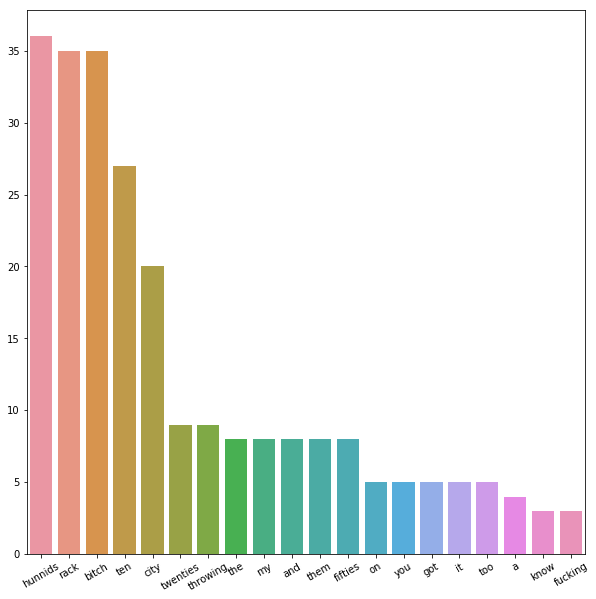

In [54]:
fig, ax = plt.subplots(figsize=(10,10))

test_plot = sns.barplot(x=test_fdist.index, y=test_fdist.values, ax=ax)
plt.xticks(rotation=30);

In [67]:
total_words = test_fdist.values.sum()
test_fdist_df = pd.DataFrame(test_fdist)
test_fdist_df.columns = ['num_uses']
test_fdist_df['percent_of_total'] = test_fdist_df['num_uses'] / total_words
test_percent_plot = test_fdist_df['percent_of_total'].sort_values(ascending=False).head(20).copy()
test_percent_plot

hunnids     0.093264
bitch       0.090674
rack        0.090674
ten         0.069948
city        0.051813
twenties    0.023316
throwing    0.023316
fifties     0.020725
them        0.020725
my          0.020725
and         0.020725
the         0.020725
too         0.012953
you         0.012953
got         0.012953
on          0.012953
it          0.012953
a           0.010363
like        0.007772
know        0.007772
Name: percent_of_total, dtype: float64

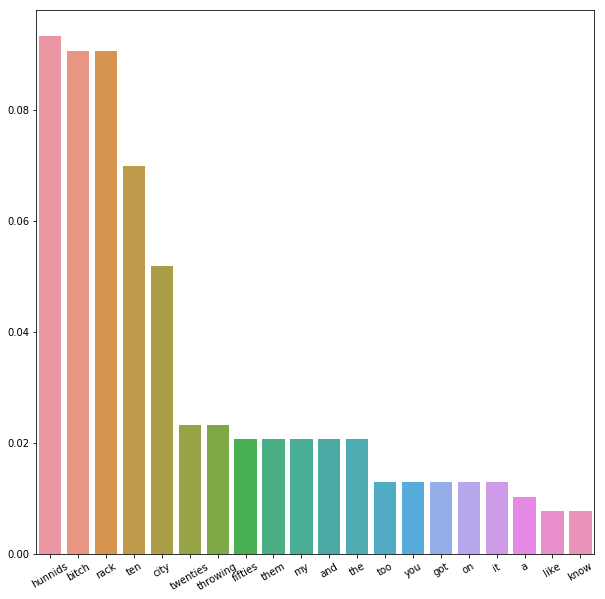

In [68]:
fig, ax = plt.subplots(figsize=(10,10))

test_plot2 = sns.barplot(x=test_percent_plot.index, y=test_percent_plot.values, ax=ax)
plt.xticks(rotation=30);

##### Bigrams

In [70]:
bigram_measures = collc.BigramAssocMeasures()
bigram_finder = collc.BigramCollocationFinder.from_words(tokenized_lyrics['Rack City (Single Version)'])
bigram_scored = bigram_finder.score_ngrams(bigram_measures.raw_freq)
bigram_scored[:50]

[(('hunnids', 'hunnids'), 0.06217616580310881),
 (('city', 'bitch'), 0.05181347150259067),
 (('ten', 'ten'), 0.046632124352331605),
 (('rack', 'city'), 0.04404145077720207),
 (('rack', 'rack'), 0.04404145077720207),
 (('bitch', 'rack'), 0.025906735751295335),
 (('ten', 'twenties'), 0.023316062176165803),
 (('throwing', 'hunnids'), 0.023316062176165803),
 (('and', 'them'), 0.02072538860103627),
 (('fifties', 'bitch'), 0.02072538860103627),
 (('them', 'fifties'), 0.02072538860103627),
 (('twenties', 'and'), 0.02072538860103627),
 (('bitch', 'ten'), 0.018134715025906734),
 (('hunnids', 'rack'), 0.015544041450777202),
 (('hunnids', 'throwing'), 0.015544041450777202),
 (('bitch', 'city'), 0.007772020725388601),
 (('bitch', 'hunnids'), 0.007772020725388601),
 (('bitch', 'throwing'), 0.007772020725388601),
 (('got', 'my'), 0.007772020725388601),
 (('a', 'motherfucking'), 0.0051813471502590676),
 (('bitch', 'bitch'), 0.0051813471502590676),
 (('bitch', 'fucking'), 0.0051813471502590676),
 (('f

##### Trigrams

In [28]:
trigram_measures = collc.TrigramAssocMeasures()
trigram_finder = collc.TrigramCollocationFinder.from_words(tokenized_lyrics['Rack City (Single Version)'])
trigram_scored = trigram_finder.score_ngrams(trigram_measures.raw_freq)
trigram_scored[:50]

[(('rack', 'city', 'bitch'), 0.04404145077720207),
 (('hunnids', 'hunnids', 'hunnids'), 0.031088082901554404),
 (('bitch', 'rack', 'rack'), 0.025906735751295335),
 (('city', 'bitch', 'rack'), 0.025906735751295335),
 (('rack', 'rack', 'city'), 0.025906735751295335),
 (('ten', 'ten', 'ten'), 0.023316062176165803),
 (('ten', 'ten', 'twenties'), 0.023316062176165803),
 (('throwing', 'hunnids', 'hunnids'), 0.023316062176165803),
 (('and', 'them', 'fifties'), 0.02072538860103627),
 (('ten', 'twenties', 'and'), 0.02072538860103627),
 (('them', 'fifties', 'bitch'), 0.02072538860103627),
 (('twenties', 'and', 'them'), 0.02072538860103627),
 (('bitch', 'ten', 'ten'), 0.018134715025906734),
 (('hunnids', 'hunnids', 'rack'), 0.015544041450777202),
 (('hunnids', 'hunnids', 'throwing'), 0.015544041450777202),
 (('hunnids', 'rack', 'city'), 0.015544041450777202),
 (('hunnids', 'throwing', 'hunnids'), 0.015544041450777202),
 (('rack', 'rack', 'rack'), 0.015544041450777202),
 (('bitch', 'city', 'bitch'

#### All Solo Tokens Visuals

Total tokens: 45,196
Total unique tokens: 5,235


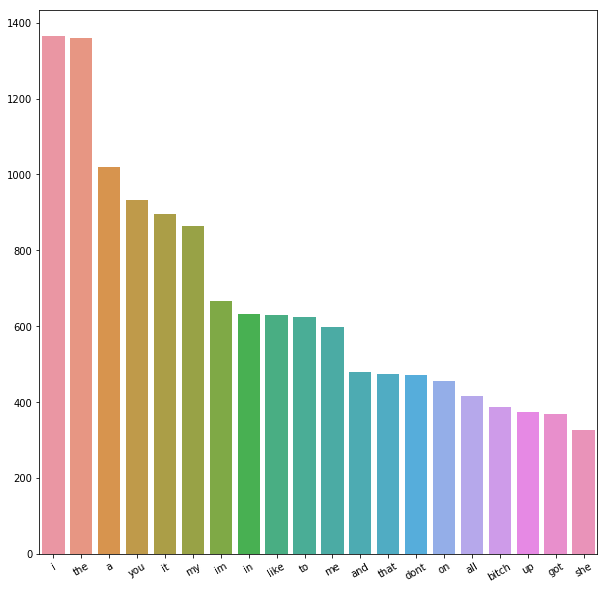

In [11]:
all_song_tokens = []

for song in tokenized_lyrics:
    all_song_tokens.extend(tokenized_lyrics[song])

print(f'Total tokens: {len(all_song_tokens):,}')
print(f'Total unique tokens: {len(set(all_song_tokens)):,}')

all_fdist = pd.Series(dict(FreqDist(all_song_tokens).most_common(20)))

fig, ax = plt.subplots(figsize=(10,10))

all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

In [11]:
total_words_all = all_fdist.values.sum()
all_fdist_df = pd.DataFrame(all_fdist)
all_fdist_df.columns = ['num_uses']
all_fdist_df['percent_of_total'] = all_fdist_df['num_uses'] / total_words_all
all_percent_plot = all_fdist_df['percent_of_total'].sort_values(ascending=False).head(20).copy()
all_percent_plot

i        0.102370
the      0.101920
a        0.076496
you      0.069897
it       0.067122
my       0.064872
im       0.050022
in       0.047398
like     0.047248
to       0.046798
me       0.044773
and      0.035998
that     0.035548
dont     0.035248
on       0.034123
all      0.031123
bitch    0.029024
up       0.027974
got      0.027674
she      0.024374
Name: percent_of_total, dtype: float64

##### Bigrams

In [12]:
bigram_measures_all = collc.BigramAssocMeasures()
bigram_finder_all = collc.BigramCollocationFinder.from_words(all_song_tokens)
bigram_scored_all = bigram_finder_all.score_ngrams(bigram_measures_all.raw_freq)
bigram_scored_all[:50]

[(('in', 'the'), 0.003982653332153288),
 (('make', 'it'), 0.0031197451101867423),
 (('i', 'dont'), 0.003009115850960262),
 (('in', 'my'), 0.0024117178511372686),
 (('like', 'a'), 0.0024117178511372686),
 (('wan', 'na'), 0.0024117178511372686),
 (('got', 'ta'), 0.0023232144437560845),
 (('i', 'aint'), 0.0022789627400654927),
 (('on', 'the'), 0.0022568368882201965),
 (('i', 'got'), 0.0017700681476236835),
 (('to', 'the'), 0.0017700681476236835),
 (('on', 'my'), 0.0016594388883972033),
 (('bitch', 'im'), 0.001526683777325427),
 (('it', 'rain'), 0.001460306221789539),
 (('all', 'my'), 0.001416054518098947),
 (('im', 'a'), 0.0013718028144083546),
 (('it', 'up'), 0.0013054252588724667),
 (('wassup', 'wassup'), 0.0012390477033365785),
 (('im', 'the'), 0.0012169218514912824),
 (('in', 'a'), 0.0011947959996459864),
 (('you', 'know'), 0.0011062925922648021),
 (('the', 'shit'), 0.0010841667404195062),
 (('stop', 'stop'), 0.00106204088857421),
 (('but', 'i'), 0.0010399150367289142),
 (('throw', 'i

##### Trigrams

In [13]:
trigram_measures_all = collc.TrigramAssocMeasures()
trigram_finder_all = collc.TrigramCollocationFinder.from_words(all_song_tokens)
trigram_scored_all = trigram_finder_all.score_ngrams(trigram_measures_all.raw_freq)
trigram_scored_all[:50]

[(('make', 'it', 'rain'), 0.001416054518098947),
 (('stop', 'stop', 'stop'), 0.0007965306664306576),
 (('throw', 'it', 'up'), 0.0007965306664306576),
 (('im', 'the', 'shit'), 0.0007301531108947695),
 (('it', 'rain', 'trick'), 0.0007301531108947695),
 (('its', 'all', 'love'), 0.0007080272590494735),
 (('wassup', 'its', 'all'), 0.0007080272590494735),
 (('love', 'teenage', 'love'), 0.0006637755553588813),
 (('teenage', 'love', 'teenage'), 0.0006637755553588813),
 (('dont', 'wan', 'na'), 0.0006416497035135853),
 (('wan', 'na', 'be'), 0.0006416497035135853),
 (('real', 'or', 'fake'), 0.0006195238516682892),
 (('it', 'make', 'it'), 0.0005973979998229932),
 (('make', 'it', 'make'), 0.0005973979998229932),
 (('i', 'got', 'ta'), 0.0005752721479776971),
 (('rack', 'city', 'bitch'), 0.0005752721479776971),
 (('rain', 'trick', 'make'), 0.0005752721479776971),
 (('trick', 'make', 'it'), 0.0005752721479776971),
 (('it', 'up', 'throw'), 0.0005531462961324011),
 (('up', 'throw', 'it'), 0.000553146296

#### Stopwords Visuals

In [13]:
stopwords = nltkcorpus.stopwords.words('english')
all_song_tokens_stopped = []

for word in all_song_tokens:
    if word in stopwords:
        pass
    else:
        all_song_tokens_stopped.append(word)
        
print(f'Before stopword removal: {len(all_song_tokens):,}')
print(f'After stopword removal: {len(all_song_tokens_stopped):,}')

Before stopword removal: 45,196
After stopword removal: 27,141


##### Bigrams

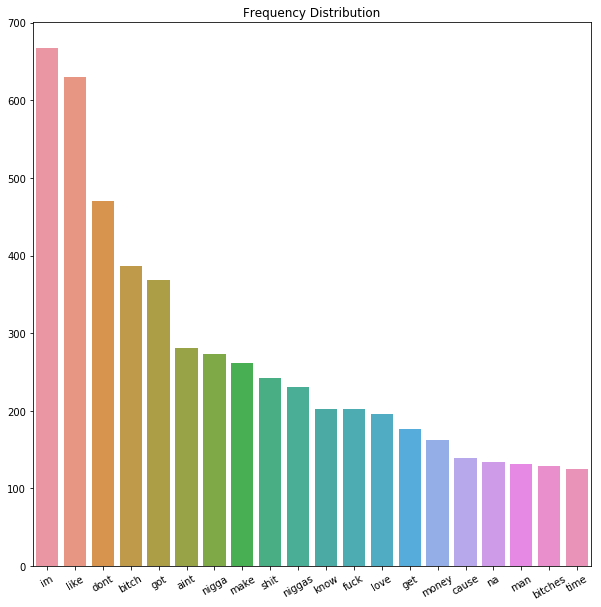

********************
Top 20 tokens usage rate (%):
********************


im         0.123313
like       0.116473
dont       0.086892
bitch      0.071547
got        0.068220
aint       0.051950
nigga      0.050471
make       0.048438
shit       0.044740
niggas     0.042522
know       0.037345
fuck       0.037345
love       0.036236
get        0.032723
money      0.029950
cause      0.025698
na         0.024774
man        0.024404
bitches    0.023849
time       0.023110
Name: Ratio, dtype: float64

Top 20 Bi-grams by frequency


[(('wan', 'na'), 0.004016064257028112),
 (('got', 'ta'), 0.003868685752183044),
 (('bitch', 'im'), 0.002542279208577429),
 (('make', 'rain'), 0.002431745329943628),
 (('wassup', 'wassup'), 0.0020632990678309568),
 (('stop', 'stop'), 0.0017685420581408202),
 (('aint', 'got'), 0.0014369404222394164),
 (('teenage', 'love'), 0.0013632511698168821),
 (('dont', 'know'), 0.0013264065436056152),
 (('im', 'shit'), 0.0013264065436056152),
 (('well', 'done'), 0.0012527172911830809),
 (('rain', 'trick'), 0.001215872664971814),
 (('city', 'bitch'), 0.0011790280387605468),
 (('hunnids', 'hunnids'), 0.0011790280387605468),
 (('wassup', 'love'), 0.0011790280387605468),
 (('love', 'teenage'), 0.0011053387863380127),
 (('dont', 'wan'), 0.0010684941601267455),
 (('make', 'make'), 0.0010684941601267455),
 (('real', 'fake'), 0.0010684941601267455),
 (('ten', 'ten'), 0.0010316495339154784)]

PMI score for 20 Bi-grams


[(('ahead', 'vent'), 13.728186256845007),
 (('alonzo', 'rondo'), 13.728186256845007),
 (('ambulance', 'firetruck'), 13.728186256845007),
 (('betty', 'boop'), 13.728186256845007),
 (('estate', 'boppers'), 13.728186256845007),
 (('excuse', 'manners'), 13.728186256845007),
 (('ford', 'escort'), 13.728186256845007),
 (('hero', 'heads'), 13.728186256845007),
 (('hors', 'doeuvres'), 13.728186256845007),
 (('jealously', 'attracting'), 13.728186256845007),
 (('katy', 'perry'), 13.728186256845007),
 (('metal', 'spoon'), 13.728186256845007),
 (('officer', 'autograph'), 13.728186256845007),
 (('pledge', 'allegiance'), 13.728186256845007),
 (('pun', 'intended'), 13.728186256845007),
 (('scottie', 'pippen'), 13.728186256845007),
 (('sin', 'jealously'), 13.728186256845007),
 (('skatin', 'basement'), 13.728186256845007),
 (('splurging', 'urgently'), 13.728186256845007),
 (('titles', 'cuffing'), 13.728186256845007)]

In [15]:
token_stat_generator(all_song_tokens_stopped, fd_plot=True, fd_show_ratio=True, ngram=True, n=2, ngram_freq_filter=2, ngram_pmi=True)

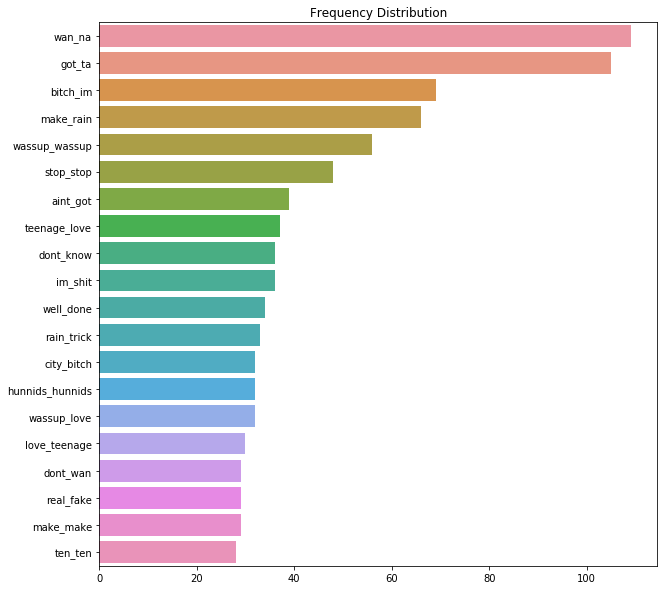

In [52]:
stopped_bigrams = n_gram_creator(all_song_tokens_stopped, counts=True)
stopped_bigrams_joined = n_gram_plot_prepper(stopped_bigrams, keep='join')
freqdist_plotter(stopped_bigrams_joined, premade_fd=True, h_plot=True, n_common=20)

##### Trigrams

In [16]:
token_stat_generator(all_song_tokens_stopped, fd_plot=False, ngram=True, n=3, ngram_freq_filter=2, ngram_pmi=True)

Top 20 Tri-grams by frequency


[(('stop', 'stop', 'stop'), 0.0013264065436056152),
 (('make', 'rain', 'trick'), 0.001215872664971814),
 (('love', 'teenage', 'love'), 0.0011053387863380127),
 (('teenage', 'love', 'teenage'), 0.0011053387863380127),
 (('dont', 'wan', 'na'), 0.0010684941601267455),
 (('rack', 'city', 'bitch'), 0.0009579602814929443),
 (('rain', 'trick', 'make'), 0.0009579602814929443),
 (('wassup', 'wassup', 'love'), 0.0008842710290704101),
 (('wassup', 'wassup', 'wassup'), 0.0008842710290704101),
 (('aint', 'got', 'ta'), 0.000847426402859143),
 (('im', 'make', 'rain'), 0.0008105817766478759),
 (('bitch', 'im', 'bitch'), 0.0007737371504366088),
 (('im', 'bitch', 'im'), 0.0007737371504366088),
 (('make', 'make', 'rain'), 0.0007000478980140746),
 (('ballin', 'ballin', 'ballin'), 0.0006632032718028076),
 (('got', 'ta', 'super'), 0.0006632032718028076),
 (('party', 'party', 'party'), 0.0006632032718028076),
 (('ta', 'super', 'size'), 0.0006632032718028076),
 (('take', 'look', 'around'), 0.00066320327180280

PMI score for 20 Tri-grams


[(('sin', 'jealously', 'attracting'), 27.456372513690017),
 (('trending', 'topic', 'hermès'), 27.456372513690017),
 (('urge', 'ultimately', 'adult'), 27.456372513690017),
 (('biggie', 'pun', 'intended'), 26.87141001296886),
 (('flabbergastin', 'spazz', 'spasm'), 26.87141001296886),
 (('hors', 'doeuvres', 'buying'), 26.87141001296886),
 (('pyramids', 'homicide', 'descriptions'), 26.87141001296886),
 (('zippin', 'dippin', 'jabs'), 26.87141001296886),
 (('add', 'titles', 'cuffing'), 26.456372513690017),
 (('biggest', 'sin', 'jealously'), 26.456372513690017),
 (('choo', 'train', 'oww'), 26.456372513690017),
 (('forward', 'ford', 'escort'), 26.456372513690017),
 (('rushing', 'add', 'titles'), 26.456372513690017),
 (('womens', 'lives', 'classy'), 26.456372513690017),
 (('cum', 'flabbergastin', 'spazz'), 26.286447512247705),
 (('dracula', 'casket', 'matters'), 26.286447512247705),
 (('mathematics', 'animal', 'dracula'), 26.286447512247705),
 (('pouring', 'champaign', 'chilling'), 26.286447512

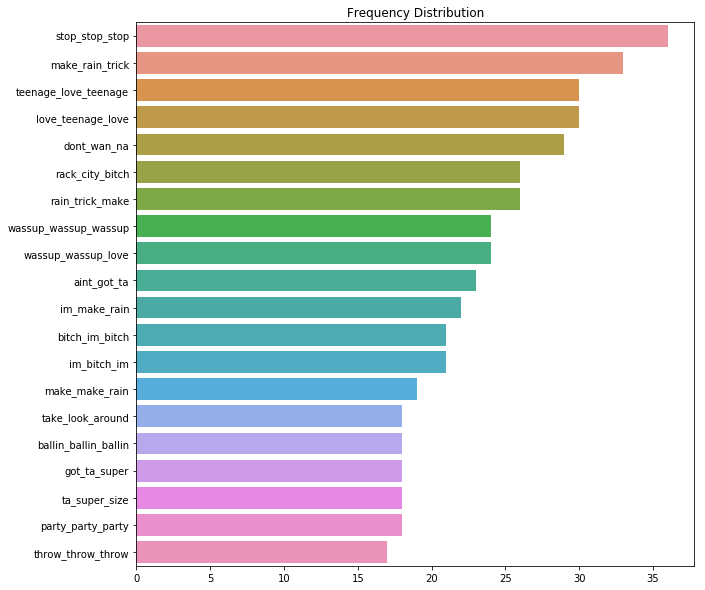

In [55]:
stopped_trigrams = n_gram_creator(all_song_tokens_stopped, n=3, counts=True)
stopped_trigrams_joined = n_gram_plot_prepper(stopped_trigrams, keep='join')
freqdist_plotter(stopped_trigrams_joined, premade_fd=True, h_plot=True, n_common=20)

#### Stemming Visuals

In [14]:
stemmer = PorterStemmer()
all_song_tokens_stemmed = []

for token in all_song_tokens_stopped:
    word = stemmer.stem(token)
    all_song_tokens_stemmed.append(word)

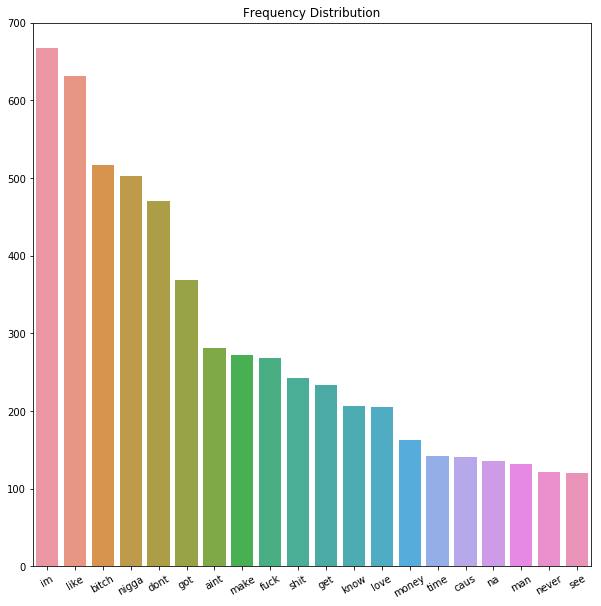

********************
Top 20 tokens usage rate (%):
********************


im       0.114625
like     0.108438
bitch    0.088847
nigga    0.086441
dont     0.080770
got      0.063413
aint     0.048290
make     0.046743
fuck     0.046056
shit     0.041760
get      0.040213
know     0.035401
love     0.035229
money    0.028012
time     0.024403
caus     0.024059
na       0.023200
man      0.022684
never    0.020794
see      0.020622
Name: Ratio, dtype: float64

In [56]:
token_stat_generator(all_song_tokens_stemmed, fd_show_ratio=True)

##### Bigrams

In [58]:
token_stat_generator(all_song_tokens_stemmed, fd_plot=False, ngram=True, n=2, ngram_freq_filter=2, ngram_pmi=True)

Top 20 Bi-grams by frequency


[(('wan', 'na'), 0.004016064257028112),
 (('got', 'ta'), 0.003868685752183044),
 (('bitch', 'im'), 0.0026528130872112304),
 (('make', 'rain'), 0.0024685899561548946),
 (('wassup', 'wassup'), 0.0020632990678309568),
 (('stop', 'stop'), 0.0017685420581408202),
 (('aint', 'got'), 0.0014369404222394164),
 (('teenag', 'love'), 0.0014369404222394164),
 (('dont', 'know'), 0.0013264065436056152),
 (('im', 'shit'), 0.0013264065436056152),
 (('citi', 'bitch'), 0.001289561917394348),
 (('well', 'done'), 0.0012527172911830809),
 (('rain', 'trick'), 0.001215872664971814),
 (('hunnid', 'hunnid'), 0.0011790280387605468),
 (('wassup', 'love'), 0.0011790280387605468),
 (('nigga', 'dont'), 0.0011421834125492796),
 (('love', 'teenag'), 0.0011053387863380127),
 (('dont', 'wan'), 0.0010684941601267455),
 (('make', 'make'), 0.0010684941601267455),
 (('real', 'fake'), 0.0010684941601267455)]

PMI score for 20 Bi-grams


[(('ahead', 'vent'), 13.728186256845007),
 (('alonzo', 'rondo'), 13.728186256845007),
 (('ambul', 'firetruck'), 13.728186256845007),
 (('betti', 'boop'), 13.728186256845007),
 (('estat', 'bopper'), 13.728186256845007),
 (('excus', 'manner'), 13.728186256845007),
 (('ford', 'escort'), 13.728186256845007),
 (('hor', 'doeuvr'), 13.728186256845007),
 (('jealous', 'attract'), 13.728186256845007),
 (('kati', 'perri'), 13.728186256845007),
 (('metal', 'spoon'), 13.728186256845007),
 (('pledg', 'allegi'), 13.728186256845007),
 (('pun', 'intend'), 13.728186256845007),
 (('scotti', 'pippen'), 13.728186256845007),
 (('skatin', 'basement'), 13.728186256845007),
 (('splurg', 'urgent'), 13.728186256845007),
 (('topic', 'hermè'), 13.728186256845007),
 (('train', 'oww'), 13.728186256845007),
 (('trend', 'topic'), 13.728186256845007),
 (('ultim', 'adult'), 13.728186256845007)]

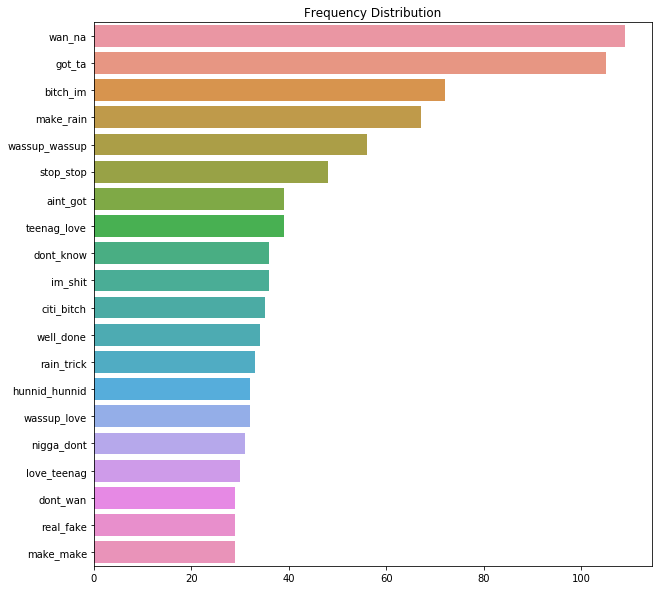

In [57]:
stemmed_bigrams = n_gram_creator(all_song_tokens_stemmed, counts=True)
stemmed_bigrams_joined = n_gram_plot_prepper(stemmed_bigrams, keep='join')
freqdist_plotter(stemmed_bigrams_joined, premade_fd=True, h_plot=True, n_common=20)

Top 20 Bi-grams by frequency


[(('wan', 'na'), 0.004016064257028112),
 (('got', 'ta'), 0.003868685752183044),
 (('bitch', 'im'), 0.0026528130872112304),
 (('make', 'rain'), 0.0024685899561548946),
 (('wassup', 'wassup'), 0.0020632990678309568),
 (('stop', 'stop'), 0.0017685420581408202),
 (('aint', 'got'), 0.0014369404222394164),
 (('teenag', 'love'), 0.0014369404222394164),
 (('dont', 'know'), 0.0013264065436056152),
 (('im', 'shit'), 0.0013264065436056152),
 (('citi', 'bitch'), 0.001289561917394348),
 (('well', 'done'), 0.0012527172911830809),
 (('rain', 'trick'), 0.001215872664971814),
 (('hunnid', 'hunnid'), 0.0011790280387605468),
 (('wassup', 'love'), 0.0011790280387605468),
 (('nigga', 'dont'), 0.0011421834125492796),
 (('love', 'teenag'), 0.0011053387863380127),
 (('dont', 'wan'), 0.0010684941601267455),
 (('make', 'make'), 0.0010684941601267455),
 (('real', 'fake'), 0.0010684941601267455)]

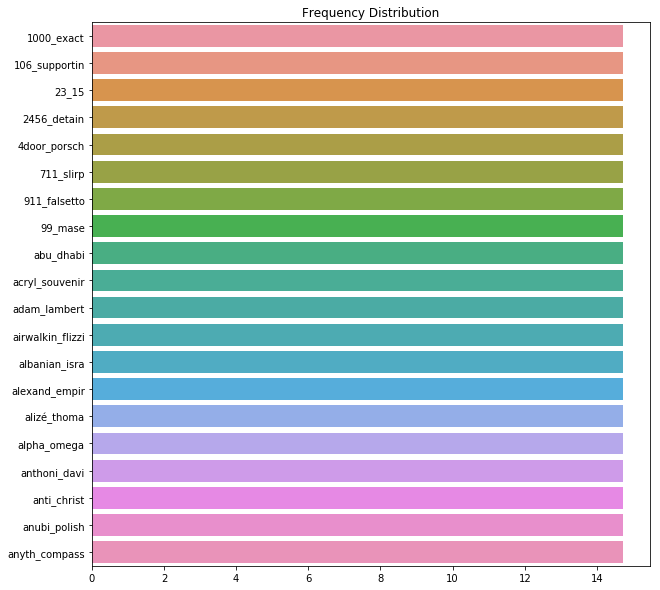

In [83]:
stemmed_bigrams_pmi = n_gram_creator(all_song_tokens_stemmed, keep='pmi')
stemmed_bigrams_pmi_joined = n_gram_plot_prepper(stemmed_bigrams_pmi, type_='pmi', keep='join')
freqdist_plotter(stemmed_bigrams_pmi_joined, premade_fd=True, h_plot=True, n_common=20)

Look into plotting negative values

##### Trigrams

In [19]:
token_stat_generator(all_song_tokens_stemmed, fd_plot=False, ngram=True, n=3, ngram_freq_filter=2, ngram_pmi=True)

Top 20 Tri-grams by frequency


[(('stop', 'stop', 'stop'), 0.0013264065436056152),
 (('make', 'rain', 'trick'), 0.001215872664971814),
 (('love', 'teenag', 'love'), 0.0011053387863380127),
 (('teenag', 'love', 'teenag'), 0.0011053387863380127),
 (('dont', 'wan', 'na'), 0.0010684941601267455),
 (('rack', 'citi', 'bitch'), 0.0009579602814929443),
 (('rain', 'trick', 'make'), 0.0009579602814929443),
 (('wassup', 'wassup', 'love'), 0.0008842710290704101),
 (('wassup', 'wassup', 'wassup'), 0.0008842710290704101),
 (('aint', 'got', 'ta'), 0.000847426402859143),
 (('im', 'make', 'rain'), 0.0008105817766478759),
 (('bitch', 'im', 'bitch'), 0.0007737371504366088),
 (('im', 'bitch', 'im'), 0.0007737371504366088),
 (('make', 'make', 'rain'), 0.0007000478980140746),
 (('ballin', 'ballin', 'ballin'), 0.0006632032718028076),
 (('got', 'ta', 'super'), 0.0006632032718028076),
 (('parti', 'parti', 'parti'), 0.0006632032718028076),
 (('ta', 'super', 'size'), 0.0006632032718028076),
 (('take', 'look', 'around'), 0.0006632032718028076)

PMI score for 20 Tri-grams


[(('trend', 'topic', 'hermè'), 27.456372513690017),
 (('urg', 'ultim', 'adult'), 27.456372513690017),
 (('biggi', 'pun', 'intend'), 26.87141001296886),
 (('pyramid', 'homicid', 'descript'), 26.87141001296886),
 (('forward', 'ford', 'escort'), 26.456372513690017),
 (('cum', 'flabbergastin', 'spazz'), 26.286447512247705),
 (('flabbergastin', 'spazz', 'spasm'), 26.286447512247705),
 (('mathemat', 'anim', 'dracula'), 26.286447512247705),
 (('zippin', 'dippin', 'jab'), 26.286447512247705),
 (('choo', 'train', 'oww'), 26.134444418802655),
 (('sin', 'jealous', 'attract'), 26.134444418802655),
 (('almost', 'est', '90'), 25.87141001296886),
 (('homicid', 'descript', 'hail'), 25.87141001296886),
 (('princess', 'promiscu', 'suppos'), 25.87141001296886),
 (('prone', 'lifestyl', 'tac'), 25.87141001296886),
 (('rosco', 'chicken', 'waffl'), 25.87141001296886),
 (('shouldnt', 'prone', 'lifestyl'), 25.87141001296886),
 (('anim', 'dracula', 'casket'), 25.701485011526547),
 (('skatin', 'basement', 'lone'

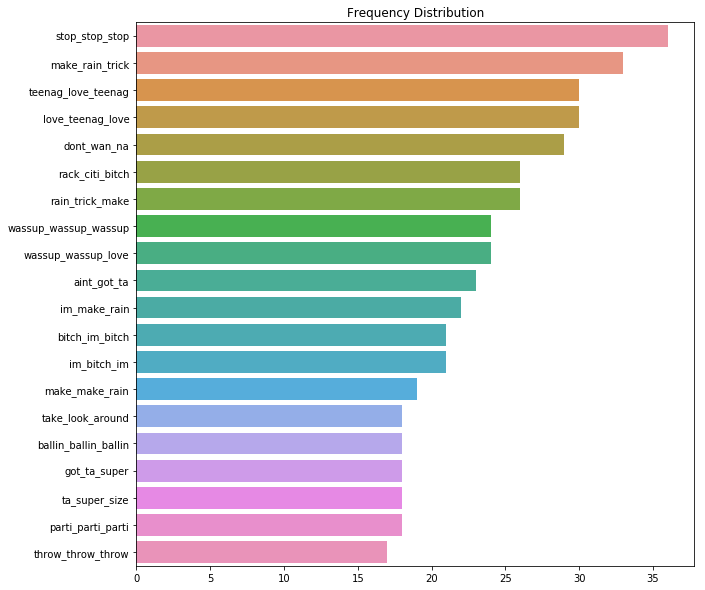

In [60]:
stemmed_trigrams = n_gram_creator(all_song_tokens_stemmed, n=3, counts=True)
stemmed_trigrams_joined = n_gram_plot_prepper(stemmed_trigrams, keep='join')
freqdist_plotter(stemmed_trigrams_joined, premade_fd=True, h_plot=True, n_common=20)

### Song Statistics

In [127]:
def song_stats(song):
    ## Join the song into one string, then split by words
    song_split = ' '.join(song).split()
    
    ## Gather song length + total unique words
    num_words = len(song_split)
    num_unique = len(set(song_split))
    
    return [num_words, num_unique]

In [191]:
def song_stat_df_generator(dict_of_songs):
    import pandas as pd
    
    ## Container for results
    result_dict = {}
    
    ## Go through each song, collect + store stats
    for key in dict_of_songs:
        song = dict_of_songs[key].copy()
        stats = song_stats(song)
        result_dict[key] = stats
    
    ## Create dataframe with totals + unique words
    result_df = pd.DataFrame.from_dict(result_dict, orient='index')
    
    ## Reset index to store title as column + set column names
    result_df.reset_index(inplace=True)
    result_df.columns = ['title', 'total_words', 'unique_words']
    
    ## Feature engineering using totals + unique words
    result_df['unique_total_ratio'] = result_df['unique_words'] / result_df['total_words']
    result_df['avg_total'] = result_df.aggregate('mean', axis=0)['total_words']
    result_df['avg_unique'] = result_df.aggregate('mean', axis=0)['unique_words']
    result_df['avg_unique_ratio'] = result_df.aggregate('mean', axis=0)['unique_total_ratio']
    
    return result_df

In [192]:
cleaned_lyrics_stats = song_stat_df_generator(cleaned_lyrics)
cleaned_lyrics_stats.head()

,title,total_words,unique_words,unique_total_ratio,avg_total,avg_unique,avg_unique_ratio
0,Do It All,561,190,0.338681,408.536364,181.272727,0.474921
1,Real Or Fake,437,192,0.439359,408.536364,181.272727,0.474921
2,LovaGain,356,131,0.367978,408.536364,181.272727,0.474921
3,Press 7,442,210,0.475113,408.536364,181.272727,0.474921
4,Day One,561,251,0.447415,408.536364,181.272727,0.474921


##### Song Length

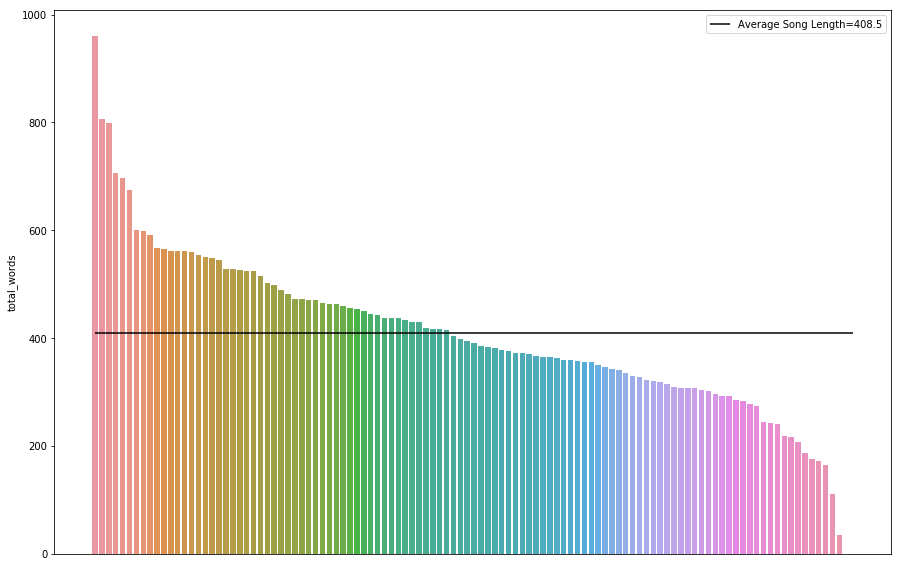

In [201]:
## Create Matplotlib figure + ax
fig, ax = plt.subplots(figsize=(15,10))

## Generate barplot sorted by song length
sns.barplot(cleaned_lyrics_stats.index, cleaned_lyrics_stats['total_words'].sort_values(ascending=False), ax=ax)

## Plot horizontal line representing average + xtick removal + legend display
plt.hlines(cleaned_lyrics_stats['avg_total'][0], xmin=0, xmax=len(cleaned_lyrics_stats), label=f"Average Song Length={round(cleaned_lyrics_stats['avg_total'][0], 1)}")
plt.xticks([])
plt.legend();

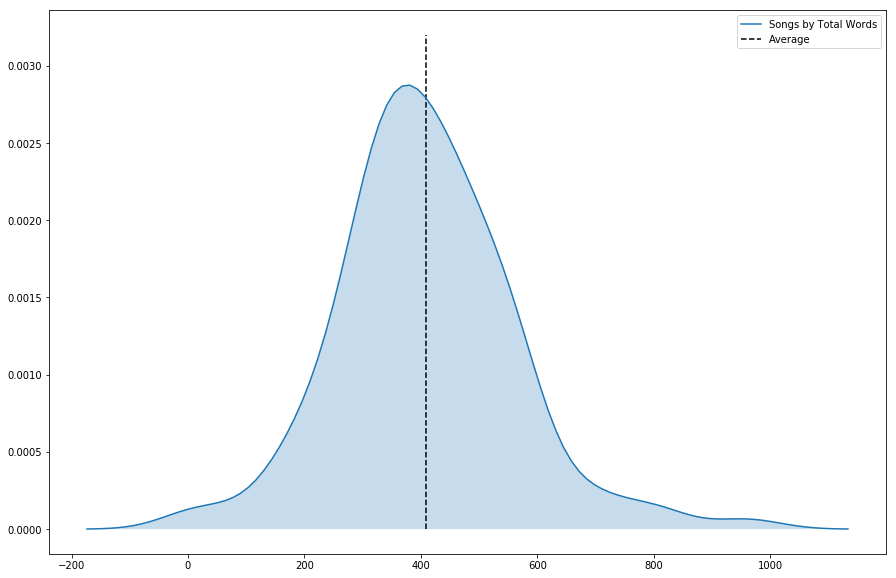

In [181]:
fig, ax = plt.subplots(figsize=(15,10))
sns.kdeplot(cleaned_lyrics_stats['total_words'], label='Songs by Total Words', shade=True, ax=ax)
plt.vlines(cleaned_lyrics_stats['avg_total'][0], 0, 0.0032, linestyles='dashed', label='Average')
plt.legend();

##### Unique Words

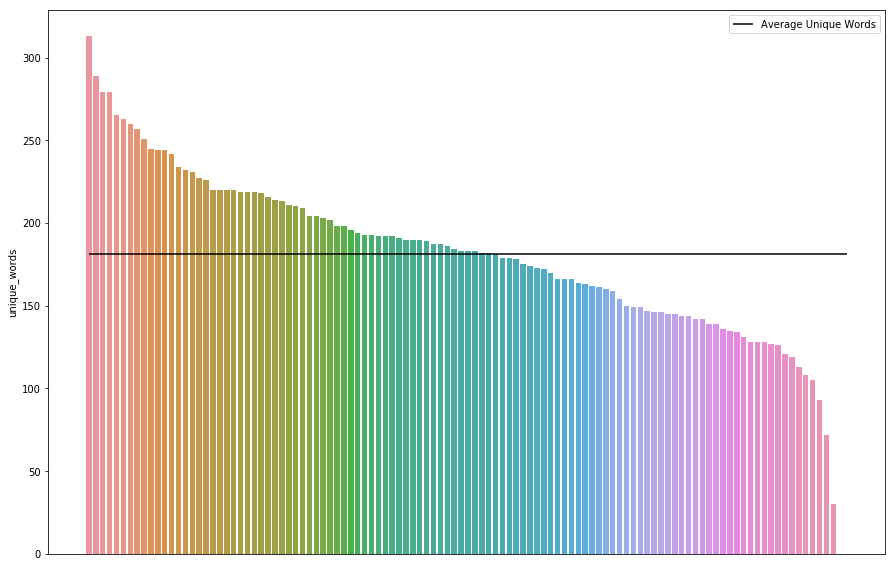

In [182]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(cleaned_lyrics_stats.index, cleaned_lyrics_stats['unique_words'].sort_values(ascending=False), ax=ax)
plt.hlines(cleaned_lyrics_stats['avg_unique'][0], xmin=0, xmax=len(cleaned_lyrics_stats), label='Average Unique Words')
plt.xticks([])
plt.legend();

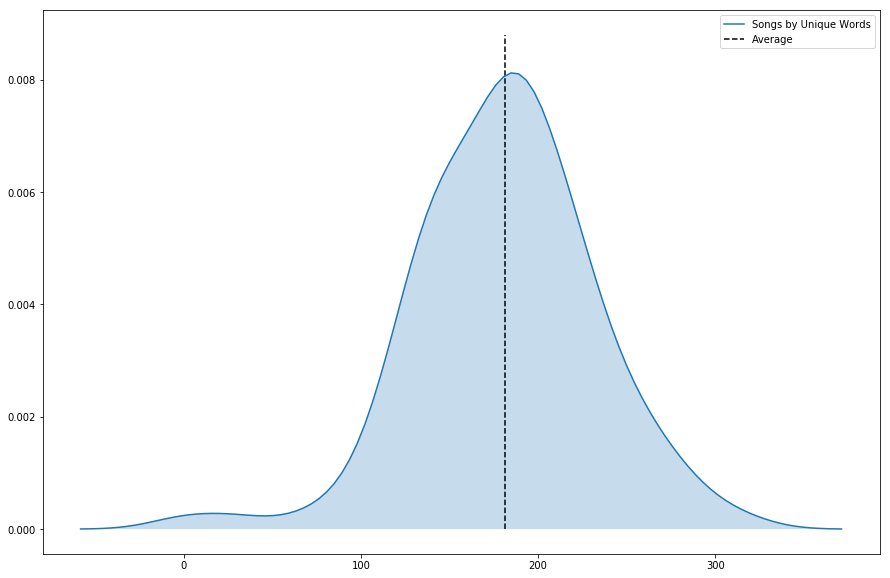

In [187]:
## Create Matplotlib figure + ax
fig, ax = plt.subplots(figsize=(15,10))

## Generate kdeplot
sns.kdeplot(cleaned_lyrics_stats['unique_words'], label='Songs by Unique Words', shade=True, ax=ax)

## Plot vertical line representing average + legend display
plt.vlines(cleaned_lyrics_stats['avg_unique'][0], 0, 0.0088, linestyles='dashed', label='Average')
plt.legend();

##### Unique to Total Ratio

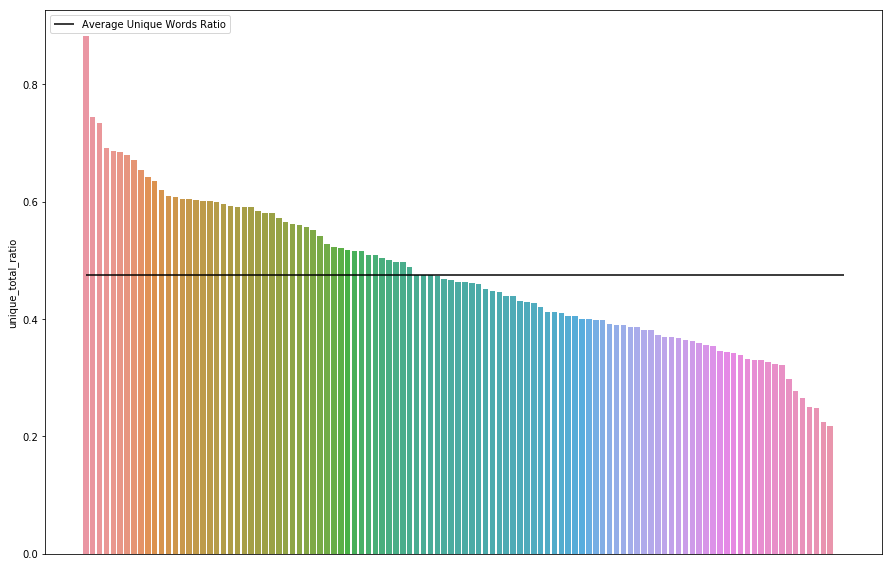

In [194]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(cleaned_lyrics_stats.index, cleaned_lyrics_stats['unique_total_ratio'].sort_values(ascending=False), ax=ax)
plt.hlines(cleaned_lyrics_stats['avg_unique_ratio'][0], xmin=0, xmax=len(cleaned_lyrics_stats), label='Average Unique Words Ratio')
plt.xticks([])
plt.legend();

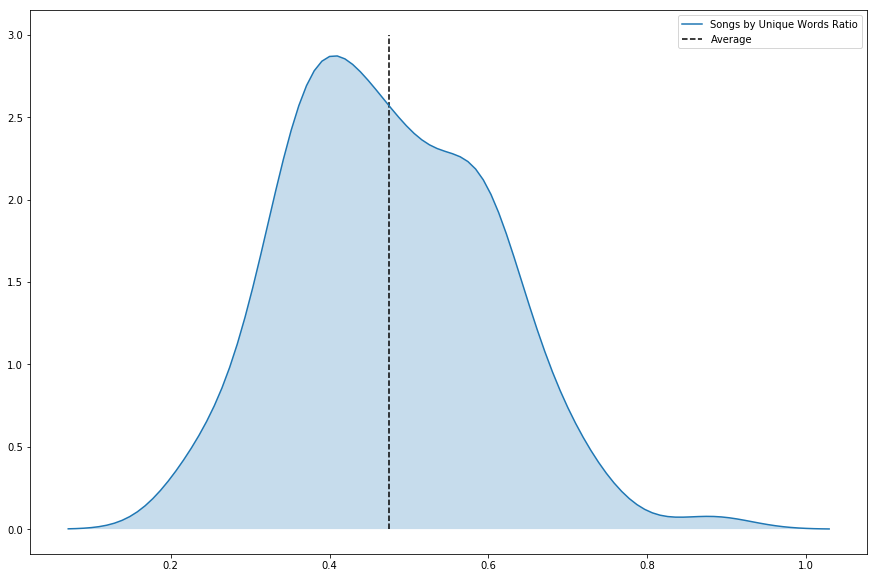

In [202]:
fig, ax = plt.subplots(figsize=(15,10))
sns.kdeplot(cleaned_lyrics_stats['unique_total_ratio'].dropna(inplace=False), label='Songs by Unique Words Ratio', shade=True, ax=ax)
plt.vlines(cleaned_lyrics_stats['avg_unique_ratio'][0], 0, 3, linestyles='dashed', label='Average')
plt.legend();

### Breaker

In [199]:
cleaned_lyrics['Do It All']

['looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind rewind',
 'looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind just playing with your mind',
 'i always thought play dumb and let the other one love',
 'why get caught up in nowhere but trust',
 'only love for fun im too young i thought',
 'all i wanted was a thanks to louboutins i bought',
 'but it aint your fault heaven knows you deserve it all',
 'you sent letters to my heart but i burned them all',
 'the bible says before you run gotta learn to crawl',
 'but i dont wanna waste time if we aint involved',
 'oh oh',
 'we been through it all',
 'i know i broke your heart once before',
 'but im done',
 'oh oh ohh',
 'tell me whats wrong',


12.12 **Plot out freq of bi-grams, plot out length per song, plot out unique words per song, pos tags**

12.9 **Stemming over Lemmatization** Just because Lemma-ing tokens will lose the actual word. Stemming will just shorten them

12.3 **Try these same graphs with stopwords removed.**

11.10 **NEED TO START HERE BY PULLING LIST OF FEATURES AND TRY TO MATCH UP WITH NAMES IN FEAT. PART**

Separate songs by feats or not.
* skip those with multi-results (for now)
* create list to match with from keys from lyric_header_checker

## Text Generation

12.10 **Finish By Character Generation Steps below READ THE DATA**

In [56]:
## Merging cleaned lyrics into one string + pop string out of container
cleaned_lyrics_string = dict_string_concat(cleaned_lyrics)
cleaned_lyrics_string = cleaned_lyrics_string.pop()
vocab = sorted(set(cleaned_lyrics_string))

## Q.C.
print(f'There are {len(cleaned_lyrics_string):,} characters in the sample.')
print(f'{len(vocab)} of these characters are unique.\n')
print(f'First 200 characters:')
print(f'"{cleaned_lyrics_string[:200]}"')

************************************************************
109 strings pulled from dictionary
************************************************************
There are 221,150 characters in the sample.
41 of these characters are unique.

First 200 characters:
"looking at the ceiling thinking why i treat you bad
aint no worser feelings than knowing i did it for the last
arguing all i was doing accusing you my bad
said lets take some time nevermind rewind
loo"


In [76]:
## Each index will match value corresp. to character key in 'char_v_idx'
idx_v_char = np.array(vocab)
print('Index ==> Character lookup table:\n')
print(idx_v_char, '\n')
print('---'*30, '\n')

## Assigning characters to their index
print('Character ==> Index lookup table:\n')
char_v_idx = {c:i for i,c in enumerate(vocab)}
print(char_v_idx)

Index ==> Character lookup table:

['\n' ' ' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' 'è' 'é' 'ó'] 

------------------------------------------------------------------------------------------ 

Character ==> Index lookup table:

{'\n': 0, ' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'è': 38, 'é': 39, 'ó': 40}


In [79]:
## Representing lyrics as integers
lyrics_as_int = np.array([char_v_idx[character] for character in cleaned_lyrics_string])

## Q.C.
print('Actual Lyrics:\n')
print(f'"{cleaned_lyrics_string[:22]}"', '\n')
print('---'*30, '\n')
print('Integer Representation:\n')
print(lyrics_as_int[:22])

Actual Lyrics:

"looking at the ceiling" 

------------------------------------------------------------------------------------------ 

Integer Representation:

[23 26 26 22 20 25 18  1 12 31  1 31 19 16  1 14 16 20 23 20 25 18]


Check Here! [By character generation](https://www.tensorflow.org/tutorials/text/text_generation) or Here! [By word generation](https://keras.io/examples/generative/text_generation_with_miniature_gpt/)

#### AZ Lyrics

In [51]:
## THIS IS FOR AZLYRICS ##

## Creating soup + Q.C.
start_soup = BeautifulSoup(start_resp.text, 'html.parser')
print(start_soup.prettify()[8422:8946])

      <div class="album" id="9188">
       album:
       <b>
        "No Introduction"
       </b>
       (2008)
      </div>
      <div class="listalbum-item">
       <a href="../lyrics/tyga/diamondlife.html" target="_blank">
        Diamond Life
       </a>
      </div>
      <div class="listalbum-item">
       <a href="../lyrics/tyga/coconutjuice.html" target="_blank">
        Coconut Juice
       </a>
      </div>
      <div class="listalbum-item">
       <a href="../lyrics/tyga/supersizeme.html" target="_blank">
 


### Linking Up

In [7]:
for t in lyrics[0]:
    try:
        if 'Tyga' in t.text:
            print(t.text)
            print(10*'--')
    except AttributeError:
        print(10*'**')        

********************
********************
********************
[Verse 2 - Tyga:]
Rubbin on my chain blowing cloudmatic
Smoke something with a G and bend that ass backwards
Lay back relax and talk mathematics
Later on we test a little sex practice
Write my name on the wall
Money in the mattress bet she wanna get involved
She hopped on the blunt said 'Where the hookah y'all? '
I tell her pass back if the shit too strong
It's all set; Mozart art on the blog so wet
I got a where I want her and I ain't done yet
Looking at your future baby put down the cigarette
Come hop on this kush jet and take flight
Tell em bitches 'mmm fuck that'
You wanna lay in bed I got a magic carpet for that ass yes
I'm also on one
Got two Olsen's on me
Big homie
Young Thugger Thugger rolling
Rolls Royce so shorty
--------------------
********************
********************
[Verse 3 - Tyga:]
Ben Frank baddies in the Benz waggin'
You know she want a ride home hop on the band wagon
I got the chain saggy
You know th

In [10]:
for t in lyrics[0]:
    print(t)

<p>[Hook x4 - Young Thug:]<br/>
Baby pass me the hookah<br/>
Pass me the hookah<br/>
Pass the hookah<br/>
Pass the hookah</p>


<p>[Verse 1 - Young Thug:]<br/>
Tearing up the place<br/>
I'm a rich nigga got chanel on my waist<br/>
Run up on me playin I'm a aim it at ya face<br/>
And that go for anybody... anyways<br/>
I'm a rich blood by the way<br/>
And I have swag roll it all like a tape<br/>
Fish scale, yeah I got these bitches on the bait<br/>
Don't wanna talk, man I said I need some space (woop woop woop)<br/>
My new car get geeked up<br/>
I just paid a cop, now I'm running out of court<br/>
Panoramic top, I'm a put it on the rocks<br/>
Crawl, walk and hop, got all these bitches shocked<br/>
Stone molly whiter than my socks<br/>
I don't, I don't wanna talk if it ain't 'bout guap<br/>
Clowning you niggas I see you flop<br/>
I buy pints by the 2 no Pac</p>


<p>[Hook x7 - Young Thug]</p>


<p>[Verse 2 - Tyga:]<br/>
Rubbin on my chain blowing cloudmatic<br/>
Smoke something with a G 

In [17]:
counter = 0
res = {}

while counter <= 5:
    for key in song_dict:
        song = song_dict[key]

        for t in song:
            try:
                if '[' in t.text:
                    print(key)
                    print(3*'--')
                    print(type(t))
                    print(5*'--')
                    print(t.text)
                    print(10*'--')
                    try:
                        res[type(t)] += 1
                    except:
                        res[type(t)] = 1
                    counter += 1
            except AttributeError:
                print(type(t))
                try:
                    res[type(t)] += 1
                except:
                    res[type(t)] = 1
                display(t)

Never Be The Same
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Never will I be the same... since the money
And cars came with the fame
We just party cause, throwing parties cause I've got a name,
For them life is the same,
But man, I will never be the same
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Never Be The Same
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Never will I be the same... since the money
And cars came with the fame
We just party cause, throwing parties cause I've got a name,
For them life is the same,
But man, I will never be the same
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Never Be The Same
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Never will I be the same... since the money
And cars came with the fame
We just party cause, throwing parties cause I've got a name,
For them life is the same,
But man, I will never be the same
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Never Be The Same
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Never will I be the same... since the money
And cars came with the fame
We just party cause, throwing parties cause I've got a name,
For them life is the same,
But man, I will never be the same
I will never be the same.
I will never be the same.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hookah (feat. Young Thug)
------
<class 'bs4.element.Tag'>
----------
[Hook x4 - Young Thug:]
Baby pass me the hookah
Pass me the hookah
Pass the hookah
Pass the hookah
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hookah (feat. Young Thug)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Young Thug:]
Tearing up the place
I'm a rich nigga got chanel on my waist
Run up on me playin I'm a aim it at ya face
And that go for anybody... anyways
I'm a rich blood by the way
And I have swag roll it all like a tape
Fish scale, yeah I got these bitches on the bait
Don't wanna talk, man I said I need some space (woop woop woop)
My new car get geeked up
I just paid a cop, now I'm running out of court
Panoramic top, I'm a put it on the rocks
Crawl, walk and hop, got all these bitches shocked
Stone molly whiter than my socks
I don't, I don't wanna talk if it ain't 'bout guap
Clowning you niggas I see you flop
I buy pints by the 2 no Pac
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hookah (feat. Young Thug)
------
<class 'bs4.element.Tag'>
----------
[Hook x7 - Young Thug]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hookah (feat. Young Thug)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Tyga:]
Rubbin on my chain blowing cloudmatic
Smoke something with a G and bend that ass backwards
Lay back relax and talk mathematics
Later on we test a little sex practice
Write my name on the wall
Money in the mattress bet she wanna get involved
She hopped on the blunt said 'Where the hookah y'all? '
I tell her pass back if the shit too strong
It's all set; Mozart art on the blog so wet
I got a where I want her and I ain't done yet
Looking at your future baby put down the cigarette
Come hop on this kush jet and take flight
Tell em bitches 'mmm fuck that'
You wanna lay in bed I got a magic carpet for that ass yes
I'm also on one
Got two Olsen's on me
Big homie
Young Thugger Thugger rolling
Rolls Royce so shorty
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hookah (feat. Young Thug)
------
<class 'bs4.element.Tag'>
----------
[Hook x7 - Young Thug]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hookah (feat. Young Thug)
------
<class 'bs4.element.Tag'>
----------
[Verse 3 - Tyga:]
Ben Frank baddies in the Benz waggin'
You know she want a ride home hop on the band wagon
I got the chain saggy
You know that life lavish
Lifestyles like this gon' need magnums
Pass baby
Welcome to rich class baby
You all Maybelline, with ya new Celine
Audemars on lean, cars on sheen
You white girl but black girl ghetto fly ting
It's verified, they ain't on your sea level
Watered eyes don't cry inhale and breath regular
My baby on it
High at the crack of dawn and
Body shape, figure 8 like Picasso draw ya
Oh yes I'm winnin'
Bling kingin'
Ring blingin'
Like like for no reason
Let's get closer, closed in
Remove your clothes we close friends
Don't get choked smoking OG Oakland
Shout out Oakland
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hookah (feat. Young Thug)
------
<class 'bs4.element.Tag'>
----------
[Hook x7 - Young Thug]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Riot (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Tyga: Verse 1]
Fuck that, fuck shit pay me
Rumors come and go, so I stay in a room presidential lately
Top of the roof, if a nigga start hating
Talk that shit, I aim for debating
Man I swear the game got so Clay Aiken
Bought a new crib, your bitch says it's spacious, Hagh
Ride to the motha fucken money (yeah)
Man I swear this shit about nothing (yeah)
Why you niggas ballin on a budget
Boy don’t get close, I press that button mothafucka
Leave a nigga roughed up, David Ruffin, Hagh
Niggas washed up, start scrubbing
Nigga get you covered in some clovers
You're an unlucky, mothafucka
Don’t be fuckin wit a young nigga
That’s T-Many, one fuckin problem
Really monsters need a doctor
I’m the sickest nigga bout it
No deciding, just a silence
On the sizzle, P90
Kill yourself like you're in college
It’s finals; cocky
Bitch don’t fight it (uhh)
Viam turn to violence (uhh)
Cash money party, guess you broke niggas ain’t invited


'\n'

Riot (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Hook x2: Tyga]
Fuck nigga, get yo bands up
Fuck nigga, get yo bands up
Fuck nigga, get yo bands up
We getting money, we turnt up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Riot (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Honey Cocaine]
Yellow bitch and I got this
It’s that black market, I’m shopping (uhh)
Last Kings and we bossing
Well I’m the first queen there’s no option (uhh)
I heard they hating, I don’t give a fuck
Tell 'em to fuck and suck on my cunt
Bitch get some dick cus you doing too much
I’m getting mine and enough ain’t enough
Getting richer
Money perfect picture
Oh no, I ain’t messing at the studio with your ninja
Top the name, I diss her
Kill your bitch, you gon' miss her
Bring that body shop and now watch that coffin fit her
Funeral home, bring you to the zone
Get you and your crew, or just you alone
I don’t give a fuck, I don’t take no breaks
Body your ho put her in her place
Now I’m out (uhh)
Don't try it at your house
Young gold Asian, and they know what I’m 'bout, bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Riot (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Make It Nasty
------
<class 'bs4.element.Tag'>
----------
Make it nasty, make it nasty
Drop drop it on a bitch, make it nasty
Make it nasty, make it nasty
Pop pop it on a bitch, make it nasty [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Make It Nasty
------
<class 'bs4.element.Tag'>
----------
Make it nasty, make it nasty
Drop drop it on a bitch, make it nasty
Make it nasty, make it nasty
Pop pop it on a bitch, make it nasty [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Make It Nasty
------
<class 'bs4.element.Tag'>
----------
Tap tap tap that ass make it nasty [x3] Clap clap clap that ass make it nasty
Tap tap tap that ass make it nasty [x3] Clap clap clap that ass make it nasty
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Make It Nasty
------
<class 'bs4.element.Tag'>
----------
Make it nasty, make it nasty
Drop drop it on a bitch, make it nasty
Make it nasty, make it nasty
Pop pop it on a bitch, make it nasty [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

We Up
------
<class 'bs4.element.Tag'>
----------
[Chorus]
All my niggas that be hustling we up tonight
And all my niggas that struggle we up tonight
And all the girls around the world going out tonight
Take a shot make toast we up for life, and we up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

We Up
------
<class 'bs4.element.Tag'>
----------
[Verse]
Uh, just made 50 in a tri-state
I spend it all cause when you young you can't pace
I bet I double up, '99 Mase
My ex said "I be missing you" Miss faith
It takes 2, like Rob bass
All of them pretty, but a rock in a hard place
Meet a lot of girls, state to state
Some one nighters, some I might date
I'm a fat boy, slim skinny tatted face
Brown Louie hard case, make your jewelry sleep safe
On my king shit, like the middle east
And the swagga stink like Kimchi
I'm the sh-t ? for the money bags
Like ? throwing dead presidents
It's all good that you're living nice
But when I get it all my niggas we gonna do it right
--------------------
<class 'bs4.element.NavigableString'>


'\n'

We Up
------
<class 'bs4.element.Tag'>
----------
[Chorus]
All my niggas that be hustling we up tonight
And all my niggas that struggle we up tonight
And all the girls around the world going out tonight
Take a shot make toast we up for life, and we up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

We Up
------
<class 'bs4.element.Tag'>
----------
[Verse]
Like a new born in the cradle, uh
Feet first like a baby born backwards (we up, we up)
Tell the bank tell em time to re-up, re-up
Damn, everything I see calling ?
So many niggas copying my style
Coming to america through a cloud
Just left Switz sold out crowds
Uh, Vietnamese chicks with the big smile
Pekingese puppy rapped in a beach towel
Killing me softly like Lauren Hill
Built for love but love won't keep it real
Can't waste time we up and dollar bills to my soul
In god we trust
I love mama when the keys but she down to fuck
Tell the bartender to fill me up, fill me up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

We Up
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
All my niggas that be hustling we up tonight
And all my niggas that struggle we up tonight
And all the girls around the world going out tonight
Take a shot make toast we up for life, and we up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

We Up
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

2 AM
------
<class 'bs4.element.Tag'>
----------
[Intro/Chorus: repeat 2X]
It's 2 AM in the mornin
Pressin my alarm again
Stressin over my mom and friends
Sometimes, I wish I was in a coma
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

2 AM
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

2 AM
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

500 Degrees (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
T-raww, fuck y'all, money tall, dick large
Tiger in my backyard, bitches on my futon
Dog house, no dog, shootout, Chris Paul
Walkin' on the marble floor, take your fuckin' shoes off
Bitch this is fox fur, killin' shit, fuck a hearse
I can show you my choppa works
She give me head, when my head hurt
Deep throat, till the bitch burp
Her best friend said let me at 'em (Adam), Cousin Lurch
Smokin' on that turf, get your feelings hurt
At your neck like a collared shirt, ball like a Nerf
Word, more green nigga than smoking pot
When I see more, I'm that whore from that little shop
Shop, butcher shop, open up your top
All you see is gold watch, Rolls Royce, road blocks
Sun roof, fogged out, chrome grill, gold mouth
Take a fuckin' look around
--------------------
<class 'bs4.element.NavigableString'>


'\n'

500 Degrees (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook x2: Tyga]
Bitch I'm all you need
I say fuck them other niggas
Fuck them other niggas
Bitch I'm all you need
I'm the hottest nigga, all I do is turn up, bitch
500 degrees
--------------------
<class 'bs4.element.NavigableString'>


'\n'

500 Degrees (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Thrilla manilla, I buy straight from the dealer
I 'm politickin' in Paris, I'm buying statues and pillars
All from the Louvre nigga, mosaics from the museum
You niggas countin', you bitch is in my DM,
I never read 'em, weak bitch probably get seasick
On the yacht eat shrimp, see my name on a blimp
It read T-Raww's a pimp
Nigga I ain't dancin' but my hand on my hip
Full clip, movie shit, Bruce Wayne, Alfred
Niggas want a verse, can't even get an ad-lib
I'm killing this shit, and I'm killing your mom
Over a set of time, the... are mine
I murdered this shit, just takin' my time
Got bars, front gate, face shot, blind date
Rolex, timepiece, ain't got no time for no bitch speech
120 that six speed, pull it out that's all me
Just call me T-papi
--------------------
<class 'bs4.element.NavigableString'>


'\n'

500 Degrees (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook x2: Tyga]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

500 Degrees (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Lil Wayne]
Tunechi over bitches
Smokin' Color Purple, blunt fat as Oprah Winfrey
I'm the nigga, the nigga, nigga, the nigga, nigga
I be snappin', I hope you get the bigger picture
I said fuck that nigga that you fuckin'
She say that nigga rap, I say he couldn't (w) rap a mummy
But let me pass the weed, and stop passin' judgement
Before I have to beat him like a dick he had it comin'
Been eating so much pussy, man I'm starting to get chubby
Schoolin' motherfuckers, I'm their favorite subject
Broomstick in my pants, I'm 'bout to go witch huntin'
I'm already loaded, these niggas still bufferin'
I fuck my girlfriend and her best friend, these niggas is lesbians
Don't cross me like a pedestrian, I'm getting head watchin' ESPN
She holdin' me and carressin' me
Don't hate the player, hate the referee
If she F with me, I am definitely a necessity
--------------------
<class 'bs4.element.NavigableString'>


'\n'

500 Degrees (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook x2: Tyga]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

95 Like Dat
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
95 scholar, straight shots, gold medallion
Put your number on this paper promise I’mma dial it
Cute college chick, daddy was a doctor
Word through the grape vine she datin’ a rapper
Entertainer, Avonlea she never after
So I entertain her late night with laughter
High, ten after midnight, it’s bedtime
You could say I stole her heart
I just call it bedtime
No rush, just relax your mind
You are now listenin’ to sounds of a better rhyme
Benz and driver, mosh pit in the lobby
Girls so horny, that’s my type of party
No ties, mob shit, suits and ties
Crap table, Vegas, vampire nights
I’d marry you tonight just to say we did it right
Waking up with regrets, roll over, she be like:
--------------------
<class 'bs4.element.NavigableString'>


'\n'

95 Like Dat
------
<class 'bs4.element.Tag'>
----------
[Hook]
“Why you never call me back?”
Sometimes it just be like that
Can’t promise you the world
but I can promise you half of that
Sometimes it just be like that
All the rumors you heard
I ain’t got no time for that
Shit, I ain’t got no time for that
And you ain’t gotta cry, dry your eyes,
We gon’ get through that
Trust, we gon’ get through that
95 like that
--------------------
<class 'bs4.element.NavigableString'>


'\n'

95 Like Dat
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Reservations, call, reserve a table
I like gator, snake skin, Purple Label
Polyester, black berretta, who do it better?
For my niggas caged up, writin’ them letters
Lower level, reportin’ live, Channel 11
No emergency, but I’m in a 9-11
Falsetto, girl scream, a rare fellow
Pull up to the scene bumpin’ only instrumentals
And we know it
Times flies when you fly in first class all the time
And we know it
No time for the games, dollar signs on my mind
And we know it
Eye for an eye and killa just tryin’ to stay alive
And we know it
Gotta learn to live or regret, I regret some times
--------------------
<class 'bs4.element.NavigableString'>


'\n'

95 Like Dat
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

95 Like Dat
------
<class 'bs4.element.Tag'>
----------
[Verse 3]
Litigations, black faces, lawyers, brief cases
Agents top notch, paid investigations
Fire Dorf Todd, block shots, Anthony Davis,
Raww the greatest, acres, no neighbours
Die so many times, hope we do better next time
Think about it, dog, next time you drop a dime
Better ride, said she’d rather fly
Always asking me the same thing all the time
--------------------
<class 'bs4.element.NavigableString'>


'\n'

95 Like Dat
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
She' don't know my name
She just know me by my aim (aim aim) [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Aim tyga man again
Got a little message for my instant friends
Be back in a mintue on vacation
Away from them haters hating on him
Introducing the musician
Gotta be more then a 4 to impress him
Punch in my pin
And begin the chatting
Ichat the best mac book I'm a mac yes
Getting every dollar g.e.d dymes
Captial charge I did the crime
Can't take the heat don't feel the fire
She difficult to reach but I'm harder to find cause
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
She don't know me by my name
She just know me by my aim
My song on her page on myspace
Never seen her face
She send messages
I sign on it's like aim aim aim
She don't know me by my name (name name)
She just know me by my aim (aim aim)
She don't know me by my name (name name)
I sign on it's like aim aim aim
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
She don't know my name
She just know me by my aim (aim aim) [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Replenish my sins repeat then repin
Next chick buddy list gotta sleep
On the tricks
Magic magician what the games been missing
Rap is favorite swagg and she diggs
This is turning into a daily thing
Comma routine baby how you doing?
Alright hows your music
Just fine
I'm getting tired brb I typed her
Phone on silent no time for drama
Too busy bottle poppin
Poparazzi recording
Recording my oasis only
Always on point like ginolle
Come card me
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
She don't know me by my name
She just know me by my aim
My song on her page on myspace
Never seen her face
She send messages
I sign on it's like aim aim aim
She don't know me by my name (name name)
She just know me by my aim (aim aim)
She don't know me by my name (name name)
I sign on it's like aim aim aim
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
She don't know my name
She just know me by my aim (aim aim) [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
[Bridge:]
ASL lol tyga don't care but
Only females, what's your email
Promise I won't tell
Flick for a big trade it never fails
--------------------
<class 'bs4.element.NavigableString'>


'\n'

AIM
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
She don't know me by my name
She just know me by my aim
My song on her page on myspace
Never seen her face
She send messages
I sign on it's like aim aim aim
She don't know me by my name (name name)
She just know me by my aim (aim aim)
She don't know me by my name (name name)
I sign on it's like aim aim aim
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

All Gold Everything
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Gold all in my chain, my chain, bitch
Gold all in my rang, my rang, bitch
Gold all in my watch, my watch
Don't believe me, just watch
Nigga nigga nigga
Don't believe me, just watch
Don't believe me just watch, bitch
Nigga nigga nigga
Don't believe me, just watch, bitch
Don't believe me, just watch
Gold all in my chain
Gold all in my ring
Gold all in my watch
Don't believe me, just watch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

All Gold Everything
------
<class 'bs4.element.Tag'>
----------
[Verse:]
T Raww I don't fuck with niggas
My money long, my temper midget
King gold chains I reinvented
This gold shit, you a gold fish nigga
Try me, four kings like free sale nigga
Sippin' out a cup like a toddler, nigga nigga
Who the fuck want drama, pain,
Back at it like a chiropractor, mane
That that nigga rock a quarter mil in chains
Gat squirt at ya like Stacey Lane
Nigga nigga sunroof ya brain
Came out to drink but you can't even hang
Only came 'cause a nigga got paid
Sleep with them hoes, they gon' fuck up your name
Pop the Zanny I'm stressin'
Pop the molly I'm flexin'
Dre Beats my beats bang, biker jeans, ball mane
She suck me off till I'm all drained
Kick her out, Liu king
Wide body need two lanes,
Got a 5-0-4 bitch that go to Tulane
Niggas think that I'm playin'
I ain't sayin' this shit to be slayin' a nigga
Make your bed, lay in it, fucker
Born sinner, make a nigga die for his dinner
Eyes of a tiger, stone kille

'\n'

All Gold Everything
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

All Love
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Don't you worry about the beef my nigga
Everything's straight
When you see me in the hood
Don't worry you ain't gotta hate
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

All Love
------
<class 'bs4.element.Tag'>
----------
Look, hate to glit it
Wrist in hand
This ain't no little man
Just presidential rolex and
This is my biggest sin
Jealously attracting them
Trying my best to do less
Trying my best but, I'm such to a greater extent
My phone rings, a block call, 2 a.m
Who could it be, not moms. she's [?]
[?]
Smilin, sayin her son paid it
Like if one make it
We all made it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

All Love
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

All Love
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Intro:]
I need you [x8]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook - Chris Brown:]
We poppin' like ayo
All my bitches got real hair chilling with the top down
Screaming like ayo
I'mma take her ass down when she bring her friend around
Poppin' booty like ayo
I'm a boogie ass nigga left the roof at home
We popping like ayo, ayo, ayo
But don't be acting like I need you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Tyga:]
Ahhh! Aye babe this my new shit
I'm the black Richie Rich with the roof missing
If it don't make dollars it don't make sense
Z, wake up like I gotta get it
And I got a engine with a trunk space
I get money three ways, fucking bitches three ways
7 different foreigns plus she no hablé
But I make that bitch walk with some cheesecake
Yeah, I'm the coldest nigga, icy
Looking in the mirror like I wish I could be me
She too into me, I'm more into money
My hobby's her body, that pussy's my lobby
I'mma eat it, I'mma eat it
I don't lie, hold my dick, too conceited
Uh, told her she's my wife for the weekend
But don't be acting like I need you cause we poppin' like
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Chris Brown:]
I'm in a Rolls, you don't roll right
My chain shine brighter than a strobe light
I'm tryna fuck Coco, this don't concern Ice
If I motorboat, she gon' motorbike
A nigga ain't worried about nothin'
Rehabilitation just had me worried about fucking
Money, decision-making only worried about stunting
She worried about me, her nigga worried about cuffing
I wanna see her body (bodyyyy)
She said get inside of me
I wanna feel you baby (yeahhh)
Just bring the animal right out of me
We loving, she love it
See when I go down on her
Now we fucking, she thugging
Getting loud (cause we poppin' like)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 3 - Chris Brown (Tyga):]
Huh, look, alright
Now I can spot your bitch from a mile away
Valentine in that pussy, it's a holiday
(Uh, you losing money, I windmills Dr. J
She going to follow my lead, Simon Says)
Paper, paper, I'm riding scrapers in California
Car smelling like ammonia, we got that stank on us
(Never been an outcast that stank on ya
From the ghetto but my bitch like Apollonia)
We in the hood, tatted like a Mexican
Car too fast, give a fuck about pedestrians
(And my section less niggas, more lesbians)
Got your bitch, I'm that nigga
(Yeah we poppin' like)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayo (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Outro - Tyga:]
This that fly shit, King shit only
Drop top, no roof - ahhh!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayy Ladies (feat. Travis Porter)
------
<class 'bs4.element.Tag'>
----------
Aaughh [9x]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayy Ladies (feat. Travis Porter)
------
<class 'bs4.element.Tag'>
----------
[Travis Porter]
Okay Now Ladies (Yeah)
If You Know You Bad (Yeah)
Don't Need No Man, Got Yo Own Bands
Put Up Yo Hands
If You Ah Top Notch Bitch, Let Me Hear You Holla
Bend It Over, Touch Yo Toe, Whip It Out,
Show Them Hoes Yo Bankroll, Slang It Out,
Do The Broke Hoe With It, Poke It Out,
DAMN Shawty You CAN Get It
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayy Ladies (feat. Travis Porter)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Ughh 1234 Give The Booty 5,
I Like My Bitches Real Thick, Lil More Thighs
Richer Than Yo Ol' Head, No Lie, Stacks In That
Pussy Hole, Call Dat The G-Spot,Real Gentlemen,
Fuck And Never Call Again, I'm Hot,
I'm Fresh Up Out Of Dat Water, I Didn't Even Swim
I Heard She Got Ah Nigga, Well He Can Be Yo Man,
Maan I Wouldn't Shake His Hand With Ah Broke Hand,
I Don't Fear Na Nigga, Boicoodam,
Make A Bitch Strip Butt-Naked Like She Pole Dance,
Standing In The Club On On A Couch Shit,
Grab The Mic, Then Announce This,
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayy Ladies (feat. Travis Porter)
------
<class 'bs4.element.Tag'>
----------
[Travis Porter]
Okay Now Ladies (Yeah)
If You Know You Bad (Yeah)
Don't Need No Man, Got Yo Own Bands
Put Up Yo Hands
If You Ah Top Notch Bitch, Let Me Hear You Holla
Bend It Over, Touch Yo Toe, Whip It Out,
Show Them Hoes Yo Bankroll, Slang It Out,
Do The Broke Hoe With It, Poke It Out,
DAMN Shawty You CAN Get It
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayy Ladies (feat. Travis Porter)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Man I Get It, Man I Get It, Get It In For real
She Ain’t With It,
I Ain’t Tripping Got One At The Crib
Planking On The Maybach, This Is How I Live
Give A Bitch Banana Dick, Then I Make Her Do The Split
Heard You Was A Trick, Trick Them Bitches You Ah Pimp
Man That Bitch Simple, You Ain’t Gotta Sip
I’m Flyer Than A Blimp Fly How She Getting Hit,
Wide Body Benz, Rosanning On The Whip, No Tan,
But Dat Heat Son, Burn A Bitch,
Niggas Straight Snitching, Report Like Journalist
Hell I’m On My Shit, Like Horses Is
Grab A Friend, Then Tell Her This This This,
Yup Yup 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ayy Ladies (feat. Travis Porter)
------
<class 'bs4.element.Tag'>
----------
[Travis Porter]
Okay Now Ladies (Yeah)
If You Know You Bad (Yeah)
Don't Need No Man, Got Yo Own Bands
Put Up Yo Hands
If You Ah Top Notch Bitch, Let Me Hear You Holla
Bend It Over, Touch Yo Toe, Whip It Out,
Show Them Hoes Yo Bankroll, Slang It Out,
Do The Broke Hoe With It, Poke It Out,
DAMN Shawty You CAN Get It
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
All day long, do it like Tony
Fuck her friend then I pass it to the big homie
Got a sign on my dick, bad bitches only
Got a sign on my dick, bad bitches only
Big bank roll, do it like Tony
Fuck her friend then I pass it to the big homie
Got a sign on my dick, bad bitches only
Got a sign on my dick, bad bitches only
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 1]
Well its that nigga that you call T-Raw
Runnin' that money like Madoff
Yea she gave that blow job then she get it laid off
I ain't got no time hoe, stop blowing up my cell phone
Sweatin' me like headbands, call that bitch Rondo
I'm fresher than the Prom hoe, teach ya we don't fly coach
Fuckin' but she act dumb, kick her out my condo
Real G's, Last King, Young Money ballin'
I give her a couple of shots and then she turn alcoholic
Metaphorically or Rhetoric
And I'm shittin' on your forehead
2 girls 1 cup...Yup
We did it again Last King YMCMB
I don't pay for bitches, bitches pay me
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Gudda Gudda - Verse 2]
Uh, Knock knock, who the fuck is there?
A sign on my dick that say, "bad bitches come in here"
Make a freak whore, detour straight to my partna room and let him beat it like a keyboard
All I do is dick 'em I don't tip 'em like a stripper man
I got a ton of chicks under my belt like a zipper, yea
Walk up in the club, pick 'em out and then I pick 'em off
Pick 'em up and then knock em down and them I drop 'em off
I'ma dog keep your girl from round my type of shit or she'll be milk box material
And missing for the night man this shit is just that easy
When your pockets sittin' right
I turn my bed into a stage and let your girl rock on my mic
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (Remix) (feat. Gudda Gudda, 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga:]
All day long
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
Big bank roll
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (Remix) (feat. Gudda Gudda, 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Tyga:]
Well it's that nigga you call T-raw
Runnin' that money like Madoff
Yeah she gave that blowjob
Then she gettin' laid off
I ain't got no time ho
Stop blowin' up my cell phone
Sweatin' me like headband
Call that bitch Rondo
I'm fresher than the prom ho
Teach her, we don't fly coach
She fuckin' but she act dumb
Kick her out my condo
Real G's, Last King, Young Money ballin'
I give her a couple of shots and then she turned an alcoholic
Methaphorically I'm a toilet
And I'm shittin' on your foreheads
2 girls 1 cup
Yup
We did it again Last King, YMCMB
I don't pay for bitches
Bitches pay me uhh
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (Remix) (feat. Gudda Gudda, 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga:]
All day long
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
Big bank roll
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (Remix) (feat. Gudda Gudda, 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Gudda Gudda:]
Knock knock
Who the fuck is there?
Sign on my dick that say
Bad bitches come in here
Make a freak whore, detour
Straight to my partner room and let him beat it like a keyboard
All I do is dick em'
I don't tip em' like a stripper
Man I gotta' ton of chicks under my belt
Like a zipper
Yeah
Walk up in the club
Pick em' out and then I pick em' off
Pick em' up and knock em' down
And then I drop em' off
I'mma dog
Keep you girl from around my type
Or she'll be milkbox material
And missin' for the night
Man this shit is just that easy
When yo' pockets sittin' right
I turn my bed into a stage
And let yo' bitch rock on my mic
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (Remix) (feat. Gudda Gudda, 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga:]
Uhhh
All day long
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
Big bank roll
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (Remix) (feat. Gudda Gudda, 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Verse 3 - 2 Chainz:]
First I check my Rolley
Then say "watch me do it"
Watch me do it, show you how to cook like Martha Stewart
I want some cheesecake I have you walkin' to it
Plus I stack my money tall don't you walk in to it
Just do it all I do is smoke jet fluid
Fuck her with my chain on so my charm can hit her booty
Outrageous with the Louis I'm a fashionaire
Ever since 16 I been a fuckin' thousandaire
They know me by my nickname in the dealership
And all my shows are funeral homes I keep killin' shit
You used to get money so you reminisce
And if yo' bitch get with this she'll get benefits
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bad Bitches (Remix) (feat. Gudda Gudda, 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga:]
All day long
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
Big bank roll
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
Bad bitches only
Got a sign on my dick
Bad bitches only
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bang Out (feat. Easy E & Ice Cube)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Hold up, money talk so you know what?
Ain’t nothing to talk about, you ain’t got enough cuz
Rock star drugs break a bitch heart, no love
Emma Watts, Charlie Sheen, fuckin with no scrub
Niggas want connects, got no plugs
Nigga say they high, got no buzz
Popsicle niggas wanna talk shit then say you froze up
Young niggas wanna pop pills, just po up
Went on a bang, Went on a bang
Bitches came for me and my nigga eazy
Threw that bitch out, got that ho one way
Said she tryna stay, told that bitch no way
That’s a preme nigga, B ripper, grim reaper
I don’t get mad bitch, I just get even
T-Raw magician, I don’t gotta trick or treat it
That Ferrari California make a bitch a believer
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bang Out (feat. Easy E & Ice Cube)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Million dollars’ worth of cars, all paid out
See you niggas hatin, had to pull my chains out
Make it rain even when it’s rained out
Turn up, bang out
Bang out, bang out
Turn up, b-bang out
Million dollars’ worth of cars, all paid out
See you niggas hatin, had to pull my chains out
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bang Out (feat. Easy E & Ice Cube)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Met a bitch last night, won’t believe it
Fuck her so hard, bitch probably stopped breathing
Killed the pussy, in the hotel screamin
Knock knock, going in like the housekeeper
The room, keep it
I fucked now I don’t need it
T-Raw semen splattered on a bitch beaver
Pipe dreamin, fuckin with a real baller
The bitch is a bitch so I’m gon call er
Then they act up, call the backup
Don’t matter, as if she ever mattered
Bitch shut up, throw it up, I throw the set up
Tell her sit up, got her face down, bitch don’t put yo head up
Yea, bitin on er ear
Got a old bitch, pussy like souvenir
I hop up in it, nigga I ain’t never scared
Closet full of straps and the condom right here
What I got?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bang Out (feat. Easy E & Ice Cube)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Million dollars’ worth of cars, all paid out
See you niggas hatin, had to pull my chains out
Make it rain even when it’s rained out
Turn up, bang out
Bang out, bang out
Turn up, b-bang out
Million dollars’ worth of cars, all paid out
See you niggas hatin, had to pull my chains out
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bang Out (feat. Easy E & Ice Cube)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Eazy-E]
Beef on the street, to the beach I be rollin
Never see me strollin, 40’s I be holdin
Girls in the daisies, drive easy crazy
Rolled up my windows as I turned on my AC
Rollin down Crenshaw, see the hoes jockin
Sunday nights poppin, see the foes hoppin
My stereo’s bumpin that ATL funk
You can call it what you want
Either way the shit bump
I’m a evil motherfucker ready to tear shit up
I’mma put these things on you and never let up
See my mama, she was home when I was born
Bet a nigga like to eat shit than never been born
But I ain’t going out unless 30 niggas die
I’m dyin anyway so I’m thinkin suicide
Shut the fuck up nigga cuz you ain’t seen shit
I’m bout to take this blade and straight up rip
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bang Out (feat. Easy E & Ice Cube)
------
<class 'bs4.element.Tag'>
----------
[Outro: Ice Cube]
A bitch is a bitch
So if I’m poor or rich
I talk in the exact same pitch
Now the title of bitch don’t apply to all women
But all women have a little bitch in em
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Be Quiet (with Soulja Boy)
------
<class 'bs4.element.Tag'>
----------
[Soulja Boy Verse]
wuz goin on these niggaz out here wildin
They Don't want won't beef, better run to police.
Better yet man you better keep quiet.
iguana seats inside it, I'm flying on auto pilot
Deep in these streets, spittin crack on these beats.
But the word on the street is keep quiet.
Me and my nigga tyga, patron got us wildin
Stereophone cup, throwing money in my clubs, oh you mad becuz I'm stylin.
Crush diamonds on my amuelet
Its lookin like a slush hoe.
Niggaz meaning muggin, better keep that shit on hush mode.
25 Kush blunts, I call dat shit a quarter
Took her to my crib and make her strip like fishburne daughter
I swag to hard too I do it like no other
runnin round talkin tellin keep that undercover
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Be Quiet (with Soulja Boy)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Jewerly too loud man I need to be quiet.
What's that on my wrist? I told that bitch to be quiet.
Gone on patron man I swear it got me wildin'
If he know like I know tell that nigga be quiet.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Be Quiet (with Soulja Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga Hook]
Uhh.Jewelry to loud motherfucka its a siren.
Big fuckin dogs you can hear my wolves hollerin'.
On this patron man I got these bitches wildin'.
If he know like I know tell that nigga be quiet.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Be Quiet (with Soulja Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Ugh. Well its that big woolly monster pull up,
pull up on your bumper mothafucka pull your mother slum dog million, hold up.
I'm so cold I think I froze up.
Melt that money like its nothin. Ugh.
Spend it like I print it bitches blow it by the hundreds.
Young Money this aint new.
You just got up on it.
I'm Big Willy chillin nigga you just little homie.
I just flew Paris Gordon Ramsey up in London he throw,
he so, go why dont I put you on it on it?
Too many Twitter followers, many I'm poppin.
Maybe its my big Why these hoes keep on watchin.
I'm tatted out my mind literally I'm out my mind.
I'm G'd up all the time. On some G Shit Be Quiet!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Be Quiet (with Soulja Boy)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Jewerly too loud man I need to be quiet.
What's that on my wrist? I told that bitch to be quiet.
Gone on patron man I swear it got me wildin'
If he know like I know tell that nigga be quiet.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Be Quiet (with Soulja Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga Hook]
Uhh.Jewelry to loud motherfucka its a siren.
Big fuckin dogs you can hear my wolves hollerin'.
On this patron man I got these bitches wildin'.
If he know like I know tell that nigga be quiet.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Birdman Interlude
------
<class 'bs4.element.Tag'>
----------
[Birdman]
The young king... the lil homie Tyga
It's yo turn, nigga... it's yo turn, playboy
West Coast stand up to this Careless World, people
Global flying on this journey...
Tropical islands, poppin' bottles with supermodels...
Blowing up the pounds (sunup to sundown)...
Flying at higher heights... grinding hard...
Money by the abundance...
Yeah, YMCMB flashy life...
What it do, young king... it's yo turn, boy...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch Betta Have My Money (feat. YG, Kurupt)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Bitch better have my money (Bitch) yea
Bitch better have my money
Bitch better have my money (Bitch)
Bitch better have my money
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch Betta Have My Money (feat. YG, Kurupt)
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Bitch better have my money, money
Bring back a hundred take twenty, twenty
Twenty more minutes then I'm coming
I could fuck you longer but bitch I'm in a hurry
Hu-hurry up Usain Bolt to the money
Swear I'm the shit, everybody fly around me
Rub like hustling you hustling wit dummies
I got a big ego, bitch don't touch me
Fuck her for some money, Fuckin out the country
Pistol whip the homies, you at home lonely
colin macaulay, coco white boobies
Fuckin fuck tha police, these niggas know they know me
50 for the rolly, niggas ain't brodies
hoes got em trippin, cuff her like cuff links
don't know where her tongue be, rinse it in the fuckin sink
I don't care what the bitch think, I just know one thing
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch Betta Have My Money (feat. YG, Kurupt)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch) YA
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch Betta Have My Money (feat. YG, Kurupt)
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Bitch better have my money
If the bitch dont tell her bounce like a bunny
I don't give a fuck bout what that bitch talking
she ain't got the cash tell that bitch get to walking
I eat sleep shit think about them dollars
pop a pill, pop a nigga, pop my colla
I'm popping like a tic-tac
bitch you better get back
Funny looking bitch
who you been fuckin sin bad?
I did dat, do it all go big,
never small, got a crib wit a closet
you would think you at the mall
in the mouth like halls
in the jaws like wisdom teeth
You hear da beat?
I bet you they gon bang this in the middle east
I been a freak
9th grade i was fucking in the bathroom
I was fuckin at school like my house didn't have rooms
my best friend is named benjamin frank
so bitch better have my cake fo hunnit !
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch Betta Have My Money (feat. YG, Kurupt)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch) YA
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch Betta Have My Money (feat. YG, Kurupt)
------
<class 'bs4.element.Tag'>
----------
[Verse 3]
Man this bitch better have my money
this bitch so smart she nothing but a dummy
bitch better have my mulla
fuckin round with a real nigga and a shoota
little dust back bitch make a nigga rich
shut the fuck up, and jump on this dick
nothin but a motherfuckin skank
fuck what you talking bout and fuck what you thank
I need money I need it real fast
I need it real bad like white girls need ass
maybe you can help me break this dub
twenty motherfuckin racks up up in the club
Club up up in the front thats why I send that bitch to get each one
top rank treat her like a bank I don't give a fuck a bitch think bitch what you saying
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch Betta Have My Money (feat. YG, Kurupt)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
Bitch better have my money (Bitch)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Bitch I'm The Shit
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Uh bitch I'm the shit
Bi-Bitch I'm the shit
Bi-Bitch I'm the shit
I ain't worried bout shit
Bi-Bitch I'm the shit
Bi-Bitch I'm the shit
I'm on my own shit
you don't see my outfit
Bitch I'm ballin ballin ballin ballin ballin
Bi-bi-bitch I'm the shit
See me ballin ballin ballin ballin ballin
Bitch I'm the shit
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch I'm The Shit
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Bitches all in my car, they want to run with the star
Got all these niggas mad, pop the trunk flash a face off
Nigga you ain't met T-Raw, hit the bass so hard
Got bitches taken it off, I can't fuck wit she too tall
Got a bitch dat play ball, found the pussy I charge
Make that ass applaud, i don't cuff it like the law
I fly a bitch to milan, she don't know what I'm on
I play the game so crazy, she thinking this shit soft
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch I'm The Shit
------
<class 'bs4.element.Tag'>
----------
[Hook]
Reel em in, wheel em in, like bana white in wheel a fortune
Why you all up in her face, man she thinking that shit torture
I I win again win again cuz nigga I stay scorching
I'm the man man on fire kill the style like abortion
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch I'm The Shit
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Cuz bitch I'm the shit
Bi-Bitch I'm the shit
Bi-Bitch I'm the shit
I ain't worried bout shit
Bi-Bitch I'm the shit
Bi-Bitch I'm the shit
I'm on my own shit
you don't see my outfit
Bitch I'm ballin ballin ballin ballin ballin
Bi-bi-bitch I'm the shit
See me ballin ballin ballin ballin ballin
Bitch I'm the shit
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch I'm The Shit
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Man these hoes problems so I fuck em never call em
but I love love black woman and they love whats in my wallet
got got gold on in dis frozen C
that last king move over, Talkin loud like my molder
you want some scary shit like october HAHA
take a seat have a soda why you staring over your shoulda
you good man we don't want ya
and you faker than willy wonka
real shit I told you, new styles i showed ya
got green like its a locust, why you on my bumper I'm focused
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch I'm The Shit
------
<class 'bs4.element.Tag'>
----------
[Hook]
Reel em in, wheel em in, like bana white in wheel a fortune
Why you all up in her face, man she thinking that shit torture
I I win again win again cuz nigga I stay scorching
I'm the man man on fire kill the style like abortion
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitch I'm The Shit
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Cuz bitch I'm the shit
Bi-Bitch I'm the shit
Bi-Bitch I'm the shit
I ain't worried bout shit
Bi-Bitch I'm the shit
Bi-Bitch I'm the shit
I'm on my own shit
you don't see my outfit
Bitch I'm ballin ballin ballin ballin ballin
Bi-bi-bitch I'm the shit
See me ballin ballin ballin ballin ballin
Bitch I'm the shit
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Bitches (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown:]
Higher than the moon, nigga what up
They ain't worth it, nigga need to shut up
While I'm in the pussy, face down in the buttock
It ain't shit to her, me im just a fuck up
Fuck a hand shake nigga we ain't brothers
On that West side where they reppin for they colors
If you talking big shit, then my dick will make you stutter
All up in your face like it's butter, [?]
Right now, make her scream my name and pipe her right down
Nasty I'm a king bitch, give a nigga a wipedown
Twenty four bitches, I'm rolling on chrome
My niggas are smoking on that loud
Bitch try to flunt, Imma blow your back out
I ain't thinking bout a nigga that walk past you
Bitch stole my blunt and said she love my tatoos
I'm that dude, I slang wood, that bamboo
But when she driving on that dick she a damn fool
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I don't need no niggas in my section
All bitches, all bitches, all bitches, all bitches ah
I don't need no niggas in my section
All bitches, all bitches, all bitches, all bitches ah
All these bitches I don't wanna see no niggas
All these bitches I don't wanna see no niggas
Really really though, all these bitches, i don't want no niggas
Cause the real niggas that post it up already with us
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown:]
It's a habit, in the club bottle magic
Fucking with these ratchets no purses they got baskets
Its a hand out, these bitches high feeling guess they addicts
And I ask them are you in like Patrick
Playing with the pussy like it's madden
Fire like a dragon
The one say she like me then they all bandwagon
Been leadin as hoes, but they pretty like a pageant
She said she'd let me cut, I had to stab it, fo real though
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Audemar, big bitch, big tipper
Super club, 20,000 for the liquor
You see the bitch I'm with, you'll probably never get her
No cop bottles, they're for broke niggas
In the corner posted it up with the dome giver
Money flowin like a wet pussy, thats a long river
So you got your bitch on lock, I'll slim jim her
It's that time of the month, fuck timber
All my niggas got a bottle with a blunt lit up
Before you pop up, throw your set up
Hop in this bitch 'til the club's lights lit up, leave with her
Big spender, a bitch shut up
T-Killa illuminati all through your body
She blow me like a twelve gang shawty you feel me
Pull up in the 'rari, the fuckin life of the party
I'm getting hoes regardless
Before this rap shit, I'm honest
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches Ain't Shit (feat. YG & Nipsey Hussle)
------
<class 'bs4.element.Tag'>
----------
[Hook: Nate Dogg Sample]
Bitches ain't shit, but hoes and tricks [x8]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches Ain't Shit (feat. YG & Nipsey Hussle)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: YG]
Aye... uh
Got this bitch named Tar, She let me fuck her in the car
Like Kim Kardashian, she wanna be a star
Got this bitch named Britanny, With Big ass titties
But bitches ain't shit, cause Bitches act Mickey (ughhhhh)
Got a main bitch, but I don't need her
Every time we fuck, I gotta pop a bean first
Hit the purp, then eat that pussy for dessert
It gets worse, just watch when she squirt
I got this bitch who act Sadity
She live in the cities
Every time she hear I got a new bitch, She says she miss me
I'm a thug, Got this thug bitch she stay up in the Jungles
Every time we go to Crenshaw Mall, she have a Rumble
Got this bitch in the Hoovas, I don't wanna losaaa
Ass so fat to measure it, I need a rulaaa
Got this Bad Bitch, that go to North-ridge
She always wear Gucci, but she can't afford it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches Ain't Shit (feat. YG & Nipsey Hussle)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Bitches ain't shit, but hoes and tricks [x8]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches Ain't Shit (feat. YG & Nipsey Hussle)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Take a bitch life, Now it's my life
Need a bitch that can Fuck, Cook, Clean, right
Turn a bitch out, make her lick twice
Yeah she eat pussy, but she don't fuck dikes
Laid in the middlssssssssssssssssssssssssssssssse, two Miller Lites
Straight kill a bitch, pssssssssssssssssssssssop rocks little sprite
Bam bam little chubby ass goey car
Tell the bitch twinkle twinklessssssssssssssss come meet a star
I don't Odom, no Lamar
Kind of money make her come out her Leotard
I'm in this bitch, like my dick hard
And I shuffle money, Like playing cards
Uhssssssssssssssss
YG tell them bitches what's up, they ready to cut no
Links in my suit, we don't cuff em
Straight duck em, Like Donald
Quack Qwak
I don't even know the sound them bitches make cause...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches Ain't Shit (feat. YG & Nipsey Hussle)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Bitches ain't shit, but hoes and tricks [x8]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches Ain't Shit (feat. YG & Nipsey Hussle)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Nipsey Hussle]
Look, I like bitches, that's lightskinned-ed
With a whole a lot of ass, and get right with it
Off a pill, I can probably make her like bitches
Lick Lick it, like a lolli till it's like ssssssssssssssssssssssliquid
These hoochies always talking bout, wher my dick is
But if it's not in your mouth, then get out my business
A nigga real ratchet, I ain't wifing shit
Known to fuck and cut her off, Light switches
Uh, Now What I get? Money bitch
You look good, but to me you just a bummy bitch
And the funny shit is, you know my other bitch
Met me through her, on some under cover lover shit
Got damn, ain't that your homegirl?
Scandalous bitches, we living in a cold world
That's why I flip em, flip em like ah zone girl
And every week I change my number to my phone cause...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bitches Ain't Shit (feat. YG & Nipsey Hussle)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Bitches ain't shit but, hoes and tricks [Repeat]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Black Crowns
------
<class 'bs4.element.Tag'>
----------
[Hook]
All I see is black crowns
King me ‘cause this is my time now
So all you other niggas bow down
‘Cause all I see on me is black crowns
Black crowns
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Black Crowns
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Uhh, heavenly father, appoint me to the coronation
I deserve it, brought music for clarification
Envision my past, Egypt reincarnated
Negativity hill, over the hump camels waiting
Never gave up, most of my peers forsaken
One make it, we all make it but I delivered that patient
King chronicles, never write it too logical
Fake niggas saying 'What up, fam?' but we ain’t biological
Hands down to my mother, she the greatest ever
Since I was the only child, wasn’t too much to stress her
Waking up before work, leaving allowance on the dresser
Raising the prince under pressure, no king, no refuge
It’s all good, got homies like Boyz n the Hood
We all good, I mean no matter what circumstances was
Champagne, weed, pills, it do the same
These niggas gassed up, too much butane
Working hard like one day I’ll afford the 4-door Porsche
Approaching every corner cautious
Too much shopping, niggas calling you a target
Too much flossing, n

'\n'

Black Crowns
------
<class 'bs4.element.Tag'>
----------
[Hook (x2)]
All I see is black crowns
King me ‘cause this is my time now
So all you other niggas bow down
‘Cause all I see on me is black crowns
Black crowns
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Black Crowns
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Uhh, fatigue, I’m feeling jaded
She gave me the number but I ain’t never saved it
shit is solid, why these niggas played it?
Dealt the right cards, but I ain't get to play it
Determine payrolls, living the lifestyle
You couldn’t be in if you was to see it right now
I think I see it right now
They judge me every day, life on trial
Take your money, niggas betting on my downfall
Many all real hoes, bitches gonna call
Five fingers, pledge allegiance to my one God
We’d have been through hell, so heaven ain’t far
Two cars sedans, tearing it on the way to the Grammys
Guess we nominated, guess they appreciate us
These niggas often imitate us
We just stay creative
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Black Crowns
------
<class 'bs4.element.Tag'>
----------
[Hook]
All I see is black crowns
King me ‘cause this is my time now
So all you other niggas bow down
‘Cause all I see on me is black crowns
Black crowns
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Black Crowns
------
<class 'bs4.element.Tag'>
----------
[Bridge]
One time in the, one time in the air for the…
Two, two, two times in the, two times in the air for the…
Both hands, both hands, both hands in the air for the…
One time, two times, times…
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Black Crowns
------
<class 'bs4.element.Tag'>
----------
[Outro: Tyga’s Mother]
Just wanted to call to let you know how proud I am
Sweetie, this album is amazing
I have never imagined that God would bless you so much
As he is going to continue to bless you
He’s already made you the king that you are
Only one to wear the black crown
Well, I just want you to know how much I love you
And how awesome you are
And how I am so, so honored to have a son as yourself
I could never have ask for more, you’re just amazing
And I am just so excited for this album
I think this album is definitely your baby
And it’s definitely gonna be heard by a lot of people
And a lot of people are going to love it
They’re gonna love it, love it, love it
And God’s gonna continue to bless you with all the talents that you…
I’m just so proud, I just wanna shed a tear right now
OK mommy loves you and you the best thing ever
You are my heart. I love you sweetie, bye bye
--------------------
<class 'bs4.element.NavigableS

'\n'

Bouncin' On My Dick (feat. Dash D Cadet (Cold Flamez))
------
<class 'bs4.element.Tag'>
----------
[Intro:]
Ha, ey ey tell them bitches to come through ya
Tell them to bring a bottle too
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Bouncin' On My Dick (feat. Dash D Cadet (Cold Flamez))
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Got a badass bitch just bouncin' on my dick
Bouncin' on my dick
Bouncin' on my dick
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Bouncin' On My Dick (feat. Dash D Cadet (Cold Flamez))
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Uhhh got a badass bitch bouncin' on my dick
Tapout dick ill make the pussy quit
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Bouncin' On My Dick (feat. Dash D Cadet (Cold Flamez))
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bouncin' On My Dick (feat. Dash D Cadet (Cold Flamez))
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Now get deep in it, lemme see you see you shake your thighs
With some freak in it
Go ahead, bring it back, don't run with it
I'm dumbicious, its playtime and I'm tryina have some fun with it
She a bad bitch and that ass just come with it
Make it twerk, make it clap, go dumb with it
Goddamn
She a freak I'ma get it in a night gown
I wanna watch it go up...and back down
Ten shots, got me in a headlock
Every time that ass bounce, make a nigga head rock
Red bone red hot, its my time of bitch, chillin in the club wit her, I gotta...I gotta
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Bouncin' On My Dick (feat. Dash D Cadet (Cold Flamez))
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Careless World
------
<class 'bs4.element.Tag'>
----------
[Intro]
I awoke from a dream
Filled of a world full of greed and hate
The world was my thoughts, and surroundings
I realized I needed to rise... and become king
My own destiny
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Careless World
------
<class 'bs4.element.Tag'>
----------
[Hook]
Take a look around, tears from they eyes
Knees on the ground, money in the sky
Take a look around, ain’t shit nice?
Praying for my life, hope I make it through the night
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Careless World
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Take a look around, the city on fire
It’s all taking place in the middle of my mind
I stand in the middle, cause death right beside
Murdering is simple, get your life simplified
Where the bones lie, rebuild another life
America’s pie, put my hand in the pot
I can’t get caught in the streets I was taught
Raised off anger, but it wasn’t my fault
Nigga, take a look around, it’s needles on the ground
Never gave three fucks, and I still don’t now
I’m fuckin’ in the house, babysitter on the couch
Thirteen like, "What this shit comin’ out?"
Pass me a jimmy, I ain’t ready for a child
I hope nobody hears "bitch, why you so loud?"
Turn on the tube, put my head on the cloud
Breathe, inhale, the angels can’t help
Tyga, take a look around
Take a look around
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Careless World
------
<class 'bs4.element.Tag'>
----------
[Hook]
Take a look around, tears from they eyes
Knees on the ground, money in the sky
Take a look around, ain’t shit nice?
Praying for my life, hope I make it through the night
Take a look around
Take a look around
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Careless World
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
(Take a look around)
All night, fighting ‘em for my life
Praying that everything gon’ be right
(Take a look around)
Ain’t it nice, truth over the lies?
Young Knights, we kings in the skies
(Take a look around)
I ride around in my city
Bitches pictures up in they titties
Man, you fake, all of us know it
I’m original and I show it
Roll one time for everyone down and
T-two times for the nigga that bounce
Then why you sitting round that couch shit
My money building, like houses
Feeling like you wise
Truth be told, it’s all lies
These the days of our lives
Why you wasting all of your time?
Voices from the skies
Said that evil fall in yo rise
They judge me low to the dirt
Then they celebrate to my highs
Why you, why you wanna be fake, I fucking hate you
Why you made cause I ain’t take you?
Last day alive, I wouldn’t even date you
"I’ll replace you with somebody better" that you only make up
We just make up, wake up king and

'\n'

Careless World
------
<class 'bs4.element.Tag'>
----------
[Outro: Martin Luther King Jr.]
I want you to know tonight
That we, as a people, will get to the promised land
And I’m not worried about anything, I’m not fearing any man
My eyes have seen the glory, of the coming of the Lord
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Celebration (feat. T-Pain)
------
<class 'bs4.element.Tag'>
----------
[Hook - T-Pain]
I ain’t gotta do nothing, I ain’t gotta say shit
Everybody put your cups up and roll the blunts up, it’s a fucking celebration
Yeah, everything is alright, I propose a toast to the greatest
You be get up on this fly shit baby
It’s a fucking celebration, bitches
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Celebration (feat. T-Pain)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Tyga]
Ballin' in this bitch cause I’m better
Models at my table when they down for whatever
It’s a cold world so it’s heat in my leather
We gonna make it rain, we ain’t tripping off the weather
Birthday suits removed, ya negligee
Jay baby baby let me put you on game
I got that crazy crazy eye drive you insane
Every plane tint shades make these niggas know my name
T-Raw, young star, Gringo
Shining hard every second don't blink ho
If you ain’t sipping and you tripping better drink more
Too many dicks on the field trying to get yours
What your home girl don’t know
Won’t hurt her so girl let go
They say they ain’t tricking nigga got it
But we ain’t tricking anything and we got it, so
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Celebration (feat. T-Pain)
------
<class 'bs4.element.Tag'>
----------
[Hook - T-Pain]
I ain’t gotta do nothing, I ain’t gotta say shit
Everybody put your cups up and roll the blunts up, it’s a fucking celebration
Yeah, everything is alright, I propose a toast to the greatest
You be get up on this fly shit baby
It’s a fucking celebration, bitches
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Celebration (feat. T-Pain)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Tyga]
Fly, fly niggas do fly things
Overseas, I can put you on my dream team
High king, Tyga-lajuwon 2 rings, yeah we on one
We ain’t never done, it’s small fun when you living how we living
Big living room, beautiful women
Baby take your shoes off, she just trying to kick it
Gone down town now, she gonna let me kiss it
So good, yep yep, Young Money and we all good
All my homies in this thing wish a nigga would
If a nigga could, I don’t think he should
Getting money, rocking clubs like T Woods
Bright lights like we living in the sky
Everybody put your hands up high
Yeah, it ain’t tricking nigga got it
But we ain’t tricking anything and we got it, so
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Celebration (feat. T-Pain)
------
<class 'bs4.element.Tag'>
----------
[Hook - T-Pain (x2)]
I ain’t gotta do nothing, I ain’t gotta say shit
Everybody put your cups up and roll the blunts up, it’s a fucking celebration
Yeah, everything is alright, I propose a toast to the greatest
You be get up on this fly shit baby
It’s a fucking celebration, bitches
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Chi-Raq To L.A. (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Intro:]
187
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Chi-Raq To L.A. (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Know some Hoover niggas that's down to ride
For a homicide, when its drama time
Niggas thinkin' that they MCs
Can't get touched, well its hammer time
Who the fuck is Lil Durk?
I dust you like ash and purp
Your flow wack, my flow crack
Got marble floors, your floors crack
Got rap shit, mice traps
These niggas broke, need ankle wraps
Don't ride around in LA, if you ain't come on Jet with the strap
My niggas 52 Orange roofs, orange coupes, Ciroc orange juice
Trel said fuck all you, my OG Chimp out soon
H rat, shout out ScHoolboy Q, still my dog
You're a real one, I owe you
Shot at them niggas when you heard the news
If your daughter ever need something, don't hesitate I got you
Posted up on sunset at the House Of Blues like it's all cool
Might get trapped in Vegas too, call Mally Mall he with Big U
I might be in Bel Air, still got niggas in the field
20 million, LK real
With Yeezus in that SLR, T 

'\n'

Chi-Raq To L.A. (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: The Game]
Ain't got no time for this rap shit, Blood Money, Cash Money
Ain't got no time for this rap shit, Cash Money, Blood Money
Ain't got no time for this rap shit, rap money, drug money
I'm straight nigga, straightjacket!
Yo Trel let a nigga hit him with a ratchet
Big U let a nigga get some matches
I'ma torch the building this La Familia
Pull up and spin a nigga backwards
Light it up, smoke a nigga like a Backwood
(Gotta channel DMX)
Coming through with my dogs (grrrrrr)
That chopper going through walls
This beef shit? That's me shit. Pull up bangin' that Meek shit
That monster truck pull up side of that Benz?
(Niggas ain't saying nothin')
Choppers aimed at yo whip, nigga!
(Niggas ain't saying nothin')
Cash Money, Family Hustle like Tip, nigga!
(Niggas ain't saying nothin')
Come through, few Bloods, few Crips, nigga!
(Niggas ain't saying nothin')
T Raw? I got you, don't trip, nigga!
------------

'\n'

Chi-Raq To L.A. (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
First off lemme go on 40 Glocc again
Talk about my kids on Instagram?
Nigga must wanna get his ass socked again!
Tell a lie like I pulled out a Glock on him
Don't make me resurrect Pac again!
You ScHoolboy like Kendrick and Top and them
Have a bitch nigga running to the cops again
It's all Gucci Mane, Waka Flock and them
(Green Light)
That mean go nigga, if you ever see this ho nigga, on mama nigga it's a
(Green Light)
From where my nigga died to Riverside, even your niggas know it's a
(Green Light)
Better run through the red ones, fuck around and be a dead one
(Jump in the middle of beef, cause I don't like no one)
(Step behind these bars and I don't write not one)
(Niggas bumping they lips but they don't like no guns)
(Just close your eyes and that light gon' come)
I don't fuck with no new niggas, they like to sue, no woo nigga
Tyga hit me like "Durk dissing"
Dirk Nowitzki? Dirk who nigga?
Never heard of the

'\n'

Clique / Fuckin Problem
------
<class 'bs4.element.Tag'>
----------
[Hook]
Ain’t nobody fuckin’ with my clique,
Clique, clique, clique clique,
I’m T Raww young nigga I’m the shit,
Shit, shit, shit, shit
I said ain’t nobody fuckin’ with my clique,
Clique, clique, clique clique,
Young money motherfucker we the shit,
I be the shit, we be the shit, I am the shit
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Clique / Fuckin Problem
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
I ball out like the San Diego Padres
TGIF, thank God it’s Friday
Smokey Friday, so high might fly away
Competition’s small so I live big like Tom Hanks
Big bang, 22, nigga don’t believe in King
Tried everything from sellin’ weed to counterfeit
Counterclockwise, clockwise
now we countin’ hits
Superfreak bitches made a milli off a porno flick
Good nigga, clean dick
Fuck her right she’ll call again
I ain’t got time for modelin’
Show up lookin’ how your pictures did
Bitch, no call to niggas, but we at the Ritz,
Super duper fly nigga so they bug me for a flick
Get it? Flick, flick, choppers on the hip
Make a band, chop a drum clip, I’m T.I. with this
Too ill to reheal or fix son a nigga eclipse
Hotter than Middle East is, pledge allegiance
A star bitch you the realest, I’m a realist
Father, son, holy spirit
‘cause I brought the ghost with me
Let’s toast to the Rolls I driven
You could live in
She give me clit and 

'\n'

Clique / Fuckin Problem
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
I got a fuckin’ problem
Baby on me like a toddler
Keep my phone on silent
Vibrate, make that ass shake like a violin
College girls on me while you press like Dilan
I been everywhere you niggas ain’t
Can’t go where your bitch go, got her up late
Make my dick plank, she gon’ drink it straight
Rotate, let her friend taste
She from the DMV but I ain’t tryin’ to wait
DC, Maryland, them phones they be wearin’ them
Shout out my nigga Wally be fly like a terrorist
Get money like inheritance
That pussy I’mma wear it out
Yeah we in the strip club,
Blowin’ money, air it out
Talkin’ big shit
let me show you what I’m talkin’ ‘bout
Stacks for the freak show
told her bring the circus out
I ain’t gettin’ married ‘cause these hoes
they just go around
Ridin’ on the next clique soon as they up in town
Cause I’m the nigga, the nigga nigga
They hold me down if it’s drama
And if it’s drama, I got that loud
Told my girl, Jeffrey Da

'\n'

<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
Put the lime in the coconut and twist it all up [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Coconut juice got me real loose
Like, got me leaning 3 thousand proof like
Coconut juice all on the dance FLOOR
Fellas let your ladies GO ladies let your Fellas GO
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Coconut juice got me real loose
Like, got me leaning 3 thousand proof like
Coconut juice all on the dance FLOOR
Fellas let your ladies GO ladies let your Fellas GO
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
Put the lime in the coconut and twist it all up [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Coconut juice got me real loose
Like, got me leaning 3 thousand proof like
Coconut juice all on the dance FLOOR
Fellas let your ladies GO ladies let your Fellas GO
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
Put the lime in the coconut and twist it all up [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Coconut juice got me real loose
Like, got me leaning 3 thousand proof like
Coconut juice all on the dance FLOOR
Fellas let your ladies GO ladies let your Fellas GO
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
Put the lime in the coconut and twist it all up [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice
------
<class 'bs4.element.Tag'>
----------
Twist it all up
Twist it all up
Ay, ay, ay, HEY ay, ay, ay, HEY [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Chorus:]
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
twist it all up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Lil Wayne:]
Remix Baby
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Lil Wayne - Verse 1]
Im,
about to go dumb
Im about to go dumb, like Fred Sanford's son
Ah Im, Im about to go coconuts
and when it comes to money man, Im about to go Oprah
and you ain't got to vote for us
cause we ain't never runnin
so you better get back like we ain't never buntin
yeah, I put the lime in the open blunt
and twist it all up baby I am not the sober one
I'm from the jungle where the lion ate the cobra
and I get money, got a no-money phobia
uh-hauh, Tyga, Tyga what a do
man, we are flyer than the pigeon in the coop
man, I am hotter than a nigga in a suit
in the middle of the summer, and I bang like a drummer
Waynes that nukka,holla at ya gualla,
make the money chase the shadow, call it dollar after dollar.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Chorus:]
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
twist it all up, twist it all up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 2:]
Coconut juice got me real loose like
Got me leaning 3 thousand proof like
Coconut juice all on the dance FLOOR
Fellas let your ladies GO ladies let your Fellas
GO, in low no introduction
WAIT, was that an introduction?
Fo-foget it, I stu-stu-stu-stutter just so you can get it
My diamonds so bright, I get picture tickets to tit it
No, Im loin
Right here the Tyga, no Lion.
Tyga flowed, humanater, a buteroll tale
You do this slow,
smokings on me, don't touch me, still blow
cause she won't be missed like ben gorden free throws.
uh uh, Its the cheap coal from marciano
and Im in the game, but my fame on the d-low
me no, speak no, broke money englush
loyal I'll be forever in a lake like seaglus
Jesus, couldn't even save me from the visa
So I keep ha, historic names in my James
Ben Frank, name tag be Tyga man
Oh, you mad cause the chase, stylin' with straight Tyga man
---------------

'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Chorus:]
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
twist it all up, twist it all up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Rich Boy - Verse 3:]
Ima get some flames over the horn of artagrab
Bitch aint a buff, until you have a whole sale
I'll take the coconut juice and mix it with a old goose
Hutchy hoot-a-hoot fryin' some Russian red cooc
My livin' atm, wishin' my shit money grain
I should have bought and office, I went and bought a ring
Instead I ride dirty, said I shoulda bought the ring
Instead of coconut juice it I mixed it with the lean
aka, the rich one, carter yeah the benjamin
If you ain't a bitch, why the fuck you ain't that femanin'
When I twisted it up, she licked it up, the whole coconut
Thats it, the whole coconut
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Chorus:]
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
Put the lime in the coconut and twist it all up
twist it all up, twist it all up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Coconut Juice (Remix) (feat. Lil Wayne, Rich Boy)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Bridge:]
Everybody in the party
Hold your cup high move your body
If you twist it scream it loudly!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Crenshaw At Midnight (feat. Dom Kennedy)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
What this feel like (Crenshaw at midnight)
I know I ain’t call but believe I ain’t far
Somewhere (Crenshaw at midnight)
Really living that life little homie think twice
Niggas shooting some dice, some niggas pull at the light
Knew em now everything alright
Car clubs and bikes (Crenshaw at midnight)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Crenshaw At Midnight (feat. Dom Kennedy)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Tyga]
Step in my Jordan 7s my kick game like Tekken
My presence ain’t to be fucked with I ball like Gary Sheffield
You out like it’s left field catch a nigga my glove real
Young kid, big wheels Daddy Dave’s to Earlez Grille
Pick on my life your life shorter than an anthill
You Urkel like a Jaleel I work I morph like big bills
Pardon my drop a phantom park wherever it feels
You girl enjoy the park thrill intercourse the ‘fore meal
Of course it’s surreal keep it concealed take a chill pill
Barely wanting the problems cause he know he got ‘em
She knows somebody he know, he know we bout it
Pop it when it get crowded enemies get surrounded
Los Angeles get lost never be founded
Greed have you on mountains lonely and now you drowning
Chill out, relax like lounges philanthropist
Enhancing advancing in larger mansions
Who pay this living insanity motherfucker
--------------------
<class 'bs4.element.

'\n'

Crenshaw At Midnight (feat. Dom Kennedy)
------
<class 'bs4.element.Tag'>
----------
[Hook]
What this feel like (Crenshaw at midnight)
I know I ain’t call but believe I ain’t far
Somewhere (Crenshaw at midnight)
Really living that life little homie think twice
Niggas shooting some dice, some niggas pull at the light
Knew em now everything alright
Car clubs and bikes (Crenshaw at midnight)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Crenshaw At Midnight (feat. Dom Kennedy)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Dom Kennedy]
Some niggas in gangs and some niggas don’t bang
Police be pulling us over they all just treat us the same
Never sold no cocaine but I’m as raw as they came
She told me she wanna hang I let her kiss on the chain
Told me she want a ride I told her get on the train
She just think I entertain these bitches don’t know my name
For the love of the game I’m not in it for the fame
And if it don’t love me back I guess I’m in it for the pay
Stress the fuck out but I just kill it with champagne
And I love driving down Crenshaw when it rain
It’s a movie baby, I’m a late 80′s Gucci baby
Streetwear, I fuck with Stussy maybe
Never had much though I gave niggas too many style
Don’t tryin’ to front though
I fuck 20 girls out the House of Blues front row
Leimert Park legend you know what’s up ho
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Crenshaw At Midnight (feat. Dom Kennedy)
------
<class 'bs4.element.Tag'>
----------
[Hook]
What this feel like (Crenshaw at midnight)
I know I ain’t call but believe I ain’t far
Somewhere (Crenshaw at midnight)
Really living that life little homie think twice
Niggas shooting some dice, some niggas pull at the light
Knew em now everything alright
Car clubs and bikes (Crenshaw at midnight)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Bridge:]
Been around the world seen with the best (with the best)
My kicks you haven't seen them yet (not yet)
Where the girls just looking for the sex (the sex)
Throw your hands from the east to the west (to the west)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Tell them all just cut my check (my check)
Tell them all just cut my check (my check)
Tell them all just cut my check (my check)
Tell them all just cut my check (my check)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
Look rappers, I'm tell you what's about to happen
As I add up, your money is mathematics
As an animal, Dracula out of his casket
Who's hungry [?]
Who matters I'll make them unmatter
Batter batter I throw money, stripper catch it
They mad happy
No meal, I'm Christmas deal
[?]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
Hear hear hear this that real weird
I'm going to steer steer this with the e-gear
Might appear in the shape of a shark fin
Signal the docks that I'm hot and I'm heartless
Gorilla bar mitzvahs, ape when the record spins
[?]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
Tyzilla, welcome to the thriller
Shimmer on my neck but I bet it ain't glitter
King of the poppa, pop killa killa
Middle of the [?] will I get my sizzle
Hot hot man, God God God, damn
Girl grab me but I melt through her hands
Land of LA, Cali where they bang
I'm just a star that never change
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Cut My Check
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Dads Letter
------
<class 'bs4.element.Tag'>
----------
Young light skinned, born [?]
Since I was 10 probably name all the trouble I did
Neva participated, I'm like "fuck all them other kids"
Like I don't owe you child shit when I make it big
But a little respect, fuck y'all though what do you expect
Never raised a gentlemen like Ne-Yo said
Lookin for hero heads, but I don't see none yet
All my friends, weed & cigarettes so I take a hit
[cough cough] That's some potent shit oh there go police man
I ain't scared of shit, but hell yeah I ran
Lost my money clip ever since wrap rubberbands
Biggity bam, did a couple of scams, made a couple of grands
Fast forward to the Ford Escort, I ball with it
Too quick 14 no license, that's some awful full shit
Now must stack ketchup like condiments
Kinda just wish you taught me how to be a man
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Dancin' 4 Dollas
------
<class 'bs4.element.Tag'>
----------
[Hook:]
You know she just moved out of Momma's
Just went back to college
She is my dancer, when she dance I throw her dollars
I throw her dollars, I-I-I throw her dollars
She is my dancer, when she dance I throw her dollars
She works hard for the money (So, so hard)
So hard for the money (So, so hard)
She be dancin' for them dollars (Yeah)
She be dancin' for them dollars (Yeah)
She be dancin' for them dollars (Yeah)
Dancin' for them dollars
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Dancin' 4 Dollas
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Dancin' 4 Dollas
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Day One
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
500 grand, eat lobster tails
Hope the niggas got what for sale
So much money, no fingernails
Wide body, engine and a tail
Chrome lips, V12
Kiss the king but don’t kiss and tell
So many rings, need a Jordan deal
T-Raw’s, it ain’t all for sale
Just bought a swiss account
Hunneds stay the same at this amount
LK, show you what that’s about
Hard to check a nigga when the checks that bounce
Fuck around, drop out of class
Made millions now, my teacher mad
She need a job and I give her that
Young nigga with big stacks
Buy my style and ain’t gave it back
How you think brought you the raw rap?
How you think taught you the phantom rap?
Gold plates, I’m reflectin that
Every day my birthday, nigga LA my birthplace
This ain’t a race but I’m first place
I never fucked with you in the first place
We on a different pace, nigga so long
I ain’t the nigga you could hold on
Ride the wave or just float on
Get off my back, I’m tryna lead on
Always

'\n'

Day One
------
<class 'bs4.element.Tag'>
----------
[Hook 1 (x2)]
I’m still the same nigga, same bitches we know
No difference, been me since day one
Real nigga since day one
Cuz I ain’t promised day two
Talkin bout what I’m going through
But who the fuck aksed you?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Day One
------
<class 'bs4.element.Tag'>
----------
[Bridge]
Asked you, asked you
Asked you, asked you
Asked you, asked you
But who the fuck asked you?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Day One
------
<class 'bs4.element.Tag'>
----------
[Hook 2]
Who dat be? Who dat be?
Who dat be? That’s me bitch
Who dat be? Who dat be?
Who dat be? That’s me bitch
Niggas wanna talk, don’t cross the line
I murder them motherfuckers every time
Niggas wanna talk, don’t cross the line
I murder them motherfuckers every time
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Day One
------
<class 'bs4.element.Tag'>
----------
[Verse]
It’s a thin line between love and hate
A thin line between real and fake
Keep a nigga based on shape, ass shake
She gon make it clap, vibrate
Give me room, 50 feet, all in my space
I’m the one you face and don’t hesitate
See me layin on yo back, man eat this shell like it’s Pac mane
Do it under one tape, what you say?
T-Raw to blame, T-Raw to blame
Got a piggy bank, pretty model sittin next to me – that’s accessory
Don’t be sassin me
How do you have the audacity?
Want a verse gotta bring cash to me
I be gassin me, you wanna crash on me?
Have yo head where yo feet should be
Laid out in yo living room, murder you then watch it on TV
Ain’t no breaking me, breaking news that’s me
Headline, we can go head up
Like Greenbay Packer, hell lit, hell yea
He a crazy ape man, I’m turnt up to ten
Fuck with me, commence and repent
Mill to the king
Came from the block, little hardknock
Lock it up, pull me in a cell block, I can make it
You ai

'\n'

Day One
------
<class 'bs4.element.Tag'>
----------
[Hook 2 (x2)]
Who dat be? Who dat be?
Who dat be? That’s me bitch
Who dat be? Who dat be?
Who dat be? That’s me bitch
Niggas wanna talk, don’t cross the line
I murder them motherfuckers every time
Niggas wanna talk, don’t cross the line
I murder them motherfuckers every time
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Designer
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
All my shit designer
All my shit designer
All my shit designer
I fucked your bitch in Cavalli
All my shit designer
All my shit designer
All my shit designer
I fucked your bitch in Versace, nigga
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Designer
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Designer
------
<class 'bs4.element.Tag'>
----------
[Outro]
One verse, one hearse
'Bout to start bringing that shit out on y'all bitch ass niggas
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diamond Life
------
<class 'bs4.element.Tag'>
----------
[Chorus: Patty Cash]
Diamond Life
Sugar baby we dynamite
Playboy and socialites
Young and Fly Fly Fly
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diamond Life
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
1989 no pressure
But to be the bestest in my section
Levels of a professional
Skip school create my own lessons
Confessions of a mad rapper
Music got me rapping
Green stretching only leads to red stretches
He's next in line for the blessing
Get your mind off minds
Hustle something and stop relying on mine
More then a legend why you letting time fly by
At age 17 addicted to ink
A rap fein who had money dreams
My chase of fame couldn't compare to what I seen
Them die government lie hard for the paper cheese
Moms crying watching her only son
Through TV mtv bet
He on now wipe me down
No longer fighting through the crowd
I control the crowd oh you like me now wow!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diamond Life
------
<class 'bs4.element.Tag'>
----------
[Chorus: Patty Cash]
Diamond Life
Sugar baby we dynamite
Playboy and socialites
Young and Fly Fly Fly
Diamond Life
Sugar baby we dynamite
Playboy and socialites
Young and Fly Fly Fly
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diamond Life
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Back to the cool motivational roads
No guidance just violence in probational homes
Thinking my high routes is all out
Music gotta be my way out
Family gathered around I gotta make em proud
Pops popped in the penatenary laided out
Hoping his son fell under a different cloud
I'm speaking directly into the crowd
Nothing personal
Just thought you would love to know the person
Far from perfect
But nearly word perfect
Must be he weighed him
On a scale form 1 to me, me
Even the greatness
Money equal a every 10 haters
The rest couldn't make it though the unlikely behavior
So be patient
Or end up the next patient
Emergency room, newspaper
The new rappers call em street actors
Music wise they playing safety
And I'm shooting on safety aiming for greatness
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diamond Life
------
<class 'bs4.element.Tag'>
----------
[Chorus: Patty Cash]
Diamond Life
Sugar baby we dynamite
Playboy and socialites
Young and Fly Fly Fly
Diamond Life
Sugar baby we dynamite
Playboy and socialites
Young and Fly Fly Fly Fly
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Diamond Life
------
<class 'bs4.element.Tag'>
----------
[Chorus: Patty Cash]
Diamond Life
Sugar baby we dynamite
Playboy and socialites
Young and Fly Fly Fly
Diamond Life
Sugar baby we dynamite
Playboy and socialites
Young and Fly Fly Fly Fly (Yeahe Yeahe Yeahe Yeah)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Diced Pineapples
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
My Isis goddess, a peach garden
Sipping Merlot, beach bums, bumping Bob Marley
Reggae party, shirt Cavalli, dress highly
Highly infatuated, spending what you call life savings
Hi ladies, nice day, ain’t it?
South France be my new lady, canvas face paintings
If God were me, you’d be more jealous, the horny
I’d backtrack, hop on the right track with a new somebody
Now let’s back track two years, where I met you at
Night life, popping bottles, acting like you wasn’t impressed with that
That shit, I do for you, I never lack
Need that, got that, never did I second guess
Took you out that C-class, put you in that SLS
No more Southwest, now it’s like private jets
Now all you got is ex-roommates
Cause all you got now is too much room space, shoe space
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diced Pineapples
------
<class 'bs4.element.Tag'>
----------
[Hook]
Same page but a different day
Everything sweet, peace till a nigga be down and out
Same shit you said yesterday
Can’t take no more of your shit cause I can do better without you
I can do better without you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diced Pineapples
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Symbolic tattoos cover the scar
Heart tell 'em love move
Cause of you I’ll probably never accept what’s due
Except what’s due, exempt from them nights I could’ve been single too
Moonlight dinner, dark denim
How we losing, we was up in the ninth inning
The night’s ending, attitude on a fire chariot
Ain’t too hilarious, find it embarrassing, you crazy bitch
All I wanted was pom poms, hug and a kiss
Thought you rooting for this team, saw you on some other shit
Acting out publicly, fans recording the shit
Why you can’t play your part and act accordingly?
I guess that’s all me, rubbing off on me
Rubbing off on you, now you got an ego, too
Tell her spread far like an eagle do
I don’t want nothing to do with you, I’m through with you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diced Pineapples
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diced Pineapples
------
<class 'bs4.element.Tag'>
----------
[Bridge]
You never thought i’d do it, you never thought i’d leave you
You told me you loved me, but I never believed you
Your heart was false just like the words you said
Your stupid ass, corny lines trying to fill my head
Shit, caught up in your perfect world, you never heard me cry
That’s why you never expect to see me say goodbye
You know I’m better off without you
I can manage on my own, you can still have your perfect life
You could have it all alone, cause I’m better without you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diced Pineapples
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Diddy Bop
------
<class 'bs4.element.Tag'>
----------
In my diddy bop
In my diddy bop
Boss through the city
boss boss
Through the city block [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Diddy Bop
------
<class 'bs4.element.Tag'>
----------
In my diddy bop
In my diddy bop
Boss through the city
boss boss
Through the city block [x5]
[fade out on 5th one]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Diss Song
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
First off, this song, missedly took it wrong
Bad intentions and all, don't want the problem resolved
Heard it was you out making out with my dawg
Went to school together
Took the bus and all, back of flashin cars, tryna be a boss
Tryna fit in with the hustlers, they told us run along
Tryna learn to shoot dice, got my bike stolen dawg
You still wanna gang bang, ride deep in cars
Til I see the nigga wrong hat, now it's head off
Picked up a notepad, bet you gon do the same
Looked down the shit I saw now, I don't look at shit the same
Now how am I to blame for you choosin a life in made?
Nigga you a man too, why you mad at me?
Same gravity hold you down, that's embarrassing
Your comments was hilarious, not even congratulations
Told niggas we're related, even when I made it
Had nothing but good things to say about you even though you still hated
I know you think 'cause this fame I'm probably jaded
Ain't get a chance to see yo 

'\n'

Diss Song
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I ain't tryna diss you
I just wanna know the issue
If you know what you say then say who you are
We ain't gotta take it this far
So go on, make a diss song, this is not a diss song
They just wanted this song, tell em play this song
I ain't tryna diss you
I just wanna know the issue
Listen to this song
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Diss Song
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Lookin at my story, breakin down my glory
Judging my highlights when it's shots like Ory
Always tryin to take from me, criticize, hate on me
Wanna call me fake cause you really can't relate to me
Your remarks, playin league out of character
Your social past couldn't make a dollar in America
On your keyboard cause I blew up like a keloid
Me boy, why you niggas gotta be a kill joy?
I gave you niggas something to ride to
Gave you niggas something to get fly to
Gave you niggas something to die to
Niggas want the fast life, barely in the drive through
I advise you, do what yo life allow you to
You're a fan nigga? It's cool, I was once too
All that feedback, really don't need that
You like it? Buy it,
You don't? don't cop it
Catid, it be great but my eyes lit
Ignorance is bliss so I can't blame yo ignorance
It's irrelevant, I'm relevant
I'm big event so go ahead and vent
I'm big event so go ahead and vent
--------------------
<

'\n'

Diss Song
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I ain't tryna diss you
I just wanna know the issue
If you know what you say then say who you are
We ain't gotta take it this far
So go on, make a diss song, this is not a diss song
They just wanted this song, tell em play this song
I ain't tryna diss you
I just wanna know the issue
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Diss Song
------
<class 'bs4.element.Tag'>
----------
[Verse 3:]
Birds ring, let the birds sing
Had to sacrifice, never knew what pain will bring
This moment of clarity
I do it for my auntie's nephew, never had a niece
They call it spoken word, don't want it to speak
Don't mix the colors with whites as if it was bleach
Back of the bus, niggas fightin over window seats
Tryna compete, T-Raww's
Make this idea complete
Ryan just got killed, who is there to blame?
God rest his soul, tryna protect his gold chain
It's rules to the shit, but just it ain't a game
Give or take, niggas still gon violate
Not up for discussion, nobody cockin and bussin
You tough? It's always someone tougher sayin fuck me some public law
Bussin, I kept it 1000 to be exact
Went from hood racks to Maybachs, how hood is that?
Blacks on the wall, wall, my stick on gap
Backpack backpack backpack, rap whenever was that
Niggas fire arms like they fuckin fist gone
These simple heartbeats, that's a real diss song
-----------

'\n'

<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Intro - Tyga:]
Yeah
Money comes so fast, the bitches won't last
Uhh
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga:]
Do it, do it, do it, do it
Bust it open bitch (do it, do it, do it, do it)
What you working with (do it, do it, do it, do it)
Drop it to the floor (do it, do it, do it, do it)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook - Chris Brown:]
Do it, do it, babe
For me, for me [x3]
[?]
Popping all these bottles
So just take that, take that
Shake that, shake that
Pull it to the side (do it, do it babe)
Do you wanna fly, I'm floating bitch
Go on do that shit for a real nigga
Pop it on the floor and try to kill a nigga
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Chris Brown:]
Hey little mama, I know you 'bout your paper
And my money, money green
I'm in charge, no [?]
I'ma provide everything you need
No middle man, no in-between
Girl quit burning all your flight miles
Just get on this jet with me
God damn
So much money niggas think I'm pulling credit card scams
Step up in the spot and bitches know just who I am
You call me dada
I buy my bitches prada
Eating shrimp and lobster
After that I eat her yaya
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Bridge - Chris Brown:]
If you're horny, let's do it
Ride it, my pony
My saddle is waiting
Come and jump on it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Tyga:]
That's dice game, she on the floor
At K.O.D. and Onyx too
She up early, that's high school
She taking flights, she comfortable
She put in time, she working hard
But not enough to bake cakes too
If she met a nigga like me
Nah, I'll spring break pussy loose
Hunnid, hunnid dollar bills
Throw it in the air
I'ma make it back nigga, I don't really care
[?] panties
Shit was soaking
Private room, now that pussy open
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It (Take That, Shake That) (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It All
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Looking at the ceiling thinking why I treat you bad
Ain’t no worser feelings than knowing I did it for the last
Arguing, all I was doing accusing you, my bad
Said “Let’s take some time”, nevermind, rewind
Looking at the ceiling thinking why I treat you bad
Ain’t no worser feelings than knowing I did it for the last
Arguing, all I was doing accusing you, my bad
Said “Let’s take some time”, nevermind, just playing with your mind
I always thought “play dumb”, and let the other one love
Why? Get caught up in nowhere but trust
Only love for fun, I’m too young, I thought
All I wanted was a thanks to Louboutins I bought
But it ain’t your fault; heaven knows you deserve it all
You sent letters to my heart, but I burned them all
The Bible says before you run, gotta learn to crawl
But I don’t wanna waste time if we ain’t involved
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It All
------
<class 'bs4.element.Tag'>
----------
[Hook]
Oh oh
We been through it all
I know I broke your heart once before
But I’m done
Oh oh ohh
Tell me what’s wrong
I know I never listen but just listen to this song
Oh man
I promise we gon’ do it til the sun come down
I swear it’s going down
I promise we gon’ do it til the sun come up
fuck it they don’t do it, we gon’ do it all
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It All
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Now the ceiling fan spinning getting dizzy man
Wondering who she with maybe should I call — don’t be desperate man
This ain’t no “tag, you’re it” hide and seek shit
Reality just kicked in, I lost one and now she’s winning
Found another nigga she dig
Says he treat her like a queen but she probably control him
fuck that, I gotta get her back to what we started
Start over again this time my heart’s seeing honest-
Le-leave us, leave us let’s just talk about it
I know before I wasn’t much of a man about it
But this time I realize I can’t live without you
Believe when I say it’s true I love you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It All
------
<class 'bs4.element.Tag'>
----------
[Hook]
Oh oh
We been through it all
I know I broke your heart once before
But I’m done
Oh oh ohh
Tell me what’s wrong
I know I never listen but just listen to this song
Oh man
I promise we gon’ do it til the sun come down
I swear it’s going down
I promise we gon’ do it til the sun come up
fuck it they don’t do it, we gon’ do it all
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do It All
------
<class 'bs4.element.Tag'>
----------
[Bridge]
Love make you do it all
Going up and down like a seesaw
Can’t be a player forever dog
It feels so good but I know it’s wrong
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Do It All
------
<class 'bs4.element.Tag'>
----------
[Hook]
Oh oh
We been through it all
I know I broke your heart once before
But I’m done
Oh oh ohh
Tell me what’s wrong
I know I never listen but just listen to this song
Oh man
I promise we gon’ do it til the sun come down
I swear it’s going down
I promise we gon’ do it til the sun come up
fuck it they don’t do it, we gon’ do it all
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Intro]
Fuck this pussy boy, fuck it!
Fuck it right boy!
(you know I love it when you)
Fuck it, fuck it right boy
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Hook]
Do my dance on your dick, Ooh you know you love this shit. [x4]
Do my dance on your chick, Ooh you know she love the dick. [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
(Uh)
Lamborghini, you don’t even see me
Bad bitch, no bikini taking shots of Henny
Order calamari, say she want that fettucini
5 Star bitches, my bitches don’t eat at Denny’s
Run the city, you runnin’ laps trying to get with me
I’m all in her red skin, like I play for Washington
I’m five eight, but six ten
My dick stand like Superman
Shoulder lean that bitch, shoulder lean that bitch
Mills cause I’m hot. Trigger finger keep that pussy wet
Bills in my fists, shawty she gon’ dance on my dick
Mills cause I’m hot. Trigger finger keep that pussy wet
Bills in my fists, shawty she gon’ dance on my dick
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Verse 2: 2Chainz]
(2Chainz! Uh)
She got her booty cheeks on my Louie sheets
She can do it on a pole, but can she do it on me
Her flexing ass, let me see you flex that ass
I don’t call I just text that ass about special bags
Python, all gold no ice on
Nothing but shaved pussy in my iPhone
And this right here a no fly zone
And you are not us, so don’t try holmes
I buy cars, I buy homes
My antidote for my catapult. I’m up through there
Foreign shoes, these a new pair
Chains on, this two pair
Make your girl buy new hair
Wear that pussy out, like new gear
Hoe
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
Fuck yeah bitch, throw it back. Don’t be scared of it. [x3]
Fuck yeah bitch, throw it back
(Yea)
Throw it back
(Fat bitch)
Throw it back
(Yea, yea)
Throw it back
(Dank bitch)
Don’t be scared of it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Do My Dance
------
<class 'bs4.element.Tag'>
----------
[Outro]
Do my dance on your dick, Ooh you know you love this shit. [x3]
Do my dance on your chick, Ooh you know she love the dick
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Don't Hate Tha Playa
------
<class 'bs4.element.Tag'>
----------
[Hook]
Don't hate the player, cause your bitch chose me
Gettin super high, tryna stay low key
Suicide my doors, suicide my doors,
Bad bitch of the year, you should win an award
Don't hate the player, cause your bitch chose me
Gettin super high, tryna stay low key
Suicide my doors, suicide my doors,
Bad bitch of the year, you should win an award
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Don't Hate Tha Playa
------
<class 'bs4.element.Tag'>
----------
[Hook]
Don't hate the player, cause your bitch chose me
Gettin super high, tryna stay low key
Suicide my doors, suicide my doors,
Bad bitch of the year, you should win an award
Don't hate the player, cause your bitch chose me
Gettin super high, tryna stay low key
Suicide my doors, suicide my doors,
Bad bitch of the year, you should win an award
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Don't Hate Tha Playa
------
<class 'bs4.element.Tag'>
----------
[Hook]
Don't hate the player, cause your bitch chose me
Gettin super high, tryna stay low key
Suicide my doors, suicide my doors,
Bad bitch of the year, you should win an award
Don't hate the player, cause your bitch chose me
Gettin super high, tryna stay low key
Suicide my doors, suicide my doors,
Bad bitch of the year, you should win an award.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
What if your mother
Regretted having your brother?
Would you forgive her and kiss her
And tell her you love her?
Or would you press it?
'Cause being the only child
Could leave ya feeling desperate
In need of attention every second
But since you man of the house you never get it
Pops left without a smile but you never miss him
But when you reminiscing
You wished you had a father figure
At least weekend's man pay a visit
Awww forget it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Chorus: Patrick Stump]
We come to life when first class takes flight
Only sing the lines that make you press rewind
Even dealing with electric, I think that he regrets in now
Heart in light, dying love
Everything looks better from above
You say it's getting old but I call it vintage love now
Don't regret it now
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Tyga & Patrick Stump:]
At a human's price
Trying to live that life
Can't slow down
Don't regret it now
Determined by that dice, you only roll twice
You broke now
Don't regret it now
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Let's say you and your homey
Best friends one and only
Confidant who I trust, never phony
Just I and the young guy I called my brodie
We was like age of 5 since he known me
But now it's like hazy skies and in the mornings...
Waking up police say he died hollows pointed
Damn I can' believe you God... Why you want him?
I needed him more than you. Now, What you lonely?
Just 2 more months man, we was good money
Now he can't go to awards and meet stars
I'm all alone now ridin' in luxury cars...
Life like a movie now someone press fast forward
So I can chill with him again and feel real
I rather have him here then this rap deal...
But he can't regret it now
Walking into that crowd...
Had his jewelry on
Next thing, man down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Chorus: Patrick Stump]
We come to life when first class takes flight
Only sing the lines that make you press rewind
Even dealing with electric, I think that he regrets in now
Heart in light, dying love
Everything looks better from above
You say it's getting old but I call it vintage love now
Don't regret it now
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Tyga & Patrick Stump:]
At a human's price
Trying to live that life
Can't slow down
Don't regret it now
Determined by that dice, you only roll twice
You broke now
Don't regret it now
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Patrick Stump:]
Work twice as hard to get half as far
Love has legs, feet don't fail me now
Brand new boy, brand new year
Curtains open I am a grand finale
Did you get my voicemail?
Sorry I'm out having the time of my life
And I'm gonna do whatever you'd do
If you could be me for one night
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
If you could be me for one night (Night)
Could you live you're life under lights? (Lights)
Laminates, cameras, ice (Ice)
4 am morning flights (Flights)
Uh I don't think you can handle that pal
I don't think you can handle this crowd
It's too late
Can't regret it now
It's too late
Can't regret it now
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Chorus x2: Patrick Stump]
We come to life when first class takes flight
Only sing the lines that make you press rewind
Even dealing with electric, I think that he regrets in now
Heart in light, dying love
Everything looks better from above
You say it's getting old but I call it vintage love now
Don't regret it now
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Don't Regret It Now
------
<class 'bs4.element.Tag'>
----------
[Tyga & Patrick Stump:]
At a human's price
Trying to live that life
Can't slow down
Don't regret it now
Determined by that dice, you only roll twice
You broke now
Don't regret it now
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Don't Wake Me Up
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
So don't wake nigga up, don't wake nigga up,
Mother fucker I'm dreaming, I'm dreaming, I'm dreaming.
Don't wake nigga up, don't wake nigga up,
Mother fucker I'm dreaming, I'm dreaming, I'm dreaming.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Don't Wake Me Up
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Don't wake nigga up, don't wake nigga up,
Mother fucker I'm dreaming, I'm dreaming, I'm dreaming.
Don't wake nigga up, don't wake nigga up,
Mother fucker I'm dreaming, I'm dreaming, I'm dreaming.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Dope (feat. Rick Ross)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
T-raw rock my own kick game
8 figure deal figure how I'm
courtside at clip game
Still pop ace king shit I'm with rose
Black Maybach leather gloves on that OJ
OK the day you beating me bitch no day
Bandz a make her dance that's
thousand dollar foreplay
AK get a full clip not a soundwave
You kissed her in her mouth, ask
her how my dick taste
Bitch nigga you don't want no
drama I'm worth a couple commas
It's death before dishonor
Last king come sign up all my shit be disgner
Extroardinary rhymer I bodied
yo' shit for nothin'
Wes, west up, hot temper
Get wet up she give me head not neck up
She clean the mess up
One false move death from gesture
Cash in the safe I don't feel no pressure
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Dope (feat. Rick Ross)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
I'm dope
(All) all my shit dope
(All) all my shit dope
Cuz it's 187 how I killing these hoes
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Dope (feat. Rick Ross)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Rick Ross]
Shit
She fuck hermes and the hustle
Crown on the watch she got
niggas still thuggin'
8.7 on the crib so fuck it
Went gold in a month so it ain't no budget
New chains, rollex links
New chick just to drag my mink
New car just to ride around here
Aviator crew we flies 'round here
Hating on hood niggas dying 'round here
Bath Salt Boss, got insurance on the beard
Cars rockstar dope boys at odds
I done seen it all but it's back to these broads'
Hands clap like a nigga in the stadium
Million dollar chain but I'm rocking 8 of 'em
I see you sleeping boy don't
make me pick your label up
Scottie pipen on the dribble I just laid 'em up
Another triple got me tripping
like it's angel dust
We just winning all the women in my table ah
Say my name say my name nigga say my name
100 million dollar nigga, nigga say my name
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Dope (feat. Rick Ross)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
I'm dope
(All) all my shit dope
(All) all my shit dope
Cuz it's 187 how I killing these hoes
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Dope (feat. Rick Ross)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
Chief rocka, pill popper
Tell them pull them things out
cause my car topless
Off topic, get on top it wish us some absence
So sincere in her belly, that's the nah shit
King announcing that gangsta shit we mobbin'
We taking your dollars creflo no white collar
I (pop pop) wish a nigga would call thomas
Bitch I'm the bomb call me the unabomber
Money in my game I'm driving
shit that's insane
You niggas stay in your lane no
playing ain't nothing changed
Pardon this good regime, I make
your girl david blaine
Murder was the case all the kids
say that nigga T-raw
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Dope (feat. Rick Ross)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
I'm dope
(All) all my shit dope
(All) all my shit dope
Cuz it's 187 how I killing these hoes
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drink The Night Away (feat. The Game & Mario)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Uh, line full of bitches
hard fine bitches
the shit that I'm smokin' got me higher than tuition
wanna know whats goin' on let me paint a picture
and if ya ain't around lemme give ya a description
corks everywhere, hoes everywhere
loud music playin' heavy smoke in the air
its cups everywhere, flashin' lights
bottles of Patron, sittin' in the ice like..
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drink The Night Away (feat. The Game & Mario)
------
<class 'bs4.element.Tag'>
----------
[Mario]
Its a celebration
bottles by the cases
tonight we goin' all get wasted
then we goin' take off like spaceships
Oh, and I don't really want her to leave
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drink The Night Away (feat. The Game & Mario)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Order bottle after bottle
She say she cant drink, ay shut up bitch swallow
(we gon' drink the night away, we gon' drink the night away)
Ah Mr. Rose Raw
2 piece suit cuff link on the arm
Sex on the beach and some shots for these broads
And bring the biggest bottle of Moet for my dawgs
We on the couch leanin' on the wall
My old bitch hit me said I seen you with them hoes
but I'm turnt up so a nigga lost his phone
I gotta find a freak take her home
hit the light like uhhhh
same day different chick ya'll
took girls all around the world up on Crenshaw
in and out the crib back and forth like ping pong
me and Game got the hoe jumpin' Kriss Kross
I'm the shit so piss off
better yet, find me somethin' to piss on
I'm too drunk, how I take it this far
wake up, and do it all again tomorrow
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drink The Night Away (feat. The Game & Mario)
------
<class 'bs4.element.Tag'>
----------
[Mario]
Its a celebration
bottles by the cases
tonight we gon' all get wasted
then we gon' take off like spaceships
but I don't really want her to leave
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drink The Night Away (feat. The Game & Mario)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Uh, order bottle after bottle
she say she cant drink, ay shut up bitch swallow
(we goin drink the night away, we goin drink the night away)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drink The Night Away (feat. The Game & Mario)
------
<class 'bs4.element.Tag'>
----------
[Game]
Uh, uh sicker than cancer
colder than Aspen
west side ridin' wit Tyga
Tiger fur inside the Aston
Martin dependin' on who askin'?
got so many chickens, all my birds in one basket
and that's a coupe for you, retract the roof for you
its a Doggy Dog world, and I can call Snoop for ya
uh that's gangsta, that's fly
yo baby mamas mama would say I'm one hell of a guy
why do I start beefs, why do I drop Phantoms
why I got 7 houses but none in Atlanta
(that's stupid)
nah nigga smarter than Bill Gates
clap ya hands I do it
with the sound that still make
I know the real Weezy, introduce you to the real Drake
my hoes more patient that Detox fans, they will wait
for me to go um, 10 times platinum
and cop more Patron and hatin' niggas imagine
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drink The Night Away (feat. The Game & Mario)
------
<class 'bs4.element.Tag'>
----------
[Mario]
Its a celebration
tonight we gon' all get wasted
then we goin' take off like spaceships
but I don't really want her to leave
don't leave, don't be scared
It ain't a game, meet me in the bed
and we gon' drink the night away
ohh I don't really want you to leave baby
Wooah, I don't really want you to leave
come celebrate with me baby
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drive Fast, Live Young
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Big shit perfect timing, got a chef, we ain't gotta leave
Baby we can dine in
Get you played like violins
Made a purchase so large, got a call nigga, affirming
Switch shirts when we riding
Case a nigga get pulled over, keep me vizine
Way you living like this,
She won't never wanna leave with these new hoes
Steady tryina fuck me
Ratchet nigga, no dry cleaners, don't wash that, it's brand new
Got pablo homies, got grip niggas
And my ocean view straight water blue
My second time, your first time
She let me hit on the first night
Foreign cars, muscle cars
Y'all niggas just ain't living it right
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drive Fast, Live Young
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Drive fast, live young
I'm making change, I make it rain
We ain't the same
I'm pulling up, my whip game
Got leather seats and wood grain
Drive fast, live young
Got champagne, that's candy paying
My real estate, these boppers know my stage name
I sip slow, while entertain
Drive fast, live young
I'm dope maine, you so lame
100 thous went to dice game
Drive fast, live young
Push start, I'm a start,
She up and down that boulevard
Going hard, going hard
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drive Fast, Live Young
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Oh you bout that life, want that shine
Can I have that ice, nah nigga it ain't mine
I've been hustling all night, and I know she wanna call
But a nigga working hard like 3 jobs
Hottest paper can't count it all alone
Mesmerized by the throne, addicted to doing wrong
I'm a stone cold killer, cards in the winner
Audemar ghetto like bob just lit up
Grown with the game, drop vise get hit up
Nigga take fade, knock down nigga get up
Broke niggas, broke niggas, I ain't gotta worry bout gold diggas
Pow, pow, these rolls on niggas
Hot shot clock, waiting for the finish
Hop in the tennant, y'all niggas shit winnin
22 like emmit, and my bitch photogenic
She be fire in a minute, draw your eyes baby I waas only kiddin
Do it all different she used to say I did it
Rolls royce, lamborghini nigga, what's the difference?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drive Fast, Live Young
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Drive fast, live young
I'm making change, I make it rain
We ain't the same
I'm pulling up, my whip game
Got leather seats and wood grain
Drive fast, live young
Got champagne, that's candy paying
My real estate, these boppers know my stage name
I sip slow, while entertain
Drive fast, live young
I'm dope maine, you so lame
100 thous went to dice game
Drive fast, live young
Push start, I'm a start,
She up and down that boulevard
Going hard, going hard
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Drive Fast, Live Young
------
<class 'bs4.element.Tag'>
----------
[Outro:]
Sometimes man it just suits
I'm living a dream, man it's an ecstasy
Man, ecstasy
She feel my energy, wanna get next to me
Man this is ecstasy, ecstasy
Drive fast, live young
Chop, chop, never stop
Drive fast, live young
Chop, chop, never stop
Drive fast, live young
Drive fast, live young
Drive fast, live young
Be forever young, driving in
Be forever young.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Echoes Interlude
------
<class 'bs4.element.Tag'>
----------
[Tyga]
At this point, I realize love is not an emotion I can neglect
My queen thought I wasn't ready for love. She was right
What did love mean to me? It didn't mean anything
Compassion, affection... I just know I wanted it back
Can't be a king without love
Love...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Enemies
------
<class 'bs4.element.Tag'>
----------
[Intro:]
Yeah, need a break though...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Enemies
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Driving, but my mind in the back.
You are alone, but it's quiet cause we occupy to that.
I left my phone, stopped for gas, then some girl named Janet call
Said it really pissed you off and you let it build a wall.
Emotions tall, we're in the mall and some random girl call and Mina text it back.
I ain't trying to lose it all, cause family first and pussy last.
The last pussy that I had it was good, but she ain't no trophy to brag,
But I should do it anyway, cause we can fall off any day.
And you'll be right back to where you was, yeah, your momma place.
Had things to say and girls are paid and you just lay around, man, you're so spoiled now, only child!
Been this as usual, while you yell our business so loud.
Bringing these groupie bitches around you; they ain't your friends, they're fowl.
Swear so they tell addresses in your mail first to say: "I told you so! ",
But first off, ain't they all alone?
Yeah, I told you so,

'\n'

Enemies
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I wanna tell the world about you, but this is like you sworn the secrecy!
What do we sacrifice, growing up to fall in love so fast, hope we don't become enemies!
I put my faith in God, you put your faith in me, now I'm just trying to keep my sanity!
Why do we sacrifice to fall in love so fast?
Man, I hope we don't be enemies.
I'm still seeking...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Enemies
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
I ran into my ex like the other day didn't wanna let you know, cause usually you look the other way.
Despise face with hatred, visions of me and her naked.
Lies, you can't take it, cheated before, but not lately!
Lately I've been so into this shit, love is amazing!
Said: 'you was amazing spending your time
All of your time into the days when, but it's one person you relate with.
You go wild and lay with!
Never been good with relationships, life difficult, she make it basic.
Yeah, when I'm basic I drive slow, your body in my control.
It's my control, ain't gotta go, no way, just pose like feel gold!
Let the time go, we'll go, too...
No telling what I might do without you, cause I got a pass and you do too,
But I ain't gotta judge what you've been through, cause:
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Enemies
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I wanna tell the world about you, but this is like you sworn the secrecy!
What do we sacrifice, growing up to fall in love so fast, hope we don't become enemies!
I put my faith in God, you put your faith in me, now I'm just trying to keep my sanity!
Why do we sacrifice to fall in love so fast?
Man, I hope we don't be enemies.
I'm still seeking...
Cause you know:
I wanna tell the world about you, but this is like you sworn the secrecy!
What do we sacrifice, growing up to fall in love so fast, hope we don't become enemies!
I put my faith in God, you put your faith in me, now I'm just trying to keep my sanity!
Why do we sacrifice to fall in love so fast?
Man, I hope we don't be enemies.
I'm still seeking...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Est. (80's Baby)
------
<class 'bs4.element.Tag'>
----------
[Intro/Chorus]
Almost, E-S-T in the 90's
But I'm, still a 80's baby
Don't even try, it's the way God made me
Uh-uh, it's the way God made me
Almost, E-S-T in the 90's
But I'm, still a 80's baby
Don't even try, it's the way God made me
Uh - how come they hate me?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Est. (80's Baby)
------
<class 'bs4.element.Tag'>
----------
[Chorus - 2X]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Faded (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
(Intro)
I don't give a fuck
{Tyga tyga tyga nice to see you}
[Tyga]
Young Nino, fuck a bitch in a pea coat
Carlito, Scarface, AL Pacino
Bun B do, Pimp C, R-PIDO though
I goes deep in that pussy, Dan Marino
She wanna be the one, fuck her to my own single
Break a bitch heart, no future miss cleo
Snap back, au-au-automatic reload
Flyer than a fucking beatle, you can't beat 'em
Vampire fuck up your evening
I pop up and eat lunch, leave you in the cement
Don't believe it, stripe like a fucking Adidas
The gun selena, give a nigga bieber fever
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Faded (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook]
I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Faded (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Fuck is up, nigga's stomping in my chucks
Yeah, I make it rain, dear, cause I'm all about my bucks
Use the butt I'm in the front, dick up in her cunt
And I put it in her hole, hole in one, putt putt (wahhhhhh)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Faded (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook]
I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Faded (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Lil' Wayne]
Mama, there go that monster
Abracadabra, magic Johnson
My motherfucking doctor
Said I need a doctor
So I called house,
Now I am a pill popper
Faded like skinnys
Young money we winning
I told her if I change
She won't get a penny
Milking that shit, pregnant bitch titties
Bringing home the bacon
I'm fucking miss piggy
Loaded like a semi, semi-naked pictures
She knows my dick, she call it nigga Richard
Prior to me cummin, I had to stick my thumb in
Her ass one time, smell my finger make you vomit
Flyer than a hornet, the shoe fit I worn it
She tried to jack me off, can't beat it, join it
Tunechi, coochie that what she call it,
Flag Scarlett, I killed it, mourn it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Faded (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
[Lil Wayne:] Young Moolah baby!
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
My nigga I'm faded faded faded
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Chris Richardson]
Walk a thousand miles
Just to see her (see her)
But she’s far far away
And I’d do anything just to see her face
But she’s far far away
Walk a thousand miles just to see her smile again
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 1]
Sittin’ on a plane
Reminiscing back when I made that mistake
I wish it never ended with a heartbreak
Now your heart broken, tears in ya face
Ask myself why, looking at the sky
If I could turn back I’d make it all right
Praying that you better but its still stormy weather
Don’t wanna let go but the rain wont let up
Now you gone, still thinking bout you everyday
And I know feelings was hurt and you can blame me but
I’m sorry for the games that I played
But now it’s too late
And now she’s…
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Chris Richardson]
Now she’s far far away
And I’d do anything just to see her face
But she’s far far away
Walk a thousand miles just to see her smile again
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 2]
It’s cold putting up a fight
Arguing back and forth through the night
Regardless what I said and I don’t mean most of it
You know I really love you, this the realest goin’ get
It take time to realise what you really wanna know
You was ready for it all but your feelings I ignored
I know my fault, I should’ve gave more
Now you’re miles away and I’m miles on tour
Now it’s drums playing, crowd singing
Light changing, wish you was here to witness all that
It starts fading
They say two wrongs don’t make it right
And I was wrong and now it ain't right
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Chris Richardson]
Cause she’s far far away
And I’d do anything just to see her face
But she’s far far away
Walk a thousand miles just to see her smile again
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Bridge]
Na na na nah
If I could turn back
If I could make it right
I’d do just that
If I could make it right
I’d do it all tonight
Hold you in my arms, with you I’d spend my life
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Chris Richardson]
Cause she’s far far away
And I’d do anything just to see her face
But she’s far far away
Walk a thousand miles just to see her smile again
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Far Away (feat. Chris Richardson)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Time (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
[Pharrell:]
I know you wanna feel the girl (first time)
now take it easy the first time
first time, first time, first time, first time
first time, first time, first time
[Tyga:]
first time, I aint trying to hurt you now
but I think I’m in love for the first time
top 9 certified
but I think I’m love for the first time
top 9 certified
I think I’m love for the first time
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Time (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 1:]
First time I laid eyes
I looked around, heaven’s angel from the sky
it must be a message from God
cause you the only thing on my mind
let me show you why
tunnel of love let’s float inside
girl grab my hand now hold your ride
take a chance for life, roll the dice
next day we in paradise
promise to be loyal when honest
help out your family
with a couple dollars
I do my best for you
cause you my shorty
so rest your head on my shoulders
it feels good, don’t it baby
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Time (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Time (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 2:]
I know you aint scared of tiger’s
I get around, they say my sex on fire (fire)
do it all night, keep you smiling
used to be a player but I’m retired
ugh, as I lay down right beside ya
no shirt, it’s kinda hard to be quiet
she said hold me close never let go
I got that good love girl, oh you didn’t know
uh, give ya kiss, ear to ya neck
relax, rub ya back
make it wet
I know love have you going crazy
but it feel good, don’t it baby
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Time (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Time (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Pharrell - Bridge:]
Hey young girl, irl-ir-ir-irl-irl (wassup baby)
Hey young girl, irl-ir-ir-irl-irl (ever been in love)
Hey young girl, irl-ir-ir-irl-irl (I know you wanna feel it)
Hey young girl, irl-ir-ir-irl-irl
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Time (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

First Timers
------
<class 'bs4.element.Tag'>
----------
[chorus]
Teenage love (teenage love)
Teenage love (teenage love)
Teenage love (teenage love)
Don't don't don't hurt me again
Teenage love (teenage love)
Teenage love (teenage love)
Teenage love (teenage love)
Don't don't don't hurt me again 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

First Timers
------
<class 'bs4.element.Tag'>
----------
[chorus]
Teenage love (teenage love)
Teenage love (teenage love)
Teenage love (teenage love)
Don't don't don't hurt me again
Teenage love (teenage love)
Teenage love (teenage love)
Teenage love (teenage love)
Don't don't don't hurt me again 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

First Timers
------
<class 'bs4.element.Tag'>
----------
Teenage love its a teenage love [2x]
Don't don't don't hurt me again
Its a teenage love love love love [3x]
Don't don't don't hurt me again 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

First Timers
------
<class 'bs4.element.Tag'>
----------
[chorus]
Teenage love (teenage love)
Teenage love (teenage love)
Teenage love (teenage love)
Don't don't don't hurt me again
Teenage love (teenage love)
Teenage love (teenage love)
Teenage love (teenage love)
Don't don't don't hurt me again 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Hook: Chris Brown and Wynter Gordon]
She ain't in it for the fame (For the fame)
For the fame (For the fame)
For the fame (For the fame)
She ain't in it for the fame
For the fame, for the fame
She said that she ain't in it for the fame (For the fame)
For the fame (For the fame)
For the fame (For the fame)
She said that she ain't in it for the fame
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Uh, please no intro
Tyga she already know
Come and spend the night with me
And tell me what you into, uh
Can I take you home?
Wake up in the morn'
My side of the bed
Next minute I'm gone (Ha ah!)
You smile too
I'll probably smile if I was you
Always keep it real with me
And I'mma keep it real with you (Real with you)
Her friends like:
How you gon' handle him? Always hiding from the camera
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Hook] 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Hook 2: Wynter Gordon]
I ain't in it for the fame
I ain't trying to play the game (yeah)
Boy you know I'm down for you
I don't need your money no
I ain't in it for the show
But I love you
I said that I ain't in it for the fame
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
So what you're here for?
Is you really down for sho'?
Let me know, fly you out to anywhere you wanna go (Wanna go)
Same night, new ice
Flashing lights, I can tell your life
But she don't really want none of
Homie trying to holla but she only be wanting my love (My love)
Being on the magazine
Movie screen, she ain't never seen
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Hook] 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Hook 2] 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown]
Shawty I gotta be real honest
Cause I gotta a thing for you I'll do everything I promise
So what you wanna do? 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Wynter Gordon]
Boy, I want you
And I know you want me
Why don't you put it on me
Cause you're like what you say
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
Hands up
Stick up the crowd
I wanna hear you shout it out
Young Money in the house
Show you what them dollars 'bout (yeah yeah)
Ghetto girls, loud mouth
Quiet chick, never 'bout
Point 'em out, they're all good as long as 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Hook] 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Hook 2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

For The Fame (feat. Chris Brown & Wynter Gordon)
------
<class 'bs4.element.Tag'>
----------
[Outro: Chris Brown and Wynter Gordon]
She ain't it for the fame (I ain't it for the fame)
She ain't it for the fame (Cause I ain't it for the fame)
She ain't it for the fame
Yeah yeah yeah yeah (For the fame)
She ain't it for the fame, yeah yeah
She ain't it for the fame, yeah yeah
She ain't it for the fame [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuck For The Road (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
They say what goes around comes around
And I know I made mistakes and you forgave me how
I don't understand, you know I'm trying the best I can
I guess it's consequences when you dealing with sin
And even scarificed your friends over me
All them nights in the club turn to nights with me
It's like the same old story out your diary
Memories never fade but only in time we'll see
Hope to see you with me cause...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuck For The Road (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
My heart beats for you, girl you know are the one
Are you mad at me, girl I know I made mistakes, I know I fucked up
But my heart beats for you baby I’mma go and scream it loud
But if you leave it's something I can't control
So let's do it one last time and fuck for the road
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuck For The Road (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Grabbing and biting, remember the times after fighting
You said you loved me, I liked it, became obsessed with the sexing
You screaming “who’s is it”, we naked
Now I'm pullin your hair told you take it
A couple of shots, now we faded
Don't even know we made it, we home
Got that look in your eyes like hope you mine
Said you hoped the feeling’s real
Really tired of all the lies
One minute we fine, then we not
Everything I do you can't but that's no reason for making mistakes
This time put it all on the plate
I, I told you be loyal, spoil you, never disown you
You get lonely when I'm touring just hold it down be supportive
I'll be back in the morning that new purse you wanted
What's good if you can't flaunt it (flaunt it), show it
Ain't the same, better than the rest
And what's real love if you ain't got respect?
And there's no way I can pay you back
But my plan is to make, make you understan

'\n'

Fuck For The Road (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuck For The Road (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Chris Brown]
All I ever wanted was your happiness
But right now let's get right down to it, lets handle this business
If you gonna leave me tonight, I gotta kiss it goodbye
Girl I'm bout to make it cry, and all I need is one more time cause my...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuck For The Road (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
Last time, best time, better than my next time
Rolex and vest time, Moët it's sex time
Hard to let go, a part of you gon’ be alone
Scrolling your phone, looking at texts, seems like not too long ago
Ain't the same better than the rest
And what's real love if you ain't got respect?
And it's no way I can pay you back
But my plan is to make, make you understand
Make you understand that...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuck For The Road (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuck With You
------
<class 'bs4.element.Tag'>
----------
[Chorus x2]
I don’t know what to do
Sitting here alone just waitin’ on a queue
‘Cause I don’t wanna fuck with you, no more
No more, no more, no more, no more
No more, no more
I don’t wanna fuck with you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Fuck With You
------
<class 'bs4.element.Tag'>
----------
[Chorus]
I don’t know what to do
Sitting here alone just waitin’ on a queue
‘Cause I don’t wanna fuck with you, no more
No more, no more, no more, no more
No more, no more
I don’t wanna fuck with you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Fuck With You
------
<class 'bs4.element.Tag'>
----------
[Chorus]
I don’t know what to do
Sitting here alone just waitin’ on a queue
‘Cause I don’t wanna fuck with you, no more
No more, no more, no more, no more
No more, no more
I don’t wanna fuck with you
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Fuckin Crack
------
<class 'bs4.element.Tag'>
----------
[Hook]
These niggas they fuckin’ wack
These niggas they fuckin’ wack
These niggas they fuckin’ wack
Me I spit that fuckin’ crack
Me I spit that fuckin’ crack
T raw, that fuckin’ crack
White whips, my rims black
My credit card’s all black
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Fuckin Crack
------
<class 'bs4.element.Tag'>
----------
[Verse]
I’m lookin’ over your crib
Private jet, I did,
That ghetto bird we swerve
Talkin’ shit like an adlib
I’m Papa Bear, you bitch
Hide y’all trees, where’s my porridge?
Got accounts just for tourin’
I can move ya fairly what I tour in, bitch
3000 like Andre
I spent that on my prom date
I’m gettin’ tickets like sweepstakes
I treat beef like cheese steak
These niggas fake like old bait
Chicken niggas that shake and bake
I fly out, that great escape
My pockets fat, that’s Ricky Lake
Cash spender, I throw it out
Can’t you see I’m totaled out?
Diddy money, only bad boy around
Burger King, only time you get a crown
West Side, tell them niggas bow down
Ice Cube, my nigga stay with a frown
Rolled on, young Nino Brown
We ran ya bitch, Gangnam Style!
Asian nigga, kick game like Bruce Lee
T Raww’s in the stores,
They sellin’ out like floor seats
These bitches lost like Dorothy
Coward lions, no heart beat
I just let my car speak
It’s gon

'\n'

Fuckin Crack
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
haha you know a lot of girls say a lot of things to me
saying they this and that
but i aint listening
cause im on sum g shit
young money
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 1]
uh im in this bitch till my eyes white
they say im all hype
miss me if you blink twice
if ur head pussy right ima fuck u all night
the rockstar young Beatle tell em good night
kiss dada Momma love em about ma dolla
space comma bills up in Benni Hanna
ice water cash make my dick larger
I sex harder make u sweat sauna
haha dope nigga fuck dope bitches
from the city were lonesome and dose dickies
B side with the barbie dats 250
let her kiss on ma neck but no hickies (no hickies)
driveway like sincity make a movie with the star let the lights hit ya
haha she think i aint gone get but im a fly nigga i aint trippin
shawty so...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Chorus:]
it really dont matter to me
im lovin all these girls
cuz all these girls love me under the sheets
bout to party wid ya body
im a freak money aint a thang thang and ima do ma thang thang
im on sum g shit baby on sum g shit baby
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Verse 2]
haha yeah look Lou Vuitton red bottoms cuz she that nice
her body stack right miss her if u blink twice
and never compare her to the rest cuz she so far
she got security with her I call her lonestar
YSL fly as hell with them french tips
lets hit the water set sail give me french kisses
people flashing everywhere that we go
ice cold nigga but the chain still rocky row
ice cream im fuckin with them ice queens long hair pretty yellow bone lightning
cuz shes exciting I take her clothes off I kiss it three times and then I doze off haha cuz I’m the best whoever did it and shes the best cuz she wid me
she think I aint gone hit it but I’m a fly nigga I aint trippin shawty so
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Verse]
Fresh planes drive her to my jet-way
1st class yeah thats where my chef stay
I’m ahead of you niggas I skip 1 grade
on islands and yachts with my louis shades
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse]
uh yeah but like Gucci Mane baby have sum lemonade
umbrella drink dessert souffle
patrone shot straight turn a nigga two-face
hot drunk girls say they love my baby face
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown]
uh but I’ma still keep it G though (yeah)
captain of my ship and I aint never wearing speedos (no)
my herringbone on, she let me bone on
poke her now chauffeur take her home
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
put it on my camera phone I know I’m wrong
but I’m in too deep uh me alone
she fall in love with every love song she wanna be in love uh
--------------------
<class 'bs4.element.NavigableString'>


'\n'

G Shit" (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Get Her Tho (feat. D-Lo)
------
<class 'bs4.element.Tag'>
----------
[Hook x2: D-Lo]
Ayye Ayye, she used to fuck with my nigga, though
I don't care nigga, shit, I'mma get her tho
And when I get that ho, I'mma hit that ho
And when I hit that ho, I'mma forget that ho
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Her Tho (feat. D-Lo)
------
<class 'bs4.element.Tag'>
----------
[D-Lo]
After I hit her, I'mma quit her, on to the next
Gold rapper, latex, I practice safe sex
I'm Barry Bonds I hit the pussy on the first pitch
Boy, I murdered her, yeah I'm a murderer
Ayye, she used to fuck with my nigga
But he didn't want her, though, cause she didn't want ho
Rhinestones that's that fake shit
Man I'm realer then a bitch without a face lift
Dope dick, dope dick, that's what she yelling out
Dope dick, dope dick, that's what I'm giving out
Yeah your boy play bitches, like a PlayStation
And I'mma hit the first night girl I ain't patient
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Her Tho (feat. D-Lo)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Her Tho (feat. D-Lo)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Get Her Tho (feat. D-Lo)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Her Tho (feat. D-Lo)
------
<class 'bs4.element.Tag'>
----------
[Outro: D-Lo]
European photo, true religions and Polo
I'm leaning, off an 8 ounce of that syrup, that's the ocho
Look, I'm probably with your ho bro; getting dough, though
Replacing, never chasing, I don't care about no ho
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Money buy the power, I could buy all the real shit
I ain't never been a liar
Walk up to yo bitch, told er I'd buy er
Nigga talk shit, I pull out the fire
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Bitches getting loose, ride through on yo block man
In the drop, hair black, jeans, make a bitch cheat not care
Young Cove in the pop, bills pop, bands
Put a price on yo head, dollar sign,
Die fast, live young nigga
Got mills, ain't a dumb nigga
Niggas got choppas like drums going dumb nigga
Take er for the night, night stand then I'm done nigga
Then I giver er back like, ha nigga
I'm the shit, call the plumber
I'm so lit, I don't know my number
Walk up in the club, like what's yo dilemma?
Started taking shots but I am a beginner
Bottles in my both hands bitch
Twerk, we don't slow dance to them slow jams
All my niggas in the club doing the money dance
Big booty clappin to the end, all night goddamn
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Money buy the power, I could buy all the real shit
I ain't never been a liar
Walk up to yo bitch, told er I'd buy er
Nigga talk shit, I pull out the fire
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Bridge:]
Bitch 'cause I'm loose off the goose, goose
Loose off the goose, goose
Loose off the goose, goose
Real shit, I ain't never been a liar
Bitches getting loose
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Loosing up in the backseat
Got killers on the street, bitch life ain't a bitch
And his beach house ain't cheap, got shooters like the heat
Real motherfuckin G's, RIP Easy E.
I T'd up, bitch let a nigga nut
We can shoot realer, just a bang for yo work
Right out niggas rough, it's the thuggers ruggers bound
My niggas Rambo, Sylvester Stallone
Gone, got bars, ain't gotta roam
If she ain't giving dome I guess she gon be walking home
Click clack two heels, turn it, don't make a noise
When I'm down south, niggas say I'm that boy
Good dawg, good for nothing but the cash
100 on the dash, molly in the stash, fuck a price tag
Smoke til I can't see nothing, call it gas mask
She gon need a white flag when a nigga murder that ass
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Money buy the power, I could buy all the real shit
I ain't never been a liar
Walk up to yo bitch, told er I'd buy er
Nigga talk shit, I pull out the fire
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Bridge:]
Bitch 'cause I'm loose off the goose, goose
Loose off the goose, goose
Loose off the goose, goose
Real shit, I ain't never been a liar
Bitches getting loose
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Get Loose
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Money buy the power, I could buy all the real shit
I ain't never been a liar
Walk up to yo bitch, told er I'd buy er
Nigga talk shit, I pull out the fire
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Get Rich
------
<class 'bs4.element.Tag'>
----------
[Intro:]
Have it, you really gotta have it!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Get Rich
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Uh, getting money is a habit
Nice cars at the crib, gotta have it
Uh, and this is something for your bad bitch
One time I'm a show you how to get rich!
Uh, getting money is a habit
Nice cars at the crib, gotta have it
Uh, and this is something for your bad bitch
One time I'm a show you how to get rich!
Uh, show you how to get rich
Uh, show you how to get rich
Uh, getting money is a habit
Nice cars at the crib, gotta have it!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Get Rich
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Uh, getting money is a habit
Nice cars at the crib, gotta have it
Uh, and this is something for your bad bitch
One time I'm a show you how to get rich!
Uh, getting money is a habit
Nice cars at the crib, gotta have it
Uh, and this is something for your bad bitch
One time I'm a show you how to get rich!
Uh, show you how to get rich
Uh, show you how to get rich
Uh, getting money is a habit
Nice cars at the crib, gotta have it!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Get Rich
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Uh, getting money is a habit
Nice cars at the crib, gotta have it
Uh, and this is something for your bad bitch
One time I'm a show you how to get rich!
Uh, getting money is a habit
Nice cars at the crib, gotta have it
Uh, and this is something for your bad bitch
One time I'm a show you how to get rich!
Uh, show you how to get rich
Uh, show you how to get rich
Uh, getting money is a habit
Nice cars ant the crib, gotta have it!
It's so amazing!
Living life like a king is so amazing!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Gettin' Gettin
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Hey, hey, what's going on in the world today?
Can it be a way I pronounce my age?
Like, hey lil' mama,
Come my way,
Heard you clean up good, baby,
Be my maid,
Oh, you got a tarp?
Black? Silver car,
Pick one, plenty room in my shopping cart,
But no piece of meat can hurt my heart,
Translate: I'm in a veggie-race,
All I eat is green-colored cake,
If I fade away,
It'd be the last thing that I ate,
Oh my my,
Dollar signs,
It's alive!
Frankenstein!
Tyga,
I'm,
Einstein,
Rappin' crimes,
Flier guy,
I'm make them angels tired,
My whip talk,
Baby like look at my fucking dial! 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Gettin' Gettin
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every dollar
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Gettin' Gettin
------
<class 'bs4.element.Tag'>
----------
[Gator:]
Hey, yo, how you doing? My name is Gator
All around the room, I be gettin' that paper,
Boy oh boy, I like to spin this,
chick, and the tin it,
then I kicked it,
I pa-poo-pa-pa for that spinach,
and it makes you feel like I'm trippin,' (I'm not)
'Cause you ain't taking the trips I'm trippin,' (I'm over here)
No nightmares, everyday is Christmas,
I'll buy you what you want, bitch,
Lay off the shit-list,
I'm gettin' and gettin,'
And don't you forget this,
Every dollar that I see,
While my niggas pop bottles in the VIP,
'Cause you don't know no better,
But to get that cheddar,
Hauntin' every day,
Yeah, that's forever
Money, money, money,
Yeah, that's my schedule,
You talk too cheap,
You talk to ever
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Gettin' Gettin
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every dollar
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Gettin' Gettin
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
The song is not over.
We just have to take a quick intermission.
Whoo, tired.
[Music stops]
Bring it back.
[Music resumes]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Gettin' Gettin
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every day,
I'm,
Gettin,' gettin,'
Every,
Every day, (Oh, oh)
I'm,
Gettin,' gettin,'
Every,
Every dollar (Oh)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Gettin' Gettin
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
I'm getting every dollar,
I could do it with eyes closed,
And I'm waiting on this check to come,
When it get here motherfuckers going crazy,
Like the thousand-year ten-thousand-aire,
I ain't hurtin' no-one when I put it in the air,
Them just self-made out of your age,
Tell the old-head to go to bed,
'Cause I don't hear your marketing highness,
I hear cheese when I sing,
Why Z, is your skill grade of a G?
I'm still on tour,
Haters, you know where to find me,
Haters, you know where to find me,
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Girls & Guitars (feat. Kirko Bangz)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Kirko Bangz]
Uh, I be that nigga from the east side
Put my daughter up in your pussy, I don’t need no prize
And you don’t need those guys
These versace shades you don’t need those guys
I’m the reason that you left that guy
Now and I check the guy if he get outta line
And I ain’t here to stress you out, I’m here to stratch it out
And I’mma make it mine and I can put you in the spotlight
I can put you I can put you in the limelight
Yeah girl tell me when the time right
That pussy cold I’mma hit it with my klondike
Yeah and I just wanna fuck with you, them other girls can fuck with you
And that nigga he in love with you, but I just wanna bust it lose 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Girls & Guitars (feat. Kirko Bangz)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
I love the way that you feel
I love the way that you talk
I love it cause you so chill
I love the way that you walk
I’m so in love with your style
And you been working so hard
So I’mma make my way to your crib
And let you play this guitar 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Girls & Guitars (feat. Kirko Bangz)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Uhh back it up, I love it when your jeans show your panties, uh
And I’m grabbing on your waist cause I’m hard as fuck
Uh I don’t want to waist time, we can take it slow
Couple overnights, couple x and o’s
Now I gotta take a flight now you’re back at home
Can’t sleep at all, cause you alone
Ain’t comfortable you need me right there right there
I love how your booty soft
Man I really wanna take you down
And I love how she ride the top right after sex
And she right with yall, true, man I’m really loving you
Really wanna put my tongue on you
Ain’t no telling what the tongue will do
Make the orgasm last longer then it’s supposed too man 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Girls & Guitars (feat. Kirko Bangz)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Girls & Guitars (feat. Kirko Bangz)
------
<class 'bs4.element.Tag'>
----------
[Outro]
Say anything you want
Girl you know that you can have it baby (have it girl)
I got everything you need, Ain’t even gotta ask me baby 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Intro: Lil Wayne]
I ain’t had to kill nobody
I ain’t had to kill nobody
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Lil Wayne]
Today was a good day
I ain’t had to kill nobody
I ain’t had to kill nobody
I ain’t had to kill nobody
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
T-Raw killa, that nigga catpillar
One hitter, only hit bad bitches that’s thriller
King Hakim, YM last king
Nigga sending out shouts, I’mma need a Jordan ring
Fuck you mean this is really mean
Gotti after life
Future looking bright, bitches crack tongue on the pipe
I don’t wanna see you twerk, we about that fuck life
Got a Asian ho, pussy go deep, Jerry Rice
I’m a dope nigga, give a D, dope dealer
Don’t play with the grave digger, that’s RZA
Aks my bitch, she tell you ain’t no nigga
Like the one I got, dick game gorilla
Bag in my bag like a Philly nigga clip
Came extended grip, armor’s with the ruga, easy ruthless
Nigga with a attitude, my enemies is 2 shits
Don’t give 2 shits but you gon make a nigga pull it
But shit
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Hook: Lil Wayne]
Shoot you in yo memory bank, memorize it
Today was a good day
Cuz I ain’t had to kill nobody
No I ain’t had to kill nobody
But I shoot you in yo memory bank, memorize it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Lil Wayne]
Duct tape, duct tape
Cover his mouth with duct tape
Check a nigga like a motherfuckin update
Where the safe nigga point to it
I catch a case, I wanna know who threw it
And my main bitches speak fluent
I keep the feds busy
I got the bread, never fed pigeons
Even though I get pissed off I shit on y'all
We gon sip champagne out your skull
I can’t stand these niggas, I’m bout to fall
Got my girl her shoes with the spikes, volleyball
Fuck with Holygrove, it’s gon be a holocaust
Hoes see me shinin, now they actin like a moth
YMCM bizzy, why I'm always busy
I done got too big headed for the crown to fit me
But I got my niggas with me and we got our skateboards
TTYL, thank thank You Lord
Amen, cuz uh
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Meek Mill]
My dawg hit me yesterday, got 15 keys
And he gon let em all go for 15 G’s
She said she want a perc I look at her like bitch please
And I show that ho up it like you ain’t tryna flip these
Yea I’m back nigga
Sellin all these bricks
And if my homies sell you one you better tell nobody shit
I tell them I’m back nigga
Rockin all these jewels and I be ridin through my hood like I ain’t got nothing to lose, shit
You thinking because I rap I won’t go buy them bricks
Give em to my dawg and let him do all kind of shit
Like take a point out, then put a point in
I fuck yo main ho and all my homies joined in
I’m getting money, must be the Iluminati
They think I signed up cuz I just bought a new Ferrari
But they said they want my mind, soul and my body
And I looked at that nigga crazy and then I shot him (BAH)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Good Day (feat. Lil Wayne & Meek Mill)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hard In The Paint
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
I ain't never been cheap
I spend it all
Never made Varsity but I fucking ball
14 fuck school I'm a rapper dawg
Snap back boy take that fucking fitted off
Fall to they knees plead for their right to breath
Lord please devour all my enemies
That was Pac talking Bitch now back up off me
I'm that yellow gold boss and you looking bossy
Walk the water if I could bitch I think I'm Moses
Tell em shut the fuck up with that comotion
I'm counting money get enough, get a promotion
I sizzling up, hotter than a bowl of momma porridge
Whole body covered in green like Dinosaurus
Gimme neck, baby bend all your spinal chords
Uh uh, [?] ass goofy
Tryna blend in like a motherfucking smoker
Take a seat you fucking up the movie
I'm on the couch standing while you staring at the movement
Young Money bitch I do this
Hand in my mind both sides one lie two crimes
Otherside don't fire
Fully dazed like a dream I ain't moving bitch
We grooving [

'\n'

Heisman (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Honey Cocaine]
Bitch I'm Honey Cocaine bout to bring in some pain
All my haters like a choir they all singing my name
Ain't got a heart for a broad that's the rule of the game
Now you a fool if you aim, I'll put a tool to ya brain
I'm bout to get it, then spend it if I said it I meant it
Fuck your feelings, taste my weapons act like a bitch I'll erase yo blessings yo
You are not familiar with me if you comic in a move bitch your visitor is me
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Ahh, its that drop top Phantom chop all gold Rolly tock
Fuck yo fans, fuck a cop all my bitches betty bops
Betty boop tittys out gangsta shit punch you in yo mouth
Nigga I don't know what you talkin bout
Flossin now you need denist now auugh
Fuck around and Rodney King the beat 'bout that war like Vietnemese
Feeling froggy nigga leap, I'm that nigga, you obselete
I'm in the game you know P-T, R-E-C my swa-a-g
Only way you copying me nigga
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Honey Cocaine]
Asian bitch on another degree
Give me some space move off my place bitch I'm just trynna breathe
Now if you see me around your ways don't holla at me
I just cant waste all my time cause I be eating these beats
Listen you rats here just a count for me you ain't me homie you just act like me
Well you should watch your actions please cause there might be some casualties (auugh)
They about to witness it, last kings but I'm still on my queen shit (schwag)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Aim at yo man brain just for saying I'm insane and yo girl give me neck
Hang man I ain't playing I never did lie lay around and open yo thighs
Nigga gone pop like fish gone fry, niggas talking greasy like the shit gone slide
Wow high 5 slap yo face, change yo disguise
I work hard for the money, money don't ever come in yo life
A bastard right when you lie everybody wanna be just like
Middle finger to the middle of yo eyes, young young ty T-Raww need a heisman
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Bitch, it's T-Raww, blood on my paws
Big booty chick back a nigga to the wall
Never get involved, murder every bar
Shit so illegal, get a green card
Different cars, different from y'all
I work hard, you work at the mall
Pass a bitch off like my nigga John Wall
Fuck her in the dark, gimme the light, Sean Paul
Yeah, bitch I do this shit
Colder than a motherfucking penguin lip
And my bitch pussy fire gotta extinguish shit, Lebron James and shit
Got heat super freak Rick James ya bitch, leave a stain and shit
On ya couch in ya house like brotherman
Hanging like Mr. Cooper hand, damn.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Posing, Heisman [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Honey Cocaine]
Yo, got a Asian bitch on my left side
Another Asian bitch, right, right side
They might send your ass off to the next side
Bitch hold your damn breath 'cause you might die
Got a group of bad bitches and I feel good
Oh you're hungry? Too bad 'cause my meal's good
And I shouldn't beat a broad, yet I still would
But I don't tryna be bad 'cause the deals good
Yeah, now look I got the urge to feed them off some doggy shit
Type of stuff to make them feel like alcohol and potent shit
Hold the bitch, just sold the bitch, fuck you pay me is what I told the bitch
You can't walk or talk, I own you bitch
Please don't make me hot, I'm the coldest bitch (agh)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Posing, Heisman [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Well, running from the cop, boy born to kill
Hand me the lock, bring it to your front door, doorbell
Knock knock, who there? Houdini disappear
Got green, John Deere. More green, Paul Pierce
Amazing win shot, you my son, I adopt, dop dop
Pacman, that's for opening your mouth
Bust a nut, kick her out, lit a cigarette now
Put the cigarette down, I'm the shit, loose bowels
Wow, Laughing, did I say that out loud?
Nigga getting busy like I work downtown
On to the next if she don't fuck right now (right now)
Harder than a pipe, can't pipe down
What you niggas talking about?
Man I'm what your bitch is talking about
Two months then an album out
Careless world drop, pewm, then I'm out.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Posing, Heisman [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Honey Cocaine]
If a bitch fuck around, I might go off
My advice is you better get down to go
You came to shop at the mall, but I bought the stores
I got a box of jewels, I call it pot of gold
Call the cops to go, as my pockets grow
Get the chains and the rings and the watches, bro
And I boxed a slut, I just boxed a hoe
You tryna pass me bitch? It ain't possible, nah
Cool as fuck, I suggest you dress for the weather bitch
Is forever shit, whenever bitch
What's a whore to a queen? Whatever bitch!
I crop a kid, it's a hot to shit
Its some Gucci, Louis, fendi, Prada shit
Tell them eat a dick, you ain't not a bitch
Find me in the club where my partners is
(Schwagg, B-BITCH!)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Heisman (Part 2) (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Posing, Heisman [x3]
(Bitch I'm The Shit)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hijack (feat. 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
Pussy, money, - weed got all that
Nigga talk shit - get your head cracked
Riding with the racks, thang on my lap
Steal your bitch, call it hijack
Hijack, hijack
Pussy, money, weed - got all that
Nigga talk shit, get your head cracked
Steal your bitch - call it hijack
Hijack, hijack
Steal your bitch - call it hijack
Hijack, hijack
Pussy, money, weed - got all that
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hijack (feat. 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
It's the hooligan, drop top one shot shooter
Money on my mind, bitch, I'm all about the mulah
Motherfucking beast, bitch, call me King Koopa
Got bitches like hooters
We ain't smoking that hookah
Big kush, paparazzi in the bush
Mobb Deep, now they shook, got a castle full of crooks
Hijack like the hook, all the bitches wanna fuck
I'm a good ass nigga, I don't need no luck
Good molly, partying in the after party
Pull up in the Rolls but I'm leaving in a red Rari
All my niggas getting money like shotties
Black mafia shit, young Gotti
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hijack (feat. 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hijack (feat. 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: 2 Chainz]
If you believe in having sex say me too (me too)
I'm riding in my roof look see-through
I got fours on the big like pre-school
Marijuana, money and vagina
I got plaques on my walls, you got gingivitis
Still sell a brick like I won't retire
Hijack your bitch, steal your wife
Man my chopper go hyphy, you got your bitch in some Nikes
I got my bitch with some dykes and she saying she like it
We were down in Paris, keeping it Effin
And you'se was at home, keeping it tryphy
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hijack (feat. 2 Chainz)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hit 'em Up (feat. Jadakiss & 2Pac)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
I said fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, I ride for my niggas
I die for my niggas, nigga I hit em up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hit 'em Up (feat. Jadakiss & 2Pac)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
T Raww go stay Westside, killa cat pillar,
No ceiling, probably worth 10 million
Poor nigga watch chilla, you ain't even gotta feel it
That's chin chinchilla flyer than a caterpillar
I sick my dogs at you, yeah
Then call the dog catcher, bitch
Spark the fire, no matches, yeah
So high just laughing, hah
Burners in the attic, they ain't know I had it
Shoot sporadic, fire automatic, pop the target
Driving backwards, I'm a hundred bill fanatic
Bring the static, make vows to the money, but I skipped marriage
Keep staring, rather die that nigga than live average, get you embarrassed
Thousand karats on my wheel let my kids inherit
Black card credit, told them I don't use debit
Nigga know that's my motto, I could do this shit forever so
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hit 'em Up (feat. Jadakiss & 2Pac)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
Fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, I ride for my niggas
I die for my niggas, talkin get you hit up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Hit 'em Up (feat. Jadakiss & 2Pac)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Jadakiss]
We don't rock with them niggas anyway, fuck them
We'd ever caught them in the hood, we'd a stuck them
Things coming in, we get them off by the dozen
We about that action, you ain't about nothin'
Girl of your dream, I already had her
If it ain't my team, it don't really matter
Short stay, I'm only in town for the figures
Even when I'm up, I'm still down for my niggas
Need nothing else, don't concern me or worry me
Nah, I'mma ride 'til they burn me or bury me
Cause the truth is, niggas die every day
Heard about me, I hope you heard thoroughly
I don't switch sides, I just switch rides
Might just get a little head, let the bitch slide
Knowing that I can, knowing that I will
Far as the other side go, you know how I feel
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Hit 'em Up (feat. Jadakiss & 2Pac)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
Fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, I ride for my niggas
I die for my niggas, talkin get you hit up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Hit 'em Up (feat. Jadakiss & 2Pac)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: 2Pac & Tyga]
[2Pac]
You gotta watch your back
Stay strapped, be alert
Started as a young motherfucker doin' dirt
Walkin' through the streets wearin' jewels
[Tyga] Ain't got shit to lose
Gonna fuck up and bust young niggas with tools
[2Pac] The intricate designs of my lethal lines
[Tyga] Now time hard to find a job, easier to rob niggas
[2Pac] These days, motherfuckers talk shit
And turn snitch when you see 'em
They ain't talkin' 'bout shit
Westside
I keep a vest on my chest
Buck, buck, cops wanna hit me with the book
[Tyga] But I don't give a fuck
Government got a nigga feelin' stuck
While these same little sluts gettin' fucked
For a quick buck
Weed make my mind roam
[2Pac] All alone, ain't nothin' like tryin' to bone
Over the phone, in my mind I can see her naked
I can't take it
Got me shakin' at the thought that we can make it
I thought you knew
Get loaded, can't control it
Nigga, pass me the blu

'\n'

Hit 'em Up (feat. Jadakiss & 2Pac)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
Fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, cause I'm down for my niggas
Fuck them other niggas, I ride for my niggas
I die for my niggas, talkin get you hit up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

I Am
------
<class 'bs4.element.Tag'>
----------
Welcome to a sound to a sound I am loud I am loud to a crowd and a crowd goes for miles
I am what I am to a fan I am him to him his perfession a legend I am. [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

I Am
------
<class 'bs4.element.Tag'>
----------
Welcome to a sound to a sound I am loud I am loud to a crowd and a crowd goes for miles
I am what I am to a fan I am him to him his perfession a legend I am. [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

I Am
------
<class 'bs4.element.Tag'>
----------
Welcome to a sound to a sound I am loud I am loud to a crowd and a crowd goes for miles
I am what I am to a fan I am him to him his perfession a legend I am. [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Hook: Future]
It's been a long damn time since a nigga sold dope
But if you put a brick right in front of me, I remember
Baking soda and a Triple Beam, I remember
Loaded fully auto-magazine, I remember
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Future]
I done fucked so many bitches that I can't remember names, but if you
Put that pussy right up in my face, I remember, the way she put it down
On the flo', I remember, the way she bring it down on the pole, I remember
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Game]
Pop the pussy don't play with it, I don't care if Kayne hit it
I don't care if Jay hit it, I'mma eat it up and I'mma lay wit' it
We shot a choppa' at the gun range, got stupid cars, got dumb change
Red bottoms, let the tongue hang, got a off-white Porsche, cum stain
I'm whippin' work (I remember), Roll up that Purp' (I remember)
Po' up that surp, (I don't remember) How Tunechi had that purple slushie
Comin' out that blender
Got a Keisha, got a Ronda, got a Neisha, got a Tanya, got a Teisha
And had a Honda, and I eat her Anaconda
Got condomds in that condo, got kush greener than Rondo
Still hit me up for that blow, You already know
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Got a Rolls Royce, got a black Benz, Got a bad bitch, with some bad friends
She bring em' through and I fuck them, but I don't fuck with them in public
Got random bitches just walkin' up, they be like "Do you remember us?"
She show me that tat, on her ass, and I be like "I remember"
Chop it up, like a blender, I fuck then I befriend her
Got a red bitch call her Ginger, Ass and Cash on my agenda
You buy the bitch, we rent her, she took the cash and I sent her
That pussy prolly' so tight, callin that shit 'Illegal Tender'
(Hol' up, Hol' up, Hol' up, Hol' up), That's a young nigga dinner
Fish eyes to a fuckin' Lion, that's Visene, nigga never cry
We the young niggas wild'n out, talkin' shit to niggas that's 35
Yo daughter pull in my driveway, I smash that in overdrive
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I Remember (feat. The Game & Future)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm Different
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

I'm Different
------
<class 'bs4.element.Tag'>
----------
[Verse]
Lambo Aventador, spent half a million,
Car Weezy, mixtape got no ceiling,
Floss like a dentist, numb to a bitch, no feelin’
Lotta bad bitches and my niggas fully trippin’
OGs got old clips like Lord Willin’
Let the gat squeeze, like fresh lemons
Old money but I need more like Demi
Raw like Eddie, keep a sidekick semi
Shit bang, you goin’ dumb
I’m going Timmy
I don’t drive no fuckin’ Infinity
Pull up, niggas clear the vicinity
killin’ your vanity
Hot like Alana be, shots, niggas scramblin’
All about my chips
Gamblin’ Mandalay Bay veteran
Bad bitch, let her in
Late night, let ‘em in,
Alergic to broke niggas, Claritin
7-6 ball hard always stay travellin’
Referee shots got haters back peddlin’
Bald like I’m 70, stay with the weather ‘93,
Gotta fly private cause my niggas got felonies
Used to do Beverly, now we shop overseas
Pop that dick, bitches fit it in their ovaries
I love it when a bitch got her ass tatted
Said she just

'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

I'm Done
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Killa nigga, last king roll up on ‘em in a Bentley
Mothafucka, gorilla, go getter, hoe getter
Hoe nigga better hold yours nigga
I’m sick, throw up, throw up this liquor
Mo’ money I got it
Bitches ain’t problems not to me
Yeah they bout it, Master P so many albums on release
Shit in my closet, Louboutan and bloody bottoms
Bitches spot em yeah I’m stylin
Tyga pilot, fly no mileage yeah I put them bitches on it
California man, gold on my license plate
Ladies’ man, baby I know what them bitches like
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm Done
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Little mic, mike n ikes, candy color cover ice
Outta sight, outta mind
She gon spend the night but don’t waste my time
I’m 2 miles away from the Hollywood sign
King of the hill nigga don’t look down
Probably at Polo house right now
All these bitches on the prowl
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm Done
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Look at my flow look at my eyes
Tell me what you see don’t lie
Mo’fuckin G R to the E A to the T EST
Last king look at my ring tell that bitch get off my thing
My girl ain’t here and she off that drink
I’m off that mink
Fur murder swervin’ make the jet ski do a hurdle
You’s a motherfuckin turtle knock you down like Berto
Straps on my side like Urkle, boy I’ll hurt you
Turn your face purple
Niggas wanna talk but your convo worthless
These converse yeah all black chuckers
I’m that nigga, you just a nigga
One more year, yeah I’ma be bigger
Don’t call me Tigga, jack the ripper
Rip these beats then I eat you for dinner
I’m done!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm Gone (feat. Big Sean)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Ugh, looking around glass, my future is in the past
I’m re-arranging my life, I’m single and now I laugh
All of the moments we had, beginning and just the end
At the end, still ain't friends, heard I was on your hit list
Damn, now I’m driving Ferrari fucking random bitches
People saying I made it but I don’t feel too different
Wayne told me “Close your eyes, they’ll never see your Vision”
So I stay ready to die behind these Biggie lenses
Reinventing all the Audemars/Breguet shit
Just left the hood, word to the 5th Dist
Bout to cop a G to the roof like Diddy
And my city color purple nigga, no ceiling
It take time when you plying on the beat
I kill it, I bet I kill it
Producer witness to see
Bitches standing on they feet, handicap get out your seat
Got that buzz: Lil B, sting a bitch: Ali
Compare tighter rappers, but my songs greater
Just compare me to dope dealers and ball players
Cause I’m a dope ass 

'\n'

I'm Gone (feat. Big Sean)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Middle finger to my haters, mu-fucka why you hating? I’m gone
I ain’t really wanna do it but I did it to em, nigga, I’m gone
Leave the beat shit alone, leave the bullshit at home, I’m gone
Even though I’m out of here, nigga gotta keep it real, I’m gone
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm Gone (feat. Big Sean)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
She fuckin with me, these niggas ain’t fuckin with me
Got my mind on my money, my money piling up hundreds
You say you did it, I done it
You old nigga, I’m younger
You fold up under pressure
I’m good straighter then stretchers, Ugh
Bitches pecking my wood: Wood Chuckka Chuckka
Never gave 2 fucks: Double Rubbers
Now your color turn your face to a red Gusher
And your girl stick it to me like a car bumper
Never depended on anyone co-dependent
Kept my thoughts to myself, I don’t need opinions
No middle mans, in the middle of my sands
Niggas thing they sweet, they can’t even pay their incidentals
I’m detrimental, on any instrumental
I ain’t pullin teeth, nigga better hide your pillow
To these rappers to the fucking grizzle
Bad to the bone, Red Zippers, Mike Jizzle, Nigga gone
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm Gone (feat. Big Sean)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
Middle finger to my haters, mu-fucka why you hating? I’m gone
I ain’t really wanna do it but I did it to em, nigga, I’m gone
Leave the beat shit alone, leave the bullshit at home, I’m gone
Even though I’m out of here, nigga gotta keep it real, I’m gone
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm Gone (feat. Big Sean)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Big Sean]
B.I.G., Finally Famous in this
I say fuck sleep stayed up, fuck you, pay up
Always got the paycheck, never took a pay cut
Payday'll be worth all the broke nights I stayed up
So in my cup I’m mixing up whatever dreams are made of
Not too many Young G’s made it where I am
So I was waiting on a doctor man, patient as I am
I guess the Young D-Boy made it into a man
With girls half-naked around, like we finna land the sand
Red-eyes to Rome and they connecting to France
With some bomb-ass pussy, that bitch came straight from Iran
My jewelry made in Japan, I’m off California drugs
And where I made my money? Nigga all of the above
I could count my inner circle on my hands and my feet
Passing joints long as a branch cause it’s family tree
Doing “kush-ups” man cause the Weed too strong
I’m a G + One what’s that muthafucka? That’s gone
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm On It (with Chris Brown) (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
I'm on it, I'm on it
I'm on it, I'm on it
If we talkin' bout money bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm On It (with Chris Brown) (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 1]
Snap back chiller
gold chain nigga
snaps no tigger, tyga bitches
hundred proof liquor
live no liver
theres hoes on this muthafucking strip, stripping
a nigga no different
so we hold the heat though
smash on the bitch brains looking like meatloaf
the hoe know me close she lying, Leo's
pedigree and swag is so cold, zero
hop in Medino, oops I meant Medina,
life is a bitch better know how to treat her
I don't get in between, my goal be to win
young money heisman rookies of the year
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm On It (with Chris Brown) (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm On It (with Chris Brown) (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 2]
Raise hell boy hell yeah I'm hot hello
boy yellow, but my bitch back from the ghetto
with the flow watch it pop, sizzle
you feeling me, better break fast mc griddles
I ain't finna slow down, keep running your mouth
I'm running the real estate, party in the fucking house
my niggas is loud in the lobby they can't turn us down
Have have a drink drink drink, some Coke and a smile
I run town all day 24 miles
150 on the dash can't even count
keep fucking bitch, ain't shit to talk about
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm On It (with Chris Brown) (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm On It (with Chris Brown) (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Lil Wayne]
Be-best Rapper C.E.O.
Fine as wine flow
Pinot Grigio
Niggas cant fuck with me
Leave the bitches, need the hoes
Life is a motherfucker gamble, Peter Rose
Momma taught me well, Kush and the L
Paper everywhere like books just fell
More money to make, More pussy to smell
Like yea imma Libra like put that on a scale
New Orleans nigga with my dick up in my right hand
Young Money nigga money longer then a lifespan
Still go to sleep with my Bible on my nightstand
Flyer then a bitch and you ain't even got cha flight plan
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

I'm So Raw (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Look,
I'm so raw,
Turn the oven on,
Chef Papa John,
I get the Parmesan,
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm So Raw (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
She want ah yellow nigga,
Corn on the cob,
Indian giver,
Slob on my knob,
The bitch blow hard,
Harder Than some Halls,
Here take 'em all
You'll be straight in the morn',
I'm two piece gone,
I'm never gon' call,
Fly nigga, I don't wear it if it's in the mall,
Seen it on the blog,
These motherfuckers cost,
Yves Saint Laurent,
You can tell by the font,
I do what I want,
Wake up when it's lunch,
Walk like I'm drunk,
Swagger so uh,
Gold yard trunks go around I got a bunch,
Tell till u safe bitch get up out my stuff,
I wouldn't recommend,
You to ever check um in,
I started with the end,
So where do I begin?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm So Raw (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
I'm so raw,
Turn the oven on,
Chef Papa John,
I get the Parmesan,
--------------------
<class 'bs4.element.NavigableString'>


'\n'

I'm So Raw (with Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Pocket full of paper under age in casino,
You wanna see ID, oh
But I'm in the suite though
Here my room key go,
Room move in slow mo,
Fans want a photo,
But it's my turn to roll,
Hold up baby hold those,
You see I'm chillin', Dolo,
Lens with a logo,
Pinky-ring, Frodo
I'm feelin' myself no ho-ho-ho-homo
Hold the beat pour that more Ro-ro-ro-roso
Rose, you bozos,
Couldn't speak what I'm on,
You would need Rosetta Stone,
All these niggas all clones,
We be originals,
Young Money seminals,
Tribe full of generals,
Don't ask me shit unless it in ah interview, nigga,
Unless it's in a interview,
Don't talk to me, I'm not your friend,
I'm just a fan,
Of a fan,
I love all my fans though
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

In This Thang
------
<class 'bs4.element.Tag'>
----------
[x2:]
Bitch I'm In This
Thang [x4]
But bitch I'm in This
Thang [x4]
I'm in this thang, but bitches going down, down [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

In This Thang
------
<class 'bs4.element.Tag'>
----------
[x2:]
Bitch I'm In This
Thang [x4]
But bitch I'm in This
Thang [x4]
I'm in this thang, but bitches going down, down [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

In This Thang
------
<class 'bs4.element.Tag'>
----------
[x2:]
Bitch I'm In This
Thang [x4]
But bitch I'm in This
Thang [x4]
I'm in this thang, but bitches going down, down [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Involved
------
<class 'bs4.element.Tag'>
----------
[Chorus]
What happens when you get involved?
Niggas start telling lies (start telling lies)
Both wanna be involved
But loves like suicide
Now that your too involved
Infatuated to the high
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Involved
------
<class 'bs4.element.Tag'>
----------
[Tyga - Verse 1]
Uhh took a deep breath, Inhaled this love in the air
Only just to find pain cause its all that I feel
Mothafuckas say they real, but they really ain't for real
I'll show you who's real, when you broke ain't a thrill
Got bills waiting on me, and its drama in my ear
I wanna sit still, but I'm busy tryna live
Forgiving all my sins, crucifixed now I'm fixed
Road to eternal bliss
Now they hate me like Chris, Rock on my arm
Gotta keep a piece of mine, hot cherry balm, lip locking with a dime
I make bitches scream for me like I'm Lil Jon
Last king to flow, sweeter then a bon bon
Quick sand bitches running out of time
Got my shades on, I ain't waiting in the line
Whatever it is I'm on some better shit
All black barreta shit
Leather coat, leather mitts
I don't leave no finger prints, Eddie raw, semi clips
Violence ain't for little kids
But I keep something cause these niggas wanna test me
Niggas on that ice like Gretzky
Monta

'\n'

Involved
------
<class 'bs4.element.Tag'>
----------
[Chorus x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Involved
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Last king nigga ready for war, jeep threw off the doors
New paint now the car reborn, and I'm flying overseas
Now my dollars is foreign
And the Bentley got wings now the angels is calling
Uhh The good son Macaulay Culkin
Getting money til my last show
Word up to Oprah, the whips pull out like a leather sofa
Coolest nigga couldn't hang with me like Mr.cooper
Super duper, need a pooper scooper
I'm the shit clean it in the white loofer
It's Young Mula hustle like an oompa loompa
Young tutor teach you niggas how to do this
Shame on a hater, we don't pop charts, so the bread pop up like pop tarts
Red coupe, hot sauce, bitches getting locked jaw
Big titties top off, ass like sasquatch
The rap star, highlights, player of the week, gotta get five mics
Clever when I speak, motivation for your life
They under-rating me, Mike verses A.I.,
But I'ma get mine mothafucka, sh-shootem in the line mothafucka
Like hi mothafucka, head light fr

'\n'

Involved
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

It Never Rains
------
<class 'bs4.element.Tag'>
----------
[Hook:]
It neva rains in Southern California
It neva rains in Southern California
It neva rains
It neva rains in Southern California
It neva rains in Southern California
--------------------
<class 'bs4.element.NavigableString'>


'\n'

It Never Rains
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Fresh off the runway, today gon be a good day
Her first time in La, she heard bout Secret Sunday
Party on rove top, convertible drop top
Want the Axel Foley life, talkin Beverly Hills cop
2 shots, we sip a lot, one shot, that's all you got
She just wanna be on the scene, stuntin in parking lots
First time she feel at home, second time did it wrong
Third time's a charm, now she ready for it all
I place my bets high, no time for actin shy
Start about a life on stage, don't close yo eyes
Thinkin rodeo drive, sweets at the lama ties
Oh she fly but it's gon take more and we ain't tired
Hoping that they gon come, she's saving up her ones
Saying she love to hustle, champagne for fun
A New York stripper, said she left her nigga
La won't tip er, she runnin back to that nigga
I told er
--------------------
<class 'bs4.element.NavigableString'>


'\n'

It Never Rains
------
<class 'bs4.element.Tag'>
----------
[Hook:]
It neva rains in Southern California
It neva rains
It neva rains in Southern California
It neva rains in Southern California
(It neva rains in Southern California)
It neva rains in Southern California
--------------------
<class 'bs4.element.NavigableString'>


'\n'

It Never Rains
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Wake up the flies and she know it's me
Swear to God that body perfect like them rosaries
She got me Skyping when I'm overseas
Swiping when I'm overseas, Chanel with the codeces
Berkin make er twerk it, I pop it while she workin
Niggas poppin in bands when she walk out by them curtains
Make yo rainin honest cause I swear that she deserve it
Nowhere to nothing, nigga money longer than that suburban
Love er but she a stripper, magnum wrapped just like a turban
We just out further here, I'm going deep enough to hurt it
Yea she a squirter, that pussy homicide
And my dick can murder, The Lake Suicide
And I click on purpose, we fuckin Oceanside
Keep er wetted in them surface and whenever she resurface
It's tighter than a virgin, like a melon when it's swell up
Whenever she in Cali no need for the umbrella 'cause
--------------------
<class 'bs4.element.NavigableString'>


'\n'

It Never Rains
------
<class 'bs4.element.Tag'>
----------
[Hook:]
It neva rains in Southern California
It neva rains, no
It neva rains in Southern California
It neva rains in Southern California
It neva rains here
It neva rains in Southern California
Southern California
--------------------
<class 'bs4.element.NavigableString'>


'\n'

It Never Rains
------
<class 'bs4.element.Tag'>
----------
[Bridge:]
To live and die in LA
Shout out y nigga Game
West Coast shit
Shout out to Pow 106
Supportin the movement, yea
Shout out to all the west coast rappers
Keepin this LA shit alive one day at a time baby
I see ya'll
Ain't no place I'd rather be
I'm right here with ya'll in LA
Yea
It's real shit
Shout out to everybody on they fashion tip
Make sure you check out that last kinky store on fair fact baby
Yea, we doing it big, we doing it big
--------------------
<class 'bs4.element.NavigableString'>


'\n'

It Never Rains
------
<class 'bs4.element.Tag'>
----------
[Hook:]
It neva rains in Southern California
It neva rains in Southern California
It neva rains in Southern California
It neva rains in Southern California
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Got the trap house jumping like Jordan
Pull up in a brand new foreign
300 hundred on the dash, and a paycheck, cash, take off on you niggas, Jeff Gordon
Ap, it cost me fifty
Model ho, yeah she with me
Living life like I’m Diddy
In the kitchen with Whitney
Got the trap house jumping like Jordan, trap, trap house jumping like Jordan
Got the trap house jumping like Jordan, trap, trap house jumping like Jordan
Ap, it cost me fifty
Model ho, yeah she with me
Living life like I’m Diddy
In the kitchen with Whitney
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Quavo]
Yeah, Yeah trap house jumping like Jordan
J's in the hood, they’re snorting
Double cup, lean, I’m pouring
Your bitch whipping in the early morning
Pulled up in the drop top phantom
Niggas in the hood can’t stand it
Whip game is so special
I’m whipping at the whole grand canyon
I got Molly, I got white, Marilyn Mason!
I went to the jeweler, cashed out on a new piece, now my diamonds dancing
Your bitch think I’m romantic
My coke card game is frantic
My whip game make you panic
My plug is Phil Jackson
Feeling like Mutombo, I got all the Kush bowls
Juggin at the Texaco, you smoking on Reginald
Trap game, Elvis Presley, you can’t impress me
Dark skinned ho, cook up the dope, she look like Nestle
Gone..
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Auggh!!
Uh, Aye bitch, tongue out
Alley oop this bad bitch, Tim Duncan, in her mouth
My nigga came with some white girl
I told that nigga no doubt
If I ain't the rawest out, I'm like Willis what the fuck you talkin' bout
Trap house jumping like Jordan
Trap house jumping like Jordan
At D.O.A with 40 thousand, with 40 bitches bout to blow it
I'm on the jet hung over, Migos meet me when I get sober
All these niggas acting like soldiers, make a phone call and it's over (Bitch!!)
Rich game, LK
Get up off my dick snake
You bitch made, and your bitch a maid
My worst day is my better days
My chain came from the Everglades
My money great, you forever fake
Tatted up like a esse'
My ap worth a house on the lake
Auggh!!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Rich The Kid]
Got the trap house jumping like Kobe
Cashed a hundred K on the rollie
You don't want it with me nigga, don’t talk to me nigga
Ima real ass nigga, you phony!
In the kitchen whipping up them babies
And pirex trap go crazy
Young nigga got money, young nigga got work
Young nigga got crack like the 80s
I’m winning, I’m winning, I’m dunking, I’m dunking
I’m Jordan, you not even Kobe
In the kitchen with the pirex pot
Water whipping and the pot too hot
Drinking lean, out the bottle
In a Aston Martin, foreign with a model
So many racks on me, got tats on me
In the bed with 6 hoes like 2 x 3...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Verse 4: TakeOff]
Trap house like Jordan
I’m a free man, no Morgan!
That choppa, it take out you organs
I play with them keys, no organ!
Bitch in my kitchen, she snorting
The lean, I’m pouring, I'm snoring
I’m making them plays in Delaware
Versace, Medusa my underwear
Who the fuck, nigga better have help
You don't trap on the block if you don't live there
The trap be jumping, and bunking, the fiends they running, the money keep coming
I'm kicking hoes out like a punter, if I start shooting, turn to a track runner
I'm calling up rich, he bringing the kids, Whipping the babies all summer
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Jumpin Like Jordan (feat. Migos & Rich The Kid)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

King & Queens (feat. Nas & Wale)
------
<class 'bs4.element.Tag'>
----------
[Intro: Tyga]
We all dream one day we kings and queens
We all dream one day we kings and queens
My nigga made it, we just young, living the dream
My nigga made it, we just young, living the dream
--------------------
<class 'bs4.element.NavigableString'>


'\n'

King & Queens (feat. Nas & Wale)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Uh, chandelier ceiling, my couch, don’t sit with denim
My marble floors are killing, gold cars are so relentless
5 girls in the kitchen, they cooking something like chemists
Monumental shit is, statues like Egyptians
God cover my soul, need it, can’t let it go
I know you get lonely when I ain’t home, on the road
I know I ain’t perfect, I’m out here working for the throne
I would take you along, but then that college loan you’ll owe
Young girls in cheap dresses, tryna impress us
Saying they all different, but I don’t show them no effort
Underestimated that [?], then I tested
Had to make investments, honey colored dressed it
I’m blessed it, cross-sign baptism West shit
shit on anybody with opinions, you dead wrong
Go against a bull nigga head-on
I'm too strong, eight arms sticking to a bomb
Army stance, ready for war
We used a Andy Warhol to paint the decor
Apologizing for my actions, sometimes I

'\n'

King & Queens (feat. Nas & Wale)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga (x2)]
We all dream one day we kings and queens
We all dream one day we be kings and queens
My nigga made it, we just young, living the dream
My nigga made it, we just young, living the dream
--------------------
<class 'bs4.element.NavigableString'>


'\n'

King & Queens (feat. Nas & Wale)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Wale]
Never take this shit to heart, I take indo to chest
And now a nigga chasing dreams without losing his breath
Though my credits are slept, my ambition the best
Though I do this to be heard, I’ma do it to death
We in cool with all of these niggas
I’m through with all of these niggas
You fool with all of these niggas
You lose like all of these (niggas)
Honest, sincere, they seersuckers, lying in suits
Anybody riding with young’in will probably recoup
Heavenly Father, Martin, Malcolm mixed with them lyrics
Finna be king, but I’m way too proud to offer as minion
I just offer a guillotine to my vehicle, nigga
And don’t offer the least of shit to these people’s opinions
I’m a king to these niggas, love a queen, fuck the b*tches
Double M-G, Y-M-C-M, B because we run this you dig?
We all kings, give anything to my soft queens
I’m lost without them, when they around I am Charles Sheen
-------------------

'\n'

King & Queens (feat. Nas & Wale)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga (x2)]
We all dream one day we kings and queens
We all dream one day we be kings and queens
My nigga made it, we just young, living the dream
My nigga made it, we just young, living the dream
--------------------
<class 'bs4.element.NavigableString'>


'\n'

King & Queens (feat. Nas & Wale)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Nas]
You’re in the presence of a majestic, esoteric
Message from the most ghettoest king, worldwide respected
I can say ghettoest ‘cause I come from where metal spit
Praying to God I can slide and slip out the Devil’s grip
Won’t pop another pill, can’t drink another sip
Tryna slow down with this pussy, I can’t, I love this shit
I seem to love these whips - a white
Maserati’s my birthright car, pass it, I need another hit
At night, where they murdered Herbie Draws
That’s the same block Metta World Peace learned to play ball
See I’m born alone, die alone, from the hoods to the private home
College to prison, understand it, knowledge and wisdom
Shout out to baby mothers of niggas who gangbang
‘Cause he could die any day and you still the same thing
So that make you a queen, surviving anything
Escobar season begins, so let the semis ring
Pimp of the year, I could smack your father
Not only with my hand, 

'\n'

King Company (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Honey Cocaine]
Yellow bitch wear gold jewels
New bitch, drive old school
Them bitches hate like, "Who you?"
You ain't shit, you boo-boo
I gets mine and take yours
Shitting what I made for
Touring, bitch, I give it dawg
Tell her that I said, "I did it, dawg"
Yellow bitch, all night
Yellow bitch, all right
Yellow bitch, I does my thang
All the homies say why
I know, I know, I know your nigga love to sing my songs, bitch
If you fucking with me, then you fucking with the wrong bitch
I'm 'bout it, 'bout it
He 'bout it, 'bout it
He hit it, hit it
Can't live without it, 'out it
I'm in this dawg, treat that rap like it's my job
When my brahs fuck the cops, thirsty bitches acting pause
Don't be moving like you and I was friends or something
Cause I'm just doing me, rapping trying to spit something
I don't know you brah
Suck my clit, I don't owe you brahs
Dark skin bitch with the golden hair
Honey Cocaine to

'\n'

King Company (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Fuck the world, came and gave her a baby
My car do 180, I'm losing sperm, I'm faded
Your girl ejaculate me, I'm horse riding that anal
This crazy shit I be saying insane, I'm Charles Manson
This motherfucker ain't landing
I'm landing on bitches' panties
That lambskin in the Lambo
Shoot up your leg, now you can't stand me (ha)
Pop up, pop up on you with cars you've seen in cartoons
I'm like f-f-f-fuck you, cause you, ain't got nothing to lose
Funny, Adam Sandler
I cover my back with mammals
They judge me, don't need a panel
You gossip too much; E channel
W-w-why you all up on me?
I thought I told you don't call me
My cousins, they see me shining
Now they're all begging for diamonds
I, I'm just good with this rhyming
Rolex, that's perfect timing
Might change my name to Muhammad
Like Ali, she call me Papi (ah)
Don't want more problems
I just want more money
Two house bunnies to keep the king com

'\n'

<class 'bs4.element.NavigableString'>


'\n'

Lap Dance
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Shit straight killer, Max Payne, Travis Porter, make it rain
Young Money gang, put you on the team
All my bitches fly, put you on a plane
Hundreds in your face, why you broke boy?
Not from Chi city but I make the Illinois
Let your pride gone walk it out
In the bank and I’m only cashing large amounts
One, one, two, two bitch what it do? three, four, drop it to the floor
five, five, six, six, rub her on the tits
Seven, seven, eight, eight, make that ass shake
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lap Dance
------
<class 'bs4.element.Tag'>
----------
[Hook]
Benzo, batman, thick hoe, lap dance
Ass so fat need a lap dance
Ass so fat I need a lap dance
Benzo, batman, big hoe, lap dance
Ass so fat need a lap dance
Ass so fat I need a lap dance
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lap Dance
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
It’s raining ass and titties, yeah, ass and titties
If you ain’t throwing money, mind your fucking business
Floss like a dentist, Dennis the menace
Room of crazy niggas, probably get a life sentence
Sharper than a tac, attack and bite you bitches
Swagga jack and biting on like you niggas
Like conscious rappers, mad cause we winning
Snug long nose call it Scottie Pippen
Ahh, got like 200k large, in the back seat of my car
Like Cialis I go hard, motherfucker
One, one, two, two bitch what it do? three, four, drop it to the floor
five, five, six, six, rub her on the tits
Seven, seven, eight, eight, make that ass shake
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lap Dance
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Lap Dance
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Lil Wayne:]
Hello world my name is not important.
Today its about (Tyga) yes sir, lay you (lay you) lay you (lay you) down.
Yeah, let's go.. Ima sit back and smoke.. I might grab my guitar.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I got these bullets in the cham-ber
Don't make me let off a round
If my lifes in dan-ger
I'm gonna lay you down lay you down
Ya lifes in my cham-ber
Don't make me let off a round
If my lifes in dan-ger
I'm gonna lay you down lay you down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Uhh I ain a killer but don't push me
Far from a saint, don't play that reggie bushing
Face covered, Louie hoodie oh he rock skinnies bet we get'em still
(Lay you) pow pow (lay you down) Won't even be present for witness
Wayne said it, send a debit, what them boys charge for it
Recycle her boyfriend, wanna fight box him in, card board
Tyga star, haters home, look up, yup, I'm on tour
What you plottin for, Part four 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I got these bullets in the cham-ber
Don't make me let off a round (so like I said)
If my lifes in dan-ger (or better yet like he said)
I'm gonna lay you down lay you down
Ya lifes in my cham-ber
Don't make me let off a round
If my lifes in dan-ger
I'm gonna lay you down lay you down (get em boy)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
I be calm til the moment, souls should be roaming (fly)
Your lifes in a toilet, shit get it on homie
Thought he knew me, put 5 on it, bet I'm no looneys toon
Tell'em this ain't no Daffy Duck movie, for sure
My jewelry got that daff punk glow to it
That's why they lookin, participants, I'm no rookie(s)
Get paid the salary, look at me, but don't stand cuz their, right here
View my mirrors hell yeah
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I got these bullets in the cham-ber
Don't make me let off a round (so like I said)
If my lifes in dan-ger (or better yet like he said)
I'm gonna lay you down lay you down
Ya lifes in my cham-ber
Don't make me let off a round
If my lifes in dan-ger
I'm gonna lay you down lay you down (get em boy)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Lil Wayne:]
You heard me! Better make me love you baby!
Ah ehmmmm, reportin live from the barrel (Get'em)
Two tear drops under that eye on the sparrow (Uhhh)
I'm from a small place they call Uptown where we (lay you) where we (lay you (hahaha!) down)
Like concrete in the driveway, shoot sideways like O Dog on Menace
Leave yo' brains in yo' tennis, I'm the renaissance man
So put me in the book and I got my pistol on the hook sanging... hahaha!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I got these bullets in the cham-ber
Don't make me let off a round
If my lifes in dan-ger
I'm gonna lay you down lay you down
Ya lifes in my cham-ber
Don't make me let off a round
If my lifes in dan-ger
I'm gonna lay you down lay you down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lay You Down (feat. Lil Wayne)
------
<class 'bs4.element.Tag'>
----------
[Lil Wayne:]
When I say fuck yall.. I really mean mammy mutha fuck all yall.
Tyga Tyga, (lay you) Young Money, (lay you (I thought you knew) down)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Intro]
While my emotion grows, I still won't let it show
I still won't let it show
Even if I'm broke, I still won't let it show
I still won't let it show
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Tyga]
Nigga, welcome to my life
Life feels like I'm running through a red light
Don't believe what the blogs write
Mufuckas wanna know me so they call me Mike
I'm just chillin', watching the fight
Few friends, fake girls, pour me some ice
Table glass slippers on, lower the blinds
Never been shy, I just ignore lies
Take a look into Tyga's eyes
I breathe love but inhale the hate bomb
So numb my face gone, I need my space
And I don't do Facebook
Seriously how my face look
How could a man cry while the crowd looks?
Could you walk with me if I give you my foot?
Didn't think you could...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Hook]
While my emotion grows, I still won't let it show
I still won't let it show
Even if I'm broke, I still won't let it show
I still won't let it show
My mind overloads I still won’t let it show
I still won’t let it show
People I love the most, I still won’t let it show
I still won’t let it show, I won’t let it show
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Tyga]
I don't wanna feel like most rappers feel when they get a deal
Like, "Yeah I'm bigger than him, he's still loco"
Gotta keep it real cause they will go loco
Like "He ain't ever go through shit we go through"
So I guess now I owe you
No, now I hold you, watch the niggas close to you
Don't compare careers, his and his fools
Acting like I knew you back in middle school
Dropped out, mama said I was a fool
I brought the drop out now me and mama cool
Told her I won't lose, showed her a Jimmy Choo
She call me son now, tell me she real proud, smiles
Oh what a feeling to be loved
Oh what a feeling to be loved
I wish I could fly like a dove
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Hook]
While my emotion grows, I still won't let it show
I still won't let it show
Even if I'm broke, I still won't let it show
I still won't let it show
My mind overloads I still won’t let it show
I still won’t let it show
People I love the most, I still won’t let it show
I still won’t let it show, I won’t let it show
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Bridge - Tyga speaking]
Ive learned that people will forget what you say
People will forget what you did or done
But people will never forget how you made them feel
Don't cry because it's over
Smile because it happened
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Verse 3 - J. Cole]
Cole World, niggas ran for that heat
As the globe twirl gotta stay up on your feet
Before I say it to my girl, I say it to the beat
Then I play it for the world
And they say that shit is deep
My life is changing as we speak
They acting like they never seen a nigga on the beach
I say "peace" hope there's no sharks in my water
Then holla at my mama, man she love to see Obama
Do his thing, now look how far niggas done came
They had us on the chains, now we coppin' bigger chains
Now they say that it's smart, old nigga don't trip
But they had us on the whips, now we counting bigger whips
Oh shit, wonder how bad will it get before he rise
I'm out here trying to get rich: I survive
And a nigga got God to thank
And I'm still throwin' 5 in the tank, nigga Cole!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Let It Show (feat. J. Cole)
------
<class 'bs4.element.Tag'>
----------
[Hook]
While my emotion grows, I still won't let it show
I still won't let it show
Even if I'm broke, I still won't let it show
I still won't let it show
My mind overloads I still won’t let it show
I still won’t let it show
People I love the most, I still won’t let it show
I still won’t let it show, I won’t let it show
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Light Dreams
------
<class 'bs4.element.Tag'>
----------
Everything ain't everything
Shit ain't always wat it seems
I put that on everything no sleep having light dreams
What I see is what I cant reach I put that on everything
Goin crazy, I might be no sleep having light dreams
I dream (I dream)
[x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Like Me
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Uh yea bitch I'm ballin, bitch I'm balling
Betchu nigga, he ain't balling (like me)
Yea, bitches choosing and they calling
Cause I'm balling said they wanna fuck a nigga (like me)
And my niggas paid, they ain't never gotta pay (like me)
Yea bitch I'm ballin, bitch I'm balling
Betchu nigga, he ain't balling (like me)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Like Me
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Like Me
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Like Me
------
<class 'bs4.element.Tag'>
----------
King lazareth, living on that lavish shit [?]
Lose your mind, lose your sense
Pay attention, yea you feeling me
Fill my cup high as trees, relax feel the breeze
All jokes aside, got a mistress on the side
If you ridin for me then you gone ride or die
Ruff Ryder Volume 2 my love
If you wanna party, got a party bus
Capacity us, full moon, brandy glass
So loosen your Gucci baby, lemme spank that ass
Taste so good, blue berry rasp
Berry berry cherry, whip cream on that twat
You can applaud that, terminator, I'll be right back
Say my name, Tyga man, screaming so loud, like I know you can
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Like Me
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Lil Homie (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Hook: Pharrell]
Lil homie, (Wassup big dog)
Everybody tryna get with you, come on
Lil homie, (Wassup big dog)
Stay focused, got shit to do, yeah, come on
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lil Homie (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
They say what don't break a nigga make a nigga
I woke up out my dream, said I gotta get it
This whole city full of thieves, gotta watch my pivot
Cause on the block, niggas never seen good living
Only lived in jail cells or prison
Drive-bys, little homies hit the store for liquor
I gotta steer my life different, where to begin with?
Mama told me go back to school, I said I'm finished
There's only one way a nigga gonna learn:
You gotta take risks and do things the hard way
Stole the hall pass, now I'm running through the hallways
Only thing in my memory from those days
You couldn't save a nigga, even on a Sunday
Monday, new day, shit still the same
Gotta switch the rhythm up like Kwame
When things changed, watch people do the same
As I hear a voice sing:
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lil Homie (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Hook: Pharrell]
Lil homie, (Wassup big dog)
Everybody tryna get with you, come on
Lil homie, (Wassup big dog)
Stay focused, got shit to do, yeah, come on
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lil Homie (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Big boy grown, can't leave the streets alone
Wanna be a king, but you're too young for the throne
Why you riding in the car that you can't afford?
Can't move forward in the 4-door chrome
All that cheap talk I never did
My walk is Billie Jean, my shoes are never slip
Notice how close he is, gold his goals that approachin' him
They can't stop the win losing's not an option
First place locked in, get my trophy ready bitch
Turn your back on me only gon' leave you dead
fuck that bullshit I got common sense
I'm ready for my limelight put my mic in hand
They'll dissolve when the money's gone
So motherfucka don't appear when the money's home
Lil' homie done grew into a big dog
If you barking in my way you gettin' chewed on
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lil Homie (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Hook: Pharrell]
Lil homie, (Wassup big dog)
Everybody tryna get with you, come on
Lil homie, (Wassup big dog)
Stay focused, got shit to do, yeah, come on
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Lil Homie (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Pharrell + Tyga]
See your friends walking up and down your block
Ain't got a penny-nenny-nenny-nenny
Just picture yourself sittin' there on top
A nigga straight winnin-in-in-in-in-in-in
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Lil Homie (feat. Pharrell)
------
<class 'bs4.element.Tag'>
----------
[Hook: Pharrell]
Lil homie, (Wassup big dog)
Everybody tryna get with you, come on
Lil homie, (Wassup big dog)
Stay focused, got shit to do, yeah, come on
--------------------
<class 'bs4.element.NavigableString'>


'\n'

LovaGain
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
I think I started something
New chick, just started fucking
Kinda early but I know we both love it
We both rushing
We can add titles but then we both cuffing
Rolling in the sheets until midnight moaning
I'mma go down south, then call it [?]
Pussy pink like like a lotus
I'mma eat it good like something out of lars
I'm all good like a summer day
Blowing out the cake, blowing novocaine
She really shouldn't but she prone to the lifestyle
TAC, ecstasy, in the white cells
Can you hear me now? Can you hear me now?
Baby pick up
Heard she with some niggas, ballplayers, playing pickup
My pretty little princess, now she promiscuous
Supposed to be my misses, out here fucking niggas
I ain't tripping, I'mma get another bitch
I don't mean the shit, it's too hard to end the shit
I'd rather stay than call it quits
And now we fall in love again
--------------------
<class 'bs4.element.NavigableString'>


'\n'

LovaGain
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Real nigga got hoes on my dick, oh
Couldn't see 'em, love how my eyes closed
Now I see 'em, ain't nothing worth it though
Rather be with you than out here a lonely soul
On the road, entertainment hoes
Bitches I don't know tweeting from their camera phones
Man this shit getting old
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love Game
------
<class 'bs4.element.Tag'>
----------
[Hook]
The days go by, we argue all the time
I want to make it right, ‘cause that was last night
Baby we gon’ be alright, baby we gon’ be alright
Yea yea love was the mark, bullets to your heart
I want to move on but my feelings too strong
I don’t wanna waste time, I don’t wanna waste time
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love Game
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Man I know we ain’t finished when it’s barely beginning
All the time I done put in, I put in but time was ending
So silly chasing a feeling, figured you felt different
But so many, so many girls but I just stay with ya
See love wasn’t my intention
Rather play Dominoes
Count money with my niggas, shoot dice
Give me seven, rolling off the gate, I hit it twice
Black Eyed Peas, money baby, it’s gon’ be a good night
And when I said I love you I fuckin’ meant it
And we ain’t gotta bring your moms and your sister in it
House too big, they all trying to spend the night
You always inviting them and I don’t need to be liking it
At all, and I don’t need to say shit
‘Cause I just like to see you happy even when you faking it
So flagrant you foul ass bitch, man I hate you
I hope we can make up in the A.M
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love Game
------
<class 'bs4.element.Tag'>
----------
[Hook]
‘Cause the days go by, we argue all the time
I want to make it right, ‘cause that was last night
Baby we gon’ be alright, baby we gon’ be alright
Yea yea love was the mark, bullets to your heart
I want to move on but my feelings too strong
I don’t wanna waste time, I don’t wanna waste time
It’s like we’re in a love game, love game
Love game, love game
Yea, yea, yea, yea
It’s like we’re in a love game, love game
Love game, love game
Yea, yea, yea, yea
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love Game
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Uhh, for every last king need a queen
If you love me now then forever hold this ring
Hold me down, defend it; hold me down, no witness
You always got so much pride but once you look in my eyes
It’s over, you even told me about you when you was younger
How your father abused you, I let you cry on my shoulder
No tissue, just short sleeve, tears see-through
Our lives equal, thinking what you been through
Uhh, yo Genie here
Yea I grant you every wish
Put you in environments, good company success
Already set, you going with the best
I know I lied before but trust me I ain’t like your ex
Sex so good, break up then break a sweat
We should stay together, then we fight again
Same old shit, different location
Feeling like my time wasted
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love Game
------
<class 'bs4.element.Tag'>
----------
[Hook]
‘Cause the days go by, we argue all the time
I want to make it right, ‘cause that was last night
Baby we gon’ be alright, baby we gon’ be alright
Yea yea love was the mark, bullets to your heart
I want to move on but my feelings too strong
I don’t wanna waste time, I don’t wanna waste time
It’s like we’re in a love game, love game
Love game, love game
Yea, yea, yea, yea
It’s like we’re in a love game, love game
Love game, love game
Yea, yea, yea, yea
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love Game
------
<class 'bs4.element.Tag'>
----------
[Verse 3]
Trying to forget someone that you love
Like trying to remember someone that you never knew
Think about it, I dream about it
My nightmares haunting me, I can’t sleep about it
Anxiety, can’t breathe, can’t live without you
The revival, all these verses is my survival
Standing at the podium and waiting for your arrival
One day but no return
Like Usher say, gotta let it burn
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love Game
------
<class 'bs4.element.Tag'>
----------
[Outro]
The hardest part of dreaming about someone you love
Is waking up to see that person gone
You know it, it takes seconds to say hello
But forever to say goodbye
Moving on is easy, but what you leave behind
Is what makes it hard…
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Love T-Raww
------
<class 'bs4.element.Tag'>
----------
[Hook]
These bitches love T Raww
Hatin,’ need machine guns
All these niggas they broke boys
And I push a Rolls Royce
Niggas they don’t like me
I heard niggas they don’t like me
Man these bitches love T Raww
Only trust my Nina,
King shit with my feet up
Kill a nigga with my song, but
Niggas they don’t like me
I heard niggas they don’t like me
Man these bitches love T Raww
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love T-Raww
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Ridin’ ‘round no plates
Schemin’ tryin’ to get paid
Lookin’ for a fuck date
Men lie, women lie,
But not the numbers I make
Load up that Wild Boy
Call it MGK
Mind gone, don’t fuck with me
Countin’ dorms in the Middle East
38, Silence of the Lambs
Hello Clarice
My life need a DVD
Bags of money like the Money Team
Dress bitches in all black
You could call them BET
These hoes in competition
Competing for a seat in VIP
These niggas claimin’ they poppin’ bottles
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Love T-Raww
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love T-Raww
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Off season, no time to play
Nighttime, my time of day
I hustle hard like Ace and Wayne
Two shifts, I’mma need a raise
Carpool, stay in your lane
I’m blowin’ up, that’s propane
These hoes want my last name
Not sitcom, this the House of Pain
No I don’t fuck with nobody like celibates
I ride alone, I die alone
She give me head, that’s Tylenol
No dialogue, she play her part
My life a movie, no script at all
I darn say that I did it all, I did it all, so…
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Love T-Raww
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

M.O.E. (feat. Wiz Khalifa)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Wake up in the morning feeling so damn good, I made music so good today
Me and my niggas bout to kick it with some bitches, and you know we bout to roll some trees
I'm feelin' it... you feelin' it
I'm feelin' it... you feelin' it
M.O.E., M.O.E., music over everything [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

M.O.E. (feat. Wiz Khalifa)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Taking my time to perfect the beats
And I still got love for the streets, king gold chains
And my nigga Wiz Khalifa, got trip in a drink
Couple bad bitches, they just want VIP
You a playa fo real? Don't bring around me
Got girls left up in the backseat
Runnin like attract me, that's me, leather on the 6th speed
Love it when she got her own shit together
Got shit to lose, then she with whatever
Always out of town, she my distant lover
Only pull in driveways with tints and better
Gold rims, we ghetto, on the chase for cheddar
From a jet runway, I can land wherever
Make more in a day than your salary
Nigga why you mad at me? Talk cheap, I don't lose sleep,
Man I...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

M.O.E. (feat. Wiz Khalifa)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

M.O.E. (feat. Wiz Khalifa)
------
<class 'bs4.element.Tag'>
----------
[Wiz Khalifa:]
I roll up that Mary J, my favorite song playin'
My clothes from the runway, my kush come from the land
You's a baller or a hustler then you know what I'm sayin'
Them haters they talkin, hear em talk, I don't care
I'm rollin'
Probably do a 95, smoking getting mighty high
Rolling weed since '99, smoke so much I'll probably fly
If I don't smoke I'll probably die
I'm holdin'
Grippin' on the steering wheel, listening to my favorite jam
Ridin through Hollywood, I'm feeling like the fuckin man
Hundred grand to see me, kinda fore I go to sleep
That's why I...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

M.O.E. (feat. Wiz Khalifa)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

M.O.E. (feat. Wiz Khalifa)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Drive fast til I'm out of gas
Getting money like this, can't look back
She a one night stand, tryna make it last
But I be out of town soon as I hit that
15 stacks runways, living lavish, big carrots
You ain't getting money like that
I put rhymes on the beat, T-Rawws on the feet
Don't hate me 'cause I'm where you wanna be
I do mostly what the minimum do
So my girls might be yours times 22
Ride 22 2's and I chunk up the deuce
Everything great like a nigga Babe Ruth
Translucent roof, but her dress seem through
She just tryna make it, guess you gotta do what you gotta do
Shit I ain't gonna judge you
But don't expect me to love you, feelin it?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mack Down (feat. Juicy J)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Ah I say hush little baby baby got a little mack down
One real nigga bitches know my back round
Bring me oh oh hundreds hundreds the sound
World around town bitch I lay my mack down.
Hush little baby gotta lay my mack down
One real nigga bitches know my back round
Bring me oh oh hundreds hundreds the sound
World around town bitch I lay my mack down.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mack Down (feat. Juicy J)
------
<class 'bs4.element.Tag'>
----------
Sippin' off from [?] chillin' was some light bitches
Cause richy bitches hundred I ain't pitch it I'm a catch it
Around my pip around the pressure
Lay my money on the [?] shut the fuck start undressing
I ain't [?] stop confessing be [?] hoes in the [?]
Five [?] that all Cadillac sheet tighter on the back
Put the woopie woo woo ask super fast
I'm a had this nigga I skip the b hard attack
Talk your diamonds and I'm shining what I'm blinding you
No time to eat for you I call it round Madonna
Cause you're like a bird to the money
Caught that Madonna shit [?] Versace [?] run them dress
Stepping on this [?]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mack Down (feat. Juicy J)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Ah I say hush little baby baby got a little mack down
One real nigga bitches know my back round
Bring me oh oh hundreds hundreds the sound
World around town bitch I lay my mack down.
Hush little baby gotta lay my mack down
One real nigga bitches know my back round
Bring me oh oh hundreds hundreds the sound
World around town bitch I lay my mack down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mack Down (feat. Juicy J)
------
<class 'bs4.element.Tag'>
----------
Juicy J the shit no nigga I'm get money out to ass
Money over bitches me you get money out the [?]
All this been just for fun I think I [?]
Twenty hoes a hundred rest fake is just a gamble
All you ain't going row tryin' to keep up with me
You baby my head is dawn I call the [?]
Cash you talk for me you be cash to talk to me
You the cash keep coming like the cash be stalking me
Movie say they getting money
Just because they got a mouth
[?] friendly's louie daffy got a larger mouth
You haters fall enough I'm still getting paid
I got so many bands I get [?] away
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mack Down (feat. Juicy J)
------
<class 'bs4.element.Tag'>
----------
[Hook: x2]
Ah I say hush little baby baby got a little mack down
One real nigga bitches know my back round
Bring me oh oh hundreds hundreds the sound
World around town bitch I lay my mack down.
Hush little baby gotta lay my mack down
One real nigga bitches know my back round
Bring me oh oh hundreds hundreds the sound
World around town bitch I lay my mack down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Make It Rain (Remix)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Make it rain make it rain
Weather man, hot thunderstorm
Thunderstorm that yellow bone
Can't swim...
Make it rain make it rain
Weather man, hot thunderstorm
Thunderstorm that yellow bone
Can't swim in a flood
I'm dope as fuck
That metal spoon
That evil green wrapped in balloons
I need my space I'm in the moon
Put it in my face her ass is huge
High school big booty
Judy you could sit juice on it
Act a fool, this fool 'roudy
Cream pie get a scoop of it
Ugh I'm nasty
Oh gee I'm swag-D
Fresh with the plastic
My shirt off, blastin'
Batta batta batta batta, swing yo legs in the air
I'm in the maze, she flow the way
Undo my shades, can't help but stare
Rubberband man bitch
(Take that, take that, take that)
Sweep it with your hands bitch
Watch her take that
She said
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Make It Work
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Aye, nigga, what that work like?
Aye, bitch, what that work like?
You know me, I've been trappin' with it all night
Niggas wanna take it there, we can take it there all night
Aye, nigga, what that work like?
Aye, bitch, what that work like?
'Bout your money, you've been trappin' with it all night
Bitches wanna take it there, you gon' take it there all night
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Make It Work
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Maniac (feat. Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
Who’s that creepin in my rearview? Niggas better duck round me
Cuz I got drama
Chevy with the scrape doors open
Low ridin on these west side streets
I got drama, fix that little homie, fix that attitude around me
Cuz I got drama
Put my whole team on, now niggas can’t sleep fuck beef
Cuz I got drama
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Maniac (feat. Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Maniac, might gotta kill em
Loose screw with a filler, brainiac, pussy you a rat
We done advance, this a fuckin trap ramp
Park garage and the Cadillac fully automack
Tech sound of the rata tat tat, bet the beat bang like a beat from battle K
You Sylvester when it come to rap
I put mosaic on the doormat
Kings like I’m reppin sack town
Cut a nigga no slack, fuck that
Nigga I’m ready
And I’m my brother’s keeper, trust no B here but me sir
Jesus let me breathe in all this reefer
These niggas getting too close, I can see them
See no, hear no evil, I am Caesar
Lookin for a soul, I’m your leader
This is what you wanted, right? (right)
Don’t test me motherfucker, I hold your life
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Maniac (feat. Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Maniac (feat. Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Fabolous]
Get your life before I get it, get your wife before I hit it
Backstabbers in the house with a knife from the kitchen
Cut throats wanna pop my collar
Tryna get close to stop my holla
Dreamkillers shoot you ideas down
Death to the threats the only thing I hear now
Is the money talking like an auction, spaceship that I'm parking makes me Martian
Caution, I be spending, might be nauseous
Take your bitch to breakfast, give her sausage
Shorty I got drama, no sleeping over here, no need pajamas
Take everything with you take your garments, got a crazy baby momma dont leave no comments
One time if you creepin', watch them niggas who be peepin'
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Maniac (feat. Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Mirror (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Intro]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mirror (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Look In The Mirror I See A Fucking Star
Got Your Mama Screaming For M... (I Just Show Off!)
Look In The Mirror I See A Fucking Star
Got Your Mama Screaming For Me Like The Melt The Bars
Looking At My Skin All Green Scars
Bitch I Think I Think I Pop Gold hair and bow
Limbo Ross Sag Popping Purple Tags
Show My Face Some Cash I'm a Need A Mask
For The Love Of Money I'll Never Love Again
Waynes Start To Get It Bitch You Don't Understand
I'm Holding My Bars Then They'll Know I'm The Man
The Realer I Get (The Realer I Get) The Bigger The Chicken In My Hand
Medicine Man Sick Of These Roleplayers Stealing My Slang
Beast Mode K Perkings In The Motherfucken (muthafucken)
Find My Shank Just In Case In The Party If It About To Pop Off
See Your Stance (See Your Stance) Baby Take Your Top Off
Man You Eagers Man You eagers Fuck In Your Knock Offs
Keep My Girl (Keep My Girl) Newber Town We So Go Ya
Game Real Or Tomo

'\n'

Mirror (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
Uh Started To Smell Like Money In This Bitch
Guess You Know It's Young Money In This Bitch
Tyga Tyga Gudda Gudda Yea We In This Bitch
Tyga Tyga Gudda Gudda Yea He In This Bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mirror (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Gudda Gudda]
Uh Bitch I'm On Fire Young Rider
Let The Tool Off For My Nigga Tyga Tyga
Give 'Em Hell With The Written Spitting Hot Sauce Treat Your Head Like A Fake Person
Get Knocked Off Coupe I Take The Top Off
Woof, Bitch Top Dawg
Lay Her Face Sit In My Lap
Let Her Play The Sack Bitch Get Lockjaw
We On Top Like Toothpaste
Hair To The Back With Two Braids
Weezy Out In Two Days
Young Money Doomsday
We Bout To Act Up (Act Up)
Money I'm a Stack Up (Stack Up)
Crack My Savings Burn A Hundred Then I Crack Up
I'm Hitting Like A Mack Truck
Gun Me Nigga Bitch Need A Backup
Sticks On Deck Hit The Nigga In The Neck
And Nigga Don't Get Backed Up
Young Gudda times 2 That's The Name
Or Got A Pot Of Gold At The End Of The Rain-Bow
You Ain't Here To Ballin Nigga What The Fuck You Came For
Oh You Hit Your Main Hoe
I'm Leaving With That Same Hoe
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mirror (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Hook/Outro: Tyga]
Uh Started To Smell Like Money In This Bitch
Guess You Know It's Young Money In This Bitch
Tyga Tyga Gudda Gudda Yea We In This Bitch
Tyga Tyga Gudda Gudda Yea He In This Bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Molly (feat. Wiz Khalifa and Mally Mall)
------
<class 'bs4.element.Tag'>
----------
[Intro:]
Hi - I am looking for Molly
I've been searchin' everywhere and I can't seem to find...
Molly, Molly, Molly, Molly, Molly, Molly, Molly, Molly
Molly, Molly, Molly, Molly, Molly, Molly, Molly, Molly
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Molly (feat. Wiz Khalifa and Mally Mall)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Bands all in my dollars
I'm everywhere, it's poppin'
Can't fall in love, I got options
I'm high school, that's college
King gold chains, that's Notre Dame
That green, yeah, I got it
I show up in the party
Like "where the fuck that molly?"
OD, we're OGs
We don't fuck with no police
I'm too fly to be low key
Them 24 inch Kobes
All black, that's yours to see
She give me pussy, that's your seed
Broke niggas, stop beggin' me
Cause that's the shit that I don't need
I'm swervin', I'm drivin'
Ain't got time to be tired
I'm superturnt, don't try me
Killin' your mind off and fuckin' your body
Bitch want a flick? Pose for my posse
Got too much shit to worry about gossip
I'm on a bad trip and...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Molly (feat. Wiz Khalifa and Mally Mall)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I can't seem to find...
Molly, Molly, Molly, Molly, Molly, Molly, Molly
Molly, Molly, Molly, Molly, Molly, Molly, Molly
Molly, Molly, Molly, Molly, Molly, Molly, Molly
Molly, Molly, Molly, Molly, Molly, Molly, Molly
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Molly (feat. Wiz Khalifa and Mally Mall)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Wiz Khalifa]
Lil' bitch, my section is important - my new car's imported
My bank account is enormous - weed so loud it's distorted
Got champagne and we pourin' it - she poppin' it and she snortin' it
My iPhone recordin' it - if I want it I can afford it
Bitch I'm Young Khalifa, fillin' my lungs with reefer
Somewhere in the clouds - gotta press "Up" to see us
I've got a whip so fast that I caught a ticket speedin'
And my bitch so bad that I'm never, ever cheatin'
I might pull up in some shit that you've never ever seen
And if I said how much I make then you won't even believe it
Me and T-Y gettin gnarly when we pull up to the party
Brought a whole pound of Mary, and...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Molly (feat. Wiz Khalifa and Mally Mall)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Molly (feat. Wiz Khalifa and Mally Mall)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Mally Mall]
Put it in my drink - put it in my drink
Put it in my drink - you already know
Put it in my drink - put it in my drink
Put it in my drink - you already know
She had me smokin', had me smokin'...
Smokin' on my reefer
She had me smokin', she had me smokin'...
Smokin' on my reefer
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Molly (feat. Wiz Khalifa and Mally Mall)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Money Liquor" (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga]
Now it's big living, fast cars, model women
Penthouse, hella-chains - why you tripping?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Money Liquor" (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Gudda Gudda]
Stay young Gudda nigga
Fuck them other niggas
Stumbling from the liquor
Throwing money at the strippers
Promethazine mixer, Codeine sipper
Ring on my pinky looking like the Big Dipper
Money talks, we speak often
Murking the beat, we gonna need a coffin
Got a freak riding shotgun
She rolling hard on the pink dolphin
Young nigga, but the money is old
Big stacks, the money don't fold
Jewelry box full of colorful shit, but
Everything on my neck is gold
Get in it, let's finish it
You talk shit, I live this shit
She love a nigga to death, so when I'm
In the pussy, I kill the shit
Money flowing like a river
I buy the bar out, I mix the money with the liquor
Nigga!
Gudda!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Money Liquor" (feat. Gudda Gudda)
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga]
Big living, fast cars, model women
Penthouse, hella-chains - why you tripping?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Muthafucka Up (feat. Nicki Minaj)
------
<class 'bs4.element.Tag'>
----------
[Hook: x4]
{Ain't this muthafucker up}
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Muthafucka Up (feat. Nicki Minaj)
------
<class 'bs4.element.Tag'>
----------
[Nicki Minaj:]
Okay, really I get money
I get money like a bitch
She ain't goin' nowhere but I swear that bitch a trip
You see how the diamonds get to dancing
Yeah, ya money short, get some pants and shit
I be with a nigga with a big ol' dick
Yeah I like them balls you be shooting them bricks
Fuck you in the game for?
Bitch we up three zip and it's game four
Tell 'em listen, couple bad bitches's
Out in Kingston kicking up bricks and shit
Intervention bitch I pay ya pension
Oh you say what? I don't pay attention
Yeah these niggas want it
I put my bitches on it
You know the tattoo's got Nicki initials on it
I put the pussy on 'em, cook 'em a pot roast
Then pull off in the Ghost
Bitch I do the most
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Muthafucka Up (feat. Nicki Minaj)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
What the funk you beezy's want?
It ain't your turn, better have my money
Friday like Big worm
Can't see you niggas, you like a little germ
Bitches know I'm excellent like Mr Burns
Treat my dick like Butter churn
Baby churn and ya girl with me fo'shure
That ain't your concern
She forgot about her other man, she will never learn
On a mic till I die, RIP Chick Hearns,
Yessir, colder than the Pittsburgh?
Winter fresher than a Will Smith T-Shirt
These spurts coming through Last King and a hearse
Ask later, shoot first, got shooters like dirt
When it hurts leave you losers bruised up
Bruce Lee nunchucks
Toe from the floor up though
Duck, rubber duck now you like oh shucks
Tell the neighbours I don't give a fuck
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Muthafucka Up (feat. Nicki Minaj)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

My Glory
------
<class 'bs4.element.Tag'>
----------
[Hook:]
I started from the very end
Look around look where I begin
Women sittin', sippin' with him
But what happens when the glory ends
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

My Glory
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

My Glory
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Mystic AKA Mado Kara Mieru Interlude
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Being king took me on a journey... all across the world...
Sidetrack from the love for my queen...
Realize I have to make an effort... to show a king's life...
But this is life...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

No Luck
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Okay, ocean view glass house, room full of heaters
Dick game make a faithful bitch start cheating
A blessing to these hoes, Got em praying for no reason
Got real niggas with me and all my hoes conceited
I eat it, beat it, then tongue wash clean it
A nigga start tripping, press em, cleaners
Fifty-Two niggas lined up, stay schemin
Turned ballerina when the bullet start hit me
Screaming, genius, fire-crack your house
Put them bitches at your front door like a girl scout
Now you run through the back trying to find a way out
But there's no way out, nigga go and take a bow
Finish to my level, I part bury your coffin
Is God giving her better, I'm hot, boiling kettle
Tea-bagging your bitch, I call it dipping my drizzle
I probably should take a picture , but she'll probably get offended, Bitch!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

No Luck
------
<class 'bs4.element.Tag'>
----------
[Hook x2:]
I'm a good ass nigga, I don't need no luck
A good ass nigga, I don't need no luck
A good ass nigga, I don't need no luck
Fuck your bitch, now she walking with her nose up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

No Luck
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
I dreamed a genie, now pimpin is easy
And the ghost make your bitch reappear like Houdini
Spending hours with that toast, get the bread like a birdie
Got a ho like J-Lo, they call her Selena
Riding with that nina, I'm into my stature
Couldn't entertain you little non-factors
Got Eighty-thou for the show in Alaska
Spent 40k on strippers in Atlanta
Fuck off the weekend, fuck until the weekend
I got hoes in my house, better believe it
Like Killa Cam, yeah, I Really Mean It
Gotta walk around butt naked in some Valentinos
The new Nino, canceled that bitch and I reload
Click-clack, boom, guess who entered the room
Straps on my side like Tomb, Raider
Patch your eye, I don't gotta try again later
--------------------
<class 'bs4.element.NavigableString'>


'\n'

No Luck
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

No Luck
------
<class 'bs4.element.Tag'>
----------
[Bridge:]
Oh, I'm better than you
I know it, know it
Yeah, I'm better than you
I know it, know it
I fuck it up
I fuck it up
I fuck it up
I know it, know it
She fuck it up
She fuck it up
Fuck it up
I know it, know it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

No Luck
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Orgasm
------
<class 'bs4.element.Tag'>
----------
She gon have a fuckin orgasm [x2]
Uhh, beat, beat it like the melody
She gon bend it over, hands on her knees
She gon have a fuckin orgasm [x2]
Put it deep where she tellin me
Rock her like a baby she gon fall asleep
After she had a fuckin orgasm
She had a fuckin orgasm
Uhh
Wet dreams, see through my vision
Yo bitch is missin, she with the nigga
Fly nigga, too exquisite
She wanna be mrs. I'm single
One digit, too many bitches
3, 4, sex positions
I'm on a mission, missionary in the kitchen
Pussy drippin, clean it up tongue kiss it
So delicious, pussy go like olympics
Man, already full I don't need dinner
Put it in her, beat it up
Bad bitch yea she bad as fuck
Tatted up, n she like that
Put it in ya mouth baby don't bite thatt
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Orgasm
------
<class 'bs4.element.Tag'>
----------
B-beat it like the melody
She gon bend it over hands on her knees
She gon have a fuckin orgasm [x2]
Put it deep where she tellin
Rock her like a baby she gon fall asleep
After she had a fuckin orgasm
She had a fuckin orgasm
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Orgasm
------
<class 'bs4.element.Tag'>
----------
B-beat it like the melody
She gon bend it over hands on her knees
She gon have a fuckin orgasm [x2]
Put it deep where she tellin
Rock her like a baby she gon fall asleep
After she had a fuckin orgasm
She had a fuckin orgasm
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Orgasm
------
<class 'bs4.element.Tag'>
----------
B-beat it like the melody
She gon bend it over hands on her knees
She gon have a fuckin orgasm [x2]
Put it deep where she tellin
Rock her like a baby she gon fall asleep
After she had a fuckin orgasm
She had a fuckin orgasm
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Out This Bitch (feat. Kirko Bangz)
------
<class 'bs4.element.Tag'>
----------
[Hook - Kirko Bangz:]
She say I'm trynna make this work, you're doin' it again
Fuck this shit, I'm out this bitch
Say I'm out this bitch (I'm out this bitch)
Say I'm out this bitch (I'm out this bitch)
Say I'm out this bitch (I'm out this bitch)
She tell me
"you could have that bitch, you ain't bout shit, fuck this shit, I'm out this bitch"
She like "fuck that shit"
She got me like "fuck that bitch!"
Say I'm out this bitch...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Palm Trees
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Niggas wanna stop me like the nazzi
Getting money like Illuminati
Look up and see the palm trees, fuck everybody
Palm trees, fuck everybody
All I see is the money, buried over the struggle
I know religion got me, too cheap to sell my soul though
So fuck every commy, palm trees
Fuck everybody, palm trees
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Palm Trees
------
<class 'bs4.element.Tag'>
----------
[Verse:]
Clearly these niggas can't see me like black & white TV
So pretend that you hear me like Stevie
Let's call it, leave and fuck you
We've been discussing our salary
You chiefin, pass the blunt,
Pray that you live, have a dissy
Tires screeching, swerving paparazzi
I could have relieve in 91 gas from Chevron, Rolls Royce like Heron
Warrior like play on girls, they like to cling on
Give em hard dick one time then that boy gone
I bop Ferrari to my latest songs, H Crown, did 5, glad my nigga made it home
These bitches fronting, claiming they ain't hoes
Actin like the single life, the way that go ball all alone
Alright neighborhood, I feel alone
8 bedrooms, let my thoughts roam
And one day king will realize his throne
When you pop T-Raww, morals in you fairly strong
I love making that shit that you can sing along
Getting head while you're high
That's my way you're getting blown
Used to talk to these kids through the Styrophoam
Now

'\n'

Palm Trees
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Niggas wanna stop me like the nazzi
Getting money like Illuminati
Look up and see the palm trees, fuck everybody
Palm trees, fuck everybody
All I see is the money, buried over the struggle
I know religion got me, too cheap to sell my soul though
So fuck every commy, palm trees
Fuck everybody, palm trees
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Party Over Here
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Its a party over here, party party over here, party party over here, party party party over here, said get ya mink up, throwing money in my cup, said get ya mink up, throwing money in my cup, its a party over here, party party over here, party party over here, party party party over here, said get ya mink up, throwing money in my cup, said get ya mink up, throwing money in my cup, its a party over here, party party over here, party party over here, party party party over here, said get ya mink up, throwing money in my cup, said get ya mink up, throwing money in my cup
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Party Over Here
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Uh, t-killa cali no3 fly niqqa, when I enter the party get all the bitches, waves spinning, colors in my leed denim, fuck fuck them haters they already no3 the business, I'm back bitches, came on some whole different, I gotta kill it, I came with the roof missing, they aint see it, why you got ya face in it, I play women, nice game then I'm finished, ahhhh, bang bang shitty shitty, she work the pole get that nice little tipy tipy, she wanna drink take a sipy sipy, she said she smoke weed, real sticky yicky, I'm I'm the hottest niqqa, up up in every city, I can pay for it, but they just give it to me, haha, I still spend money till I'm dizzy, the white girl say tyga tyga its a its a 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Party Over Here
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Party Over Here
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
I'm minked up, throwing money in my chucks, I make it rain dear when
It comes to bucks, don't hang dear if you aint tryna fuck, I'm tryna hit it from the back I don't want the front, uh, hot for the next 10 summers, young money mother sookers you gotta love us, tell homegirl lose my numba, tryna play wit me, I aint ya play brother, bummer, I had to give the news to her, I wouldve sooner but ill be over noovers, I could teach ya but I'm not a tutor, young money long money get a ruler, turn the song up kids they gon jerk to it, if we talking rap, what's your worth to it, if we talking paper, we don burn through it, this for my Geez tho but everybody bop to it like 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Party Over Here
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Party Over Here
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Pop It
------
<class 'bs4.element.Tag'>
----------
Pop it bitch
Pop, pop, pop, pop it bitch [x3]
One two and the bitch came pop it bitch
Pop, pop, pop, pop it bitch [x3]
All these hoes know my damn name
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Pop It
------
<class 'bs4.element.Tag'>
----------
Pop it bitch
Pop, pop, pop, pop it bitch [x3]
One two and the bitch came pop it bitch
Pop, pop, pop, pop it bitch [x3]
All these hoes know my damn name
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Pop It
------
<class 'bs4.element.Tag'>
----------
Pop, pop, pop, pop it bitch [x3]
One two and the bitch came pop it bitch
Pop, pop, pop, pop it bitch [x3]
All these hoes know my damn name
You ain't get brain that's a damn shame
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Potty Mouth (feat. Busta Rhymes)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
One shot, bomboclat
bitches jumping on my dick, hopping like it’s hopscotch
Booty pop, my bitch don’t wear that she prolly ass shots
I don’t give a fuck, I fuck em all till they pussy ouch
Potty mouth, oochie wally, bang, bang then I’m out
Once u-fucking-pon a time, had your bitch inside my house
Cooking grits and riding dick
Swear she the best chef around
Pop that pussy, now let me see you doo doo brown
I wanna rock, I wanna rock
Tell these bitch niggas it’s they time of the month, time of the month
niggas want beef but I eat that shit, eat eat everything well done
I’m so far in the clouds I can barely hear
All that shit you rocking, boy that was last year
GOAT’s here, niggas steer my style like a stop deer
Pump fear
To you bitches heart, Suge without the beard
Man, all these new niggas weird
They all lining up to come and see the last king
--------------------
<class 'bs4.element.NavigableStr

'\n'

Potty Mouth (feat. Busta Rhymes)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
I get money, I make money
I take money, them bitches want it from me ‘cause I’m
I’m ‘bout whatever, I’m ‘bout whatever
I’m ‘bout whatever, man I do it, do it better
Two, two more shots, then I’m out
I’m a motherfucker and I got a potty mouth
I’m ‘bout whatever man, I’m ‘bout whatever man
I’m ‘bout whatever, man I do it, do it better
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Potty Mouth (feat. Busta Rhymes)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Man, I fucked your dime and now she’s mine
2 Live Crew, put the pussy in my palm
She put on a nigga and make a grown man cry
Feeling bullshit, I don’t pay you no mind
But what’s your sign? Gemini?
Scorpio, let me fuck from behind
However you want it, baby
Light the blunts, blunts and close your eyes
Real nigga doe, real nigga doe
Got a freak bitch in the DB9, put me on doe
Came in the door, kicked in the door
Waiving the .44, put one, one in your blowhole
Man, you’re paper thin, you need to take some notes
niggas steal my lines and say they don’t, there go another new quote
I’m fresh off the boat, nigga let’s toast
Young Money real, y’all shit just a hoax
Made a fairytale, busy on a float
Why would I lie?
Forever under oath, I’m
So fucking frustrated with your lady
Get a flight, I send her home
Man my love is oh so tainted
If you fine you might get diamonds, if you a five you might get nothing


'\n'

Potty Mouth (feat. Busta Rhymes)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
I get money, I make money
I take money, them bitches want it from me ‘cause I’m
I’m ‘bout whatever, I’m ‘bout whatever
I’m ‘bout whatever, man I do it, do it better
Two, two more shots, then I’m out
I’m a motherfucker and I got a potty mouth
I’m ‘bout whatever man, I’m ‘bout whatever man
I’m ‘bout whatever, man I do it, do it better
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Potty Mouth (feat. Busta Rhymes)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
Man, I fucked your dime
Still in my prime
Young D, I’m freshest nigga on the line
Better man up, it’s about to go down
Leave you with jaw-dropped, face on the ground
Let the rain fill the moats ‘round my kingdom
Carved in the cement, star, pledge allegiance
I’ma let you leave ‘em screaming
Dreaming just to get by
Girl you so fly, why you so high?
Two more shots, then I’m out
I’m a motherfucking potty mouth
I’m ‘bout whatever, I’m ‘bout whatever
I’m ‘bout whatever, man I do it, do it better
All bad bitches in my house
I’m a motherfucker, fuck her then I kick her out
I’m ‘bout whatever, I’m ‘bout whatever
I’m ‘bout whatever, man I do it, do it better
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Potty Mouth (feat. Busta Rhymes)
------
<class 'bs4.element.Tag'>
----------
[Verse 4: Busta Rhymes]
Cannibal, I eat you raw meat
I’m raw with beats
So scavenger with it, nigga look like Jaws with feet
You don’t want it, bitch
Y’all niggas know I get gully, what you want?
Listen close, y’all don’t hear how the beat get ugly when a motherfucker come through?
Excuse me bitch
Please let me kill it just a little bit and let a nigga do what he do
Movie shit, that tec make a niggas wanna vomit spit
You niggas already knew
She keep on fronting niggas, then I’m lighting up another city
Got her fighting ‘til they get to biting, they we getting gritty
See the time and now a nigga climbing up another milli
Then we shining till a nigga blind them, up until it kills me
Forth and back and my dying is a nigga ‘til it pulls up on the track
Then I’ma die sixty niggas ‘til we pop off like we in the wild west
When I finished giving you the crack pipe
If you knew I’m in route to the crib just to park the 

'\n'

Press 7
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
First off let me clear my chest
Started off on baby steps
We get right to the moment where babys come next
Grab tight holdin our self to whats nothin left
Two choices I'm ya boyfriend or lets just forget
After dat you plead like I can't believe what we did
So only option was to agree and keep it secret
Or ya friends will make ya think that ya just another cheerleader
On his team, Tyga man a playa
See but, don't believe what ears can hear and eyes can not see
You seeing me on a daily baby
Wheres my time for another lady?
Get over it, trust me, faithfully, I can be all that you need
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Press 7
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Say you want to let me go and
Thats gonna have to end
You can Go and getta new boyfriend
But you'll never getta better boyfriend
Love just aint our way but,
You know I don't pretend
Imma go and getta new girlfriend
Imma get myself a better girlfriend
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Press 7
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
[Girl Talks on Answering Machine]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Press 7
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Say you want to let me go and
Thats gonna have to end
You can Go and getta new boyfriend
But you'll never getta better boyfriend
Love just aint our way but,
You know I don't pretend
Imma go and getta new girlfriend
Imma get myself a better girlfriend
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Press 7
------
<class 'bs4.element.Tag'>
----------
[Verse 3]
Wait, so this is how we plan it
Benifit friends and relationships don't mix
But don't trip, cuz you I'm far over with
Long John Silver sick
And this boat no longer floats for you goldfish
Go dig another ditch cuz I'm dead done wit dis
Im hangin up now, My new girl shes in the front now
I know that gotta hurt
Time to answer her
Well I guess its true
Stick to the player rules
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Press 7
------
<class 'bs4.element.Tag'>
----------
[Chorus (2x)]
Say you want to let me go and
Thats gonna have to end
You can Go and getta new boyfriend
But you'll never getta better boyfriend
Love just aint our way but,
You know I don't pretend
Imma go and getta new girlfriend
Imma get myself a better girlfriend
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga]
Ahh!
Why you bitches so pressed for? (for)
Open up the gate all I do is press four (four)
Got you pissed off ballin' up your fist for (for)
Don't make me pull out my pistol (bang!)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Ahh!
It's the hooligan nigga (nigga)
Eat these rappers up, you just food to me nigga (nigga)
Rap don't work, I'm a wolverine
Nigga's honey make you desert, wash it down with some liqour
Li-lit up, the pill make a bitch turn flipper
You so um, all on the bottom of my zipper
I Nick trip, got the Cannon on me like Mariah
Pinocchio rappers man, all I see is liars (Ahh!)
Rough riders, gang niggas, kush buyers
Get smashed, Halloween, Mike Myers
My religion, plenty women no choirs
They call me the royal penis, they're highness
For when they give it up, pour it up, leave it wit' us
Eatin' my dust, you bustas dusty still on the bus
Truly quick, pick her up or you ain't bad, you ain't nothing
All my niggas eatin' like the last supper, nigga
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Hook: Honey Cocaine]
Uhh! (Ahh!)
Why you bitches so pressed for? (pressed for)
Open up the gate, all I do is press four (press four)
Got you pissed off ballin' up your fist for (fist for)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Why these bitches so pressed for? (pressed for)
Why these bitches so pressed for? (pressed for)
Wh-why you bitches so pressed for? (pressed for) (yeah)
Why these bitches so pressed for? (pressed for)
Don't make me pull out my pistol
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Honey Cocaine]
Uhh!
Don't make me pull out my pistol
T-Dot that seaside my bitch is official
Get rich or take it cause that is a ritual
This bitch was talkin' I had to come visual
I don't like to lose it's bad habits
All my bitches loyal and true and no fashion (fashion)
My niggas holdin' the juice, they all strappin'
Sleepin' on me, hatin me dude I'm straight gassin' (gassin')
Everything I'm in is luxury (luxury)
Them other hoes know they can't fuck wit' me (fuck wit' me)
Bitch look me in the face when you stunt on me (stunt on me)
Better ask a weak ho try to front on me (front on me) ha-ha
Now tell me where that bitch at, that bitch ass
All this good food, I'm surprised I ain't get fat
Wake up then 'urn up then turn up the shit fast (fast)
I'm coming through with that pistol you better get back, bitch!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga & Honey Cocaine]
Ahh!
Why you bitches so pressed for? (for)
Open up the gate all I do is press four (four)
Got you pissed off ballin' up your fist for (for)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Why these bitches so pressed for? (pressed for)
Why these bitches so pressed for? (pressed for)
Wh-why these bitches so pressed for? (pressed for)
Why these bitches so pressed for? (pressed for)
Don't make me pull out my pistol
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Bridge]
If we get rowdy (yeah), all my niggas sorry (yeah)
Why you bitches so burst for (burst for)
Don't make me pull out my pistol (pull out my pistol)
If we got a problem (yeah), all my niggas sorry (yeah)
Why you bitches so burst for? (burst for)
Don't make me pull out my pistol (pull out my pistol)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
Damn!
Hop up in my lap, get high (high)
Pistol grip pump from my lap at all times (times)
Lap at all times, La-Lap at all times
Now it's no more drama, it's that Mary J Blige (Blige)
Yeah, I'm too high, chinky eyed (eyed)
Cherry vans, sweet red, red vines (vines)
Closed blinds, nigga you gets no shine
It's my party nigga I ain't standin' in line!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pressed (feat. Honey Cocaine)
------
<class 'bs4.element.Tag'>
----------
[Hook: Tyga & Honey Cocaine]
Why these bitches so pressed for? (pressed for)
Why these bitches so pressed for? (pressed for)
Why these bitches so pressed for? (pressed for)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Don't make me pull out my pistol (bang!)
Wh-why you so pressed for?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Pussy Talkin'
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Pussy talkin' like...
Pussy talkin' like...
Well done
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Pussy Talkin'
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Now we wakin' up middle of the night
Fuckin' make up right after we fight
Pussy talkin' like...
Well done
Pussy talkin' like...
Well done
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Pussy Talkin'
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Uhh lay it down bend it over like strippers open
Water gun big shoot you
Now you super soakin'
Comin' down your chimmey
Call it santa workin'
I brought some gifts for you
Mango flavored lotion
Wetter then a loofah
Lube you on your momma's sofa
Stretch it out rosa acosta
I do this shit have you comin' over and over
Again like a maid service clean her perfect
I ain't perfect
Most of them bitches don't deserve me
Had my moments but most them bitches all be thirsty
They ain't worth it
Block 'em all like stage curtains
Knock 'em off like fake purses
I ain't trickin' but you got it
Loving you being honest
Hard to be honest but most of the time you indecisive
I'm tired of fighting
Let it go close your eye lids
Open the morning fresh and we vibin'
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Pussy Talkin'
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Now we wakin' up middle of the night
Fuckin' make up right after we fight
Pussy talkin' like...
Well done
Pussy talkin' like...
Well done
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Rack City ("Well Done 2" Mixtape Version)
------
<class 'bs4.element.Tag'>
----------
[Intro:]
Rack, rack, city bitch, city bitch
Rack, rack, rack city bitch, city bitch, rack
Rack, rack, rack city bitch, city bitch
Mustard on the beat
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Rack City ("Well Done 2" Mixtape Version)
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Rack city bitch, rack, rack city bitch
Ten ten ten twenties on ya titties bitch
100 deep V.I.P. no guest list
T-Raw you don't know who you fucking with?
Got my other bitch fucking with my other bitch
Fucking all night nigga we ain't celibate
Make it sound too dope I ain't selling it
Bar fresher than a motherfucking peppermint
Gold Letterman last kings killing shit
Young money young money yeah we getting rich
I got ya grandma on my dick (ha ha)
Girl you know what it is
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City ("Well Done 2" Mixtape Version)
------
<class 'bs4.element.Tag'>
----------
[Hook 2x:]
Rack city bitch, rack, rack, city bitch [x3]
Ten, ten, ten, twenties and the fifties bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City ("Well Done 2" Mixtape Version)
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
I'm a motherfucking star (star)
Look at the paint on the car (car)
Too much rim make the ride too hard
Tell that bitch hop out, walk the boulevard
I need my money pronto
Get it in the morning like Alonzo
Rondo, Green got cheese like a nacho
If you ain't got no ass bitch wear a poncho
Head hancho got my seat back
Nigga staring at me don't get bapped
Got my shirt off the club too packed
It's too turned going up like gas
God damn pull out my racks
Mike Mike Jackson nigga yeah I'm bad
Rat T-T-T-Tatted up on my back
All the hoes love me you know what it is
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City ("Well Done 2" Mixtape Version)
------
<class 'bs4.element.Tag'>
----------
[Hook 2x:]
Rack city bitch, rack, rack, city bitch [x3]
Ten, ten, ten, twenties and the fifties bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City ("Well Done 2" Mixtape Version)
------
<class 'bs4.element.Tag'>
----------
[Outro:]
Throwing hunnids, hunnids
Hunnids, hunnids
Throwing hunnids, hunnids
Rack city bitch, rack, rack city bitch
Hunnids, hunnids
Throwing hunnids, hunnids
Hunnids, hunnids
Rack city bitch, rack, rack city bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Who that on the pole? Is she that on the pole?
Who that on the pole? Is she that on the pole?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Wale]
Who that on the pole? Is she that on the pole?
If you ain't gettin' dough shawty, you don't get to go
And yeah we up in stadiums, quarterbacking hoes
My money for fourth and long, but you do not get to throw
Rack, Rack City shit
Penny for your thoughts, and a twenty for your titties
And a hundred for your smile, I'mma be here for a while
I'mma be up with them ounces, I'll see you when you out
Stuntin' for the fuck of it, I ain't with the sucka' shit
All the bad strippers gotta greet me with the government
Fuck whoever judge ya', and trick whoever love ya'
But don't expect a ring if you committed to the hustle
Yeah, Rack, Rack City shit
She ain't right like them old rap city skits
I got many chicks, blue and black Penny kicks
Strippers at 30 tellin' niggas that they 26
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Chorus - Tyga]
Rack city bitch Rack Rack city bitch [x3]
Ten ten ten twenties and them fifties bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Fabolous]
Silver Emblem, 2 black Rs
Who's that in the nice black car?
Autopsy came back, results are?
Cause of death…bars
Gotta killa fo, for the llama
Gotta killa hoe, half Columbiana
Half Dominicana, Poke her from Behind-a
Work out a little bit, get the rest from her mama
Black city Bitch, Black outta '03
California king kush, black out from OG
You made ya death bed, now lay in it
The end is here, start sayin it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Young Jeezy]
I'm in my other car, bout to get my other car
You like to talk to him, young, it's a seminar
12 carats, man that's all ears
1 through 6, man, it's all gears
Got my other broad talking with my other broad
All them in the back talking to my other broad
OK, look like we got a foursome
3 bitches in my bed, bout 4 something
Yeah see I let my nigga hit that
He ain't nuttin, so I let my nigga split that
Suit game, bag it, she might know something
But if she wanna roll wit me she gotta blow something
Yeah you know what that mean, you tonight girl
But if your bullshit, I'll leave ya wit a white girl
It's all we doing nigga, ass n' tits
A-town nigga, yeah, trap city
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Chorus x2]
Rack city bitch Rack Rack city bitch [x3]
Ten, ten, ten twenties and them fifties bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Black 4s, red drop head doors
Got ya whore doing shit that's uncalled for
I see these bitches callin…I just hit ignore
James bond, Tom Ford, Jaeger LaCoultre,
Ain't got 'em? Erry blood goin stop 'em
120 in the ghost take the bitch shoppin
Niggas will open it up, cuz they ain't poppin
Ain't got nuttin to comment with niggas wit no commas
Red headorama, Rack City Junk yarding
I be ahead of these nigga Last King, Guillotine
YMCMB Nigga take defeat
Pack a bad bitch then pass it to my nigga Meek
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Meek Mill]
Meek Milly, Racked up Racked out
And I'll be countin money till I pass out
Hundred racks of hundreds in the Stash house
And I'll be sayin something when I mash out
In the Lambo lookin like a fly
I shine like somethin in the sky
These haters hope I hurry up and die
Cuz my bitch look like she said hurry up and bye
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[T.I.]
Me and three females in the CL
Pink toe nails, tail like a beached whale
Tell 'em all betta keep it on the DL
No phone, no twitter, no email
Diamonds in the chain, none in the rear
Fall the King of Diamonds, bitch you ate shit
Pocket racked up, all big faces
At the party crib, full of broads all naked
Rosé cases, We pop daily
We stay faded, need no occasion
Latins and Asians, Black, Caucasian
All go crazy for days in amazement
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Remix) (feat. Young Jeezy, T.I., Meek Mill, Wale & Fabolous)
------
<class 'bs4.element.Tag'>
----------
[Chorus x2]
Rack city bitch Rack Rack city bitch [x3]
Ten, ten, ten twenties and them fifties bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Single Version)
------
<class 'bs4.element.Tag'>
----------
[Intro:]
Rack, rack, city bitch, city bitch
Rack, rack, rack city bitch, city bitch, rack
Rack, rack, rack city bitch, city bitch
Mutha on the beat
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Rack City (Single Version)
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Rack city bitch, rack, rack city bitch
Ten ten ten twenties on ya titties bitch
100 deep V.I.P. no guest list
T-Raw you don't know who you fucking with?
Got my other bitch fucking with my other bitch
Fucking all night nigga we ain't celibate
Make it sound too dope I ain't selling it
Bar fresher than a motherfucking peppermint
Gold Letterman last kings killing shit
Young Money, Young Money, yeah we getting rich
Getcha grandma on my dick (ha ha)
Girl you know what it is
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Single Version)
------
<class 'bs4.element.Tag'>
----------
[Hook: x2]
Rack city bitch, rack, rack, city bitch [x3]
Ten, ten, ten, twenties and them fifties bitch (bitch)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Single Version)
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
I'm a motherfucking star (star)
Look at the paint on the car (car)
Too much rim make the ride too hard
Tell that bitch hop out, walk the boulevard
I need my money pronto
Get it in the morning like Alonzo
Rondo, Green got cheese like a nacho
If you ain't got no ass bitch wear a poncho
Head hancho got my seat back
Nigga staring at me don't get bapped
Got my shirt off the club too packed
It's too turned going up like gas
God damn pulled out my racks
Mike Mike Jackson nigga yeah I'm bad
Rat T-T-T-Tatted up on my back
All the hoes love me you know what it is
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Single Version)
------
<class 'bs4.element.Tag'>
----------
[Outro: x2]
Rack city bitch, rack, rack, city bitch [x3]
Ten, ten, ten, twenties and them fifties bitch
Rack city bitch, rack, rack, city bitch [x3]
Ten, ten, ten, twenties and them fifties bitch
Throwing hunnids, hunnids
Hunnids, hunnids
Throwing hunnids, hunnids
Rack city bitch, rack, rack city bitch
Hunnids, hunnids
Throwing hunnids, hunnids
Hunnids, hunnids
Rack city bitch, rack, rack city bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rack City (Single Version)
------
<class 'bs4.element.Tag'>
----------
Rack city bitch, rack, rack, city bitch [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Ratchet (feat. Joe Moses)
------
<class 'bs4.element.Tag'>
----------
[Intro]
Mustard on the beat ho!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ratchet (feat. Joe Moses)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Trap pussy, fuck her in a black hoodie
Fucking in the house, while Momma cookin
Them tacos, bitch I need two mo'
Knock the pussy out the park; Pujols
Ass Sumo, all gold two door
Bitches wanna hammer baby, but this ain't Juno
You know, I got the ratchet on me cause I'm too on
Know where I'm from streets getting hotter than Tucson (Augh!)
Rachet City, welcome to the real 50's
Creased Dickies, nigga don't be conversing with me
Brought the silks out niggas say I'm looking Biggie
Pussy ain't shit, but the hoes will make me richer
Shh, ha, money in the mattress
Now it's money in the mansion, I'm throwing money she dancing
I'm a motherfuckin G, hella path for a bachelor
Ratchet, hating niggas hacking
Tell me where the...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ratchet (feat. Joe Moses)
------
<class 'bs4.element.Tag'>
----------
[Hook]
Where the ballers at, ask me where the ballers at
Hut one, hut two, I'm the quarter back
Fuck a pretty bitch gotta let you have it
I don't do this for the motherfucking rapping
I do this for the ratchets
I do it for the ratchets
I do it for the ratchets
I do it for the ratchets
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ratchet (feat. Joe Moses)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Joe Moses]
Verse two, sadity man I hate those
Go bowling in her pussy, A-hole
Nice face but her ass like play dough
Charge on the mouth with my dick; Diego
Knock it off knock it in then knock it down
Mayweather with the ratchets, knock 'em out
Said her last nigga weird, Pacquiao
Left her in the studio, ass up face down
Pretty bitches gon' hate, we don’t need that
Where the ratchets at? Tell me where the ratchets at
Shake your ass to the beat then bring it back
Mills said bleed, driver can you handle that?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ratchet (feat. Joe Moses)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ready To Fuck
------
<class 'bs4.element.Tag'>
----------
[Intro:]
Ready to fuck
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ready To Fuck
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
I'm rolling up in that gold thing
These bitches at the door man
She giving up that domain
Don't give my number, she know the name
That king shit and be my game
Ain't got a nigga, her ex lame
She usually don't do this
Tonight she gon' fuck me
I beat it up, that pussy
That wet wet in my two seater
Her nails done, her hair did
I'm a about to mess up all of it
Just don't say another word
You wanna talk, just use your tongue
R-Roll over, give daddy some
I'm gon cum, you gon come like...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ready To Fuck
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Don't it feel good?
Got you dripping down your thighs, and you gripping on the wood
Alright (alright)
She said, "Don't it feel good?"
Then she riding on the top
She about to make it pop
She said, "Why you fuck with everybody?"
I said, "Baby I be only fucking you"
She said, "Don't be fucking with nobody
I want you to myself and I want you, too"
So you know what I said
Just get on that bed
I know you want it, baby, so open your legs
I know when you're coming baby
My tongue got you going crazy
Your toes and your thighs shaking
I eat it up
She said I'm ready to fuck
Aww Yeah
She said I'm ready to fuck
Yeah
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ready To Fuck
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Dealing with these bitches
You got to have your game tight
Cause most of em' won't act right
You got know how to lay the pipe
My ex-bitch named Jordan
She pretty, so spoiled
Ain't no nigga gon love you
How I loved you, now it's adiós
I need some [x4]
I found some [x2]
I hope it's real [x2]
Cause ain't no telling
What these girls be trying to get
I'm young and rich, I'm clean nigga
So yeah, I give em that clean dick like
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Ready To Fuck
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Real Deal
------
<class 'bs4.element.Tag'>
----------
Pretty pussy popping put your back into that, hand stance
Am about to have a heart attack, let me handle that
Can we go somewhere private, show me for a private dance
You been working way too hard, I just think you need a man
I can be your fucking man, we can fuck and do some things
I can make the headboard bang, let me make your clit sing
I'm not tryna be rude
I just wanna see your birthday suit, if it's cool with you
Let me taste, taste your best friend too
Knew you were a super freak
I could only daydream about it, now it's all reality
I pretend she was you when you make a squirt [?]
Am I choking you too hard? Hope nobody hears you scream
Am a little crazy when it comes to you baby
We can live together, you're my midnight fantasy
I won't let them hurt you
I be right back to the ATM
These are the thought in my conscious can you hear them? (hear them)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Real Or Fake
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Kill a flow cuckoomani, last king and on the daily,
Call a mother fucker, buy the government, but call me crazy!
Yeah I’m on that fucking juice,
Have a sip I’ll fuck you later,
Money on my table, pick it up, I’ll call it tip the waiter,
Yeah, I’m the first to last, alpha, omega,
I ain’t trying to talk, bitch I’m concentrating!
I'm the dopest nigga , word to Ronald Reagan
She don’t play no games, she blow me like a Sega.
Hundred thousand on my tax,
Twenty thousand on my tats,
No lie, I’ve got twelve hundred snapbacks,
Go yard everywhere, bitch I’m ballin,
Young money running shit, you niggas just jogging,
Shoutout Drizzy I’m posted in Toronto,
Ice so bright, diamonds on vinalargo
Uh, wine bottles, Uh barely drunk,
Shades on nigga don’t be trying to say what’s up!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Real Or Fake
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Cause you’re real or fake, real or fake,
Real or fake, real or fake!
Most bitches, niggas gone be real or fake,
Real or fake, real or fake!
Real or fake, real or fake!
Real or fake, real or fake!
Yeah, real or fake!
Most bitches, niggas gone be real or fake,
Yeah, real or fake, bitch!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Real Or Fake
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Hotter then the summer coupe
South beach fountain blue,
Cherry pie leather seats rubies on tomato soup,
German shepherd in my engine, barking at you scary bitches,
Best defense, nigga money kissin?!
Had a couple tickets, I was young into wrestling,
Choke slam a nigga, big show pick ‘em.
I’m on my P's and Q's,
I don’t ask questions, I figure shit out,
Multiplying decimals,
Son of Hecklin in my denim, lick the bullet like a lizard,
Couldn't see me with a sigma, definately ill autism,
Hard alliance but its Tyga hotter then a fucking iron,
Put that bitch on silent cause she talking like she tiring,
Too much, Uh niggas say they baby mommas love me,
Crazy, I was on a tour with Diddy counting that Ciroc money,
But it’s young money, YM hoe,
T Raw go, nigga they know!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Real Or Fake
------
<class 'bs4.element.Tag'>
----------
[Chorus]
Real or fake, real or fake!
Real or fake, real or fake
Most bitches, niggas gone be real or fake,
Real or fake, real or fake, bitch!
Real or fake, real or fake, bitch!
Real or fake, real or fake, bitch!
Yeah, real or fake!
Most bitches, niggas gone be real or fake,
Yeah, real or fake, bitch!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Real Or Fake
------
<class 'bs4.element.Tag'>
----------
[Outro]
I ain’t got no time!
I ain’t got no time!
I ain’t got no time!
Stop blowin up my cellphone,
I ain’t got no time!
I ain’t got no time!
I ain’t got no time!
Stop blowing up my cellphone
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Reminded (feat. Adele)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
The memories soon fade, why couldn’t they be erased
You hoping it’s just a phase, your heart’ll heal within days
Some people think it’s wrong, being single isn’t right
But you hurt the right person you’ll be wrong all your life
Inevitable to let you go, separate the sexual
Feelings when I’m close to you, fucking til’ the sky is blue
Morning time, home fries, cooking with your t-shirt on
Panties, bra, damn I eat you good when you take it off
Ha, damn I’m nasty, I mean you make me nasty
Going the extra mile flying just to make me happy
Did it all, too much wasn’t enough
Now it’s gone but sometimes I sit and hope
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Reminded (feat. Adele)
------
<class 'bs4.element.Tag'>
----------
[Adele]
I hoped you’d see my face and that you’d be reminded
I hate to turn out up out of the blue uninvited
But I couldn’t stay away, I couldn’t fight it
I couldn’t stay away, I couldn’t fight it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Reminded (feat. Adele)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Whatever ever happened to love and being happy
Infatuated with lust, I loved you and now I’m backwards
Time is of the essence, I broke it, took it for granted
Love is like art, heartbroken on the canvas
Painted the perfect picture, you seemed to never get it
Colors prevail and you turn into a fucking monster
Schizophrenic, nicknames Bonnie and Clyde
Now doctors calling us Mr. and Mrs. Hyde
How do you manage but still do you
Can’t compromise, we all equal opportunists
It’s when I’m level headed they aiming to take my head off
Birds flock together, tell bitches I’m throwing bread off
Cold, women, fall in love getting splintered?
Strictly plutonic, only thing she want is dinner
I can’t fuck with her, get her some tonic, gin, liquor
She might let me lick her, now she miss me sayin
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Reminded (feat. Adele)
------
<class 'bs4.element.Tag'>
----------
[Adele]
I hoped you’d see my face and that you’d be reminded
I hate to turn out up out of the blue uninvited
But I couldn’t stay away, I couldn’t fight it
I couldn’t stay away, I couldn’t fight it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Reminded (feat. Adele)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Angels in the a.m., sin on my flesh
Girls in the p.m., excuses PMS
They all wanna love em, call em Ms. Next
Spirit of a hustler, I only chase checks
Go home
I ain’t tryna do you wrong
I’d rather be alone
Just sittin on the throne
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Rich Girl
------
<class 'bs4.element.Tag'>
----------
Look at how she walk, walk,
Like a rich girl
Look at how she talk, talk
Like a rich girl
Lick your lips, blow a kiss
Stop playing
You's a Rich (Girl) [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Rich Girl
------
<class 'bs4.element.Tag'>
----------
Look at how she walk, walk,
Like a rich girl
Look at how she talk, talk
Like a rich girl
Lick your lips, blow a kiss
Stop playing
You's a Rich (Girl) [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rich Girl
------
<class 'bs4.element.Tag'>
----------
I'm looking for a rich girl, I'm looking for a rich girl
I'm looking for a rich girl, So come here, come here girl [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Rich Girl
------
<class 'bs4.element.Tag'>
----------
Look at how she walk, walk
Like a rich girl
Look at how she talk, talk
Like a rich girl
Lick your lips, blow a kiss
Stop playing
You's a Rich (Girl) [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

RIP Dolla
------
<class 'bs4.element.Tag'>
----------
[2Pac:]
I shine and no one else shines, I think everybody shines in different things
I know how to go to that true spot in myself because I'm there everyday
I can be me, I can be whoever because I'm true to me
I can go to neutral easy, a lot of people black, white, mexican, young, old, fat or skinny
Have a problem being true to themselves
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

RIP Dolla
------
<class 'bs4.element.Tag'>
----------
Reportin live from a good soul [?] Roderick
I met Dolla, spirited piece I know you're watchin'
Carried his coffin, dearly departed young artist
Who said it loudly, losing was never a damn option
First met my nigga we was up in Arizona
Told him I got some bitches for you up in California
Never knew May 18th you'd be in California
I swear to God, God go get them niggas homie
--------------------
<class 'bs4.element.NavigableString'>


'\n'

RIP Dolla
------
<class 'bs4.element.Tag'>
----------
Cases only, if they hit and we make bail, we may bail
Then landed up in ATL, club dream [?]
She was like "what's that mean?" (what's that mean?)
Something like a secret society
And I was up the street, I wish you would've called me
Shoutout for T money, the gang EMT
Sending my condolences from Young money GED
--------------------
<class 'bs4.element.NavigableString'>


'\n'

RIP Dolla
------
<class 'bs4.element.Tag'>
----------
Dolla Bill and Tyga man, I call that comradery
Dolla Bill and Tyga man, I call that comradery
Dolla Bill and Tyga man, I call that comradery
Dolla Bill and Tyga man
Dolla Bill rest in peace [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Show You (feat. Future)
------
<class 'bs4.element.Tag'>
----------
[Hook: Future & Tyga]
I’m just now getting to know you
There is a thing I wanna show you
(Show you off, show you off)
There Is a lot I wanna tell you
(No doubt, no doubt)
I'm so scared of failure
There Is a thing I wanna show you
(Show you off, show you off)
There's something I wanna show you
(Show you off, show you off)
There Is a lot I wanna tell you
(No doubt, no doubt)
I'm so scared of failure
(Don't wanna let it all out, yeah)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Show You (feat. Future)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
That pussy mine, that's anytime
And I get it when I call
She said, couldn't pick a better time
I know it's early, just got back in town
I'mma be there in a minute, drop that towel and it's going down
Pull up on your block, all the neighbours watch
Little things, tell you you're pretty, know you get that a lot
Eyes from a distance, his and hers, gold watch
Everybody seen you with them now them heels, sold out
I invest that time, I respect your grind
Don't keep each other in the dark,cause the sun won't shine
Don't wanna rush it right, but that ass fine
But for now let's just vibe, cause
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Show You (feat. Future)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Show You (feat. Future)
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
I see you working on your body, getting ready for summer
I just got a new phone, and I lost your number
But I'mma get it, cause it's that important
Had to hit up your so called 'friends', man, them bitches annoying
I'm on the road, tell me what you're doing
I got that dough love for you, don't let it ruin
How about you come see LA like a Bruin
Focus on on what we got going, not what everybody else doing
Friday, Friday, party like it's your birthday
They on the same thing and we changed up, they thirsty
Drop the top, California never rains
I feel your love and pain, it's crazy babe, 'cause
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Show You (feat. Future)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Show You (feat. Future)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Future]
It's like you up and walked in my life out of nowhere
(Where you come from?)
And if I lie to you today girl, that wouldn't be fair (I see)
I wanna take you around the globe
Let me show you off everywhere
(Freebandz)
And eventually I want us to take you there
Oh, yeah
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Show You (feat. Future)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[CHORUS]
Now that shorties in my bedroom saying "what should we do?"
I said "hey, don't slow it down"
Now that shorties up in my place saying do it her way
I said "hey, don't slow it down"
Slow it dooooown. [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[VERSE 1]
Stepped out, threw my diamond s sweater
On to the grocery, quarter eleven
The aisles with the beverages, 347
Seen two college chicks, why you gigglin?
I asked, they said "you be on television"
"Wait, your Tyga, my friend wants a picture"
So you live close by? Next thing I'm looking in her eyes
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[CHORUS]
Now that shorties in my bedroom saying "what should we do?" 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
I said "hey, don't slow it down"
Now that shorties up in my place saying do it her way
I said "hey, don't slow it down"
Slow it dooooown. [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[VERSE 2]
Later on, hit the club. I'm chillen
Funny how time flies when you in it
Valet Bentley, gently tinted
Seen misses, she use to stay in my building
Ten fifty
God, never seen you in a dress before
So you moved? Where to?
"To the hills of Hollywood, you should come.. visit.. soon"
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[CHORUS]
Now that shorties in my bedroom saying "what should we do?" 
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
I said "hey, don't slow it down"
Now that shorties up in my place saying do it her way
I said "hey, don't slow it down"
Slow it dooooown. [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[BREAKDOWN]
hoooou, ooooooh (no need to rush it, ya know)
So take your time
As the one for me
So ease your mind
As the one for me
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[VERSE 3]
Uhh, I'm feeling better already
We've been steady
Put a diamond lump on your damn pinkie
I do miss you, just been busy
Do you miss me?
How bout I come get you?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Slow It Down
------
<class 'bs4.element.Tag'>
----------
[CHORUS]
Now that shorties in my bedroom saying "what should we do?"
I said "hey, don't slow it down"
Now that shorties up in my place saying do it her way
I said "hey, don't slow it down"
Slow it dooooown. [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Snapbacks Back (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
Snapbacks Back, Snapback Back
That’s all these niggas saying, I brought Snapbacks back
I’m a fresh as nigga, bitches know I’m the shit
25 for my belt, nigga get off my dick
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Snapbacks Back (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
I brought the snapback back, snapback back
Man all these niggas foul like hack-a-Shaq
Nigga racks on racks, my bitch ass so fat
Yo bitch booty like a pancake, flat flapjack
I make your dollars collapse trail low in the strap
Shells big as a turtle Master Splinter to rap
Spin you like Urkel your body hanging from fat
Thought you was sharper than tacks, get you thrown like some jacks
All these bitches with these tassels on their titties tryna tax
I don’t give a fuck if none of yall don’t rap
I could pull a bitch just turning my back
Who knew that, venus trap
Flyest nigga in the class
Goyard bag, see that tag?
I could pay your rent all year boy
Yo mama know, your cousin, sister brother and your mama know
Your cousin, sister brother and your mama know
Your cousin, sister brother and your mama know
Bitch, your granny know nigga
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Snapbacks Back (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Snapbacks Back (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Chris Brown]
Leggo, snapback back, put V.A. on the map
I’m a young nigga, heartthrob, girls cardiac
I got your girls all on my dick
Yeah them chickens giving me neck, nigga
You ain’t talkin bout shit
Fuck your city, press eject
Too busy coughing up them hairballs
Fur coat, Bear dog
Spray these niggas like aerosol
And fuck them old niggas: Geritol
Hold up, snapback on
Champagne MCM backpack on
Lucky that my situation in this probation
Won’t even let me strap that tome
My condo ain't no hotter, I be right at home
What you mean nigga I’m coherant
Steez out with my D out and you wonder
Why your shorty be disappearing
Ha-Ha I brought the snapback back
Last kings and them Ti$as yeah they sell like crack
You got no car insurance, no Ray Bans
This Geico, caveman
First of the month you do a praise dance
Like I’m moving on up, Aye man
Stop that, drop a hat in the club
They gon be like that nigga on drugs
Get

'\n'

Snapbacks Back (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
Snapbacks Back, Snapback Back
That’s all these niggas saying, I brought Snapbacks back
I’m a fresh as nigga, bitches know I’m the shit
25 for my belt, nigga get off my dick
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Still Got It (feat. Drake)
------
<class 'bs4.element.Tag'>
----------
[Drake]
I feel good I got some time off, Girl its been so long
Did you have fun? ’cause Ima need a cab just to get me home
And maybe you can call in sick
And bring you to the crib and get all this, all this
I know, I know I’m blunt, but how real is that?
You want that feeling back?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Still Got It (feat. Drake)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Probably one of my realest loves ever
Four page letters, and time is all better
‘Cause time heal whatever
Ima need a moment ’cause moments last forever
Cars with cream leather, Females are on a regular
What’s the point in titles, we liking it how they tell us
I’d rather stay friend with benefits till we ready
Now ready, Sean Don got me feeling heavy
She like “one more chance”, more problems no biggie ah
It’s all good don’t take it the wrong way
Ain’t nothing personal, but who this nigga in your face?
We can leave together or give eachother space
The night young, we should head over to my place
Ha, now we laughing and all that (all that)
Tell your friends they can fall back
Ain’t even gotta ask twice
She said what you feeling like?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Still Got It (feat. Drake)
------
<class 'bs4.element.Tag'>
----------
[Drake]
I feel good I got some time off, Girl its been so long
Did you have fun? ’cause Ima need a cab just to get me home
And maybe you can call in sick
And bring it to the crib and get all this, all this
I know, I know I’m blunt, but how real is that,
You want that feeling back?
Well you should know
I still got it for ya, I still got it for ya [x3]
And even though we let it go, it’s better that you know
I still got it for ya, I still got it for ya [x3]
And even though we let it go, it’s better that you know
I still…
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Still Got It (feat. Drake)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Uh, ain’t no, ain’t nobody like you
Heard you gotta ballplayer, but he don’t excite you
I ain’t the one you gotta lie to
Lay down, relax, climax, let me bite you
Uh, still a, still a superfreak
You know how it be when I’m rolling in the sheets
Enough about me, I heard you finished your degree
Just call me Genuine, ’cause I’m the same O G
We was young, full of insecurities
Grown up now, all we got is old memories
Used to be like enemies
Arguing in Barney’s, fly shit, too much pride to say sorry
Problems ruined like half the day
Number 24, let it fade away
She gotta leave, but she wanna stay
She like, how you feeling babe?
Like, like, shit
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Still Got It (feat. Drake)
------
<class 'bs4.element.Tag'>
----------
[Drake]
I feel good I got some time off, Girl its been so long
Did you have fun? ’cause Ima need a cab just to get me home
And maybe you can call in sick
And bring you to the crib and get all this, all this
I know, I know I’m blunt, but how real is that,
You want that feeling back?
Well you should know
I still got it for ya, I still got it for ya [x3]
And even though we let it go, it’s better that you know
I still got it for ya, I still got it for ya [x3]
And even though we let it go, it’s better that you know
I still got it for ya, I still got it for ya [x3]
And even though we let it go, it’s better that you know
I still got it for ya, I still got it for ya [x3]
And even though we let it go, it’s better that you know
I still.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Stop Accussing
------
<class 'bs4.element.Tag'>
----------
Ah
City lights dark shades with my vision light
Salute Moet with glass got me feeling right
Do not miss ice, all I need ms right tonight
Too clean one beam I ain't finna fight
One hit probably in a life. Life just cold, hell, so I bring the fire
Almighty in the sky, no this ain't angel eyes
Eyes must say [?] fly, fly, must oblige. I give text, she read, reply
Some good sex after this thinking in my mind. took a look at the time
Sweet 10:25. meet me, couple drinks, eat, no ramadan
Bed spread. take the covers off
Drag your ass on the comforter, dracula, get to sucking on
Uck you from behind, fuck you hard, fuck dat other sucka ma
Blood rush through your theighs like your running around
Its finna get wild while I beat it like a problem child
Probaly deep down world pussy treasure found
I'm thinking two more rounds I'mma tap out...
But I ain't let it out...its getting wetter now...
She need a paper towel. don't pull it out
Ahhhh li

'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Storm (feat. Stefano Moses)
------
<class 'bs4.element.Tag'>
----------
[Chorus - Stefano Moses]
The city's gone with electricity
No lights so I can hardly see
And all the smiles, screaming rescue me, rescue me
Who to trust, who can you believe?
The devil owns this reality
And all the smiles, screaming rescue me, rescue me
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Storm (feat. Stefano Moses)
------
<class 'bs4.element.Tag'>
----------
[Verse 1 - Tyga]
hate lies, never truth when it's televised
Devils on the screen, fire in their eyes
Put your face to a spell make your soul fly
Pray every day some close to God
Looking at the murder rate never ask why
Colt 45, with a 4 5, the innocent die young can't judge life
Never did so I live fast every night
Wonder why they breathe hate through their wind pipe
Mutherfuckers wanna take instead of give advice
Niggas left me now I'm living right
Trying to cheat death with a trick dice
Gambling can't rely on management
If it's 'bout business I'ma handle it
I see it all like an analyst,
Views of the water, big bills like a Pelican
I'm into different broads, fucking in foreign cars
Wizard of OZ, tear coloured Benz, I ain't got a heart,
No love shoot the cupid with a dart, danger in the park
Motherfucker don't walk past dark
What the fuck is illuminati?
Old niggers with money
Bitch get the power light, stand tall t

'\n'

Storm (feat. Stefano Moses)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Storm (feat. Stefano Moses)
------
<class 'bs4.element.Tag'>
----------
[Verse 2 - Tyga]
Take a step as the world spin
Rumors come and go faster than a whirlwind
Whirlpool, bitches getting' sucked in
Booty model shake your ass but you're broke bitch
Man you niggas ain't balling in the bull pen
Riding on the black mag I'm a cool kid
Last king living, give me space like a movement
Cream get the money, whip icy like cool whip
Ohhh shit, who shit nigga art gallery flow painted under globe
Use the colored dope nigga I'm a lobe
Levitator pro, crisis when he spoke, kicking in your door
Hit the flow like Lee boy? with a globe
Trying to win but the finish lines far, race against the odds
Race don't matter when you dead or start praying to the gods
Don't let me die so young
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Storm (feat. Stefano Moses)
------
<class 'bs4.element.Tag'>
----------
[Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Supersize Me
------
<class 'bs4.element.Tag'>
----------
[Laughing]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Hook 1]
Love, hate
Niggas, hate
Bitches, hate
Me, I can’t
Faded I might, faint
Faded I might, faint
My mind went, blank
Mind went, blank
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Now I done grew up ‘round some niggas
that caused me some drama
Swear when you make it niggas say you owe them
Swear they think they your mama
Everybody with they hands out they always ask me
They know that I got it
My biggest fear is going broke
Can’t say no, that’s my problem
I wanted that Rolls Royce, young boy
Lookin’ to make a bad choice
Then it got fucked up when Mom went to jail
I heard a little voice
Back of my head, back of my mind,
Dropped out of school but a nigga did fine
I ain’t tellin’ you to drop out
But if you do, make use of your time
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Hook 2]
I say why they hatin’ on me?
I’m just tryin’ to get my guap
I’m just tryin’ to set my family up
First believe in one God,
Then stack your paper higher, bitch
Get your money, stack your paper higher, bitch
We ain’t never fuck with cops
And that’s never gonna stop
And I’m posted at the tippy top
So get your money fast
and stack your paper higher, bitch
Get your money, stack your paper higher, bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Hook 1]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Okay, I’m takin’ my time and takin’ your dinner
These bitches cold blooded like winter
I’m lookin’ at fixtures that I don’t remember
I’m all in my zone, Carl Malone
Takin’ these shots, abusing my liver
It’s mine, I spend it
It’s mine, I’m gon’ spend it
Doomsday, doomsday
These niggas weak like it’s a Tuesday
Niggas get loony like a toon stay
Everything well done like two steaks
Who they? Ain’t from LA
They fall off like November days
They worry ‘bout your sales, but
At the end of the day, who gettin’ paid?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Hook 2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Hook 1]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Swimming Pools
------
<class 'bs4.element.Tag'>
----------
[Hook 2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Switch Lanes (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Hook:]
When I switch lanes, phantom doors swing
Arm out the window screaming money ain't a thang
Call it automatic bang, bang, bang
Call it automatic bang, bang, bang
Rari switch lanes, diamonds in my chain
Been around the world all the hoes know my name
Call it automatic bang, bang, bang
Mr. automatic bang, bang, bang
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Switch Lanes (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Game & Tyga]
[Game:]
Fuck a nigga up, louie belt match the chucks
I'm in the club with raw nigga, 10 racks a tub
Back it up like a u-haul, rake ass is up
Spades in my ice bucket, rub that for luck
Racks in my cargos, Audemar stupid
They say she in love with me, stay away from cupid
The Panamera's sick, Lupus
T-Rawwwww show them how we do it
[Tyga:]
Swiss signs do it, my new bitch
A nudist, peace like a buddhist
Cooler than cool-whip, get brain don't be stupid
Faded like boozy, cut like a crew neck
Arm out the window, another check, another rolex
Mo' less, the moet, the mo' sex, I must say
I bought her the P Jet, more than a piss test
So I wake up, I'm fucked up, my ex tryna' make up
[Game:]
Wake up, telling these bitches to get their cake up
Wake Up, shooting my babies all on her make up
I'm running through all these hoes, Brandon Jacobs
Lambo doors up, sitting just like her legs
Eat it off from the clu

'\n'

Switch Lanes (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Switch Lanes (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga & Game]
[Tyga:]
Never tell a bitch I love her
Money talk Chris Tucker
Got a chauffeur, and a driver
I don't lease it, I'm a buy it
I'll be on the broke diet
You ain't eating but you biting my style
Motherfucking strike, light-lightening
T-Carti, my bitch like Bulgari
I walk in the spot, all the bitches bogart me
Spent 30 racks, I'm a make it back tomorrow
Pull up with a big titty bitch like Toccara
[Game:]
You ain't never seen a rari, look like a safari
Tyga ridin' shotgun, snake band carti
Air, I'm in them like airs
2500 nigga call them Nikes rare
See them niggas hating, but I don't really care
Gold bottles coming, tell them bitches light flares
Snow on my wirst call that rollie big bear
Nigga see it in the light though (woo!) Rick Flair
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Switch Lanes (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Switch Lanes (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Game]
Pull up at the barber shop, chop off the top of the Phantom
Bitches screaming A, we ain't nowhere near Atlanta
Maybe she a rockstar, maybe she a sinner
Fucking with them lottery boys, now she a winner
I'm all in that Virginia, I mean that vagina
Get lost in that pussy, nigga you will never find her
Eat it like lasagna, eat it like E-Honda
Shout out my nigga Breezy, and beat it like Rihanna
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Switch Lanes (feat. The Game)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

T-Raww
------
<class 'bs4.element.Tag'>
----------
[Hook - Tyga:]
All day long
Do it like Tony
Fuck her friend
Then I pass her to the big homie
Got a sign on my dick
[Chorus]
T-raww, T-raww, T-raww, T-raww
I don’t give a fuck at all
T-raww, T-raww, T-raww, T-raww
I don’t give a fuck at all
--------------------
<class 'bs4.element.NavigableString'>


'\n'

T-Raww
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Last King, Golds on My colar bone fresh
Got that immortal technique flow
Tech N9ne’s, tech decks
Finger boards flip a bitch
Thailand pick a bitch
Its my land I take a shit anywere, skat and piss
Lazereth king of the the snapback habitat
Flashback..flash bangs leave you fucken trapped
Leave you face swoll leave a cabbage pach punching bag
Doctor Seuss niggas you’s a pussy cat in a hat
Rolling that papers like wiz papers
Cash takers put you in a cast cuz your pocket’s breaking
The heart breaker, fuck her once never date her
The Money chaser, no chase fuck a savings
I got that ready, jelly, spread it to all my niggas
So they spend it spend it like ring a round the rosie
Okie dokey got a bad Spanish bitch like Kobe
The most low key
Nigga you don’t know me
I'm…..
--------------------
<class 'bs4.element.NavigableString'>


'\n'

T-Raww
------
<class 'bs4.element.Tag'>
----------
[Chorus]
T-raww, T-raww, T-raww, T-raww
I don’t give a fuck at all
T-rawww, T-rawww, T-rawww, T-rawww
I don’t give a fuck at all
--------------------
<class 'bs4.element.NavigableString'>


'\n'

T-Raww
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
Like Cam Newton I’m number 1
Hand picked my hand guns
Ima cowboy like marion
Barber cut your hair for fun
02 I’m on one
105 to Compton
YG just hit me said these bitches got these tatts done
With my name on em
That’s a damn shame
Cuz I changed homie
I changed my damn name
To T-raw, don’t look at me
Get chopped like butcher meat
Gold chains like Mr. T
Your girl face in my toilet seat (haha)
My niggas they be trippin
Yo shit weak but boi you ain't different
My show sold your show ?
Ya’ll mini me’s, I’m prolific
I progress, no stress
More sex she gon give it
No Robin Gibbons
I fucked that hoe
Nas fucked that hoe
Sleeping on me don’t you ever get to comfortable
Young Money...
Last King...
When you see me coming call me by new name
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Tatted Like A Cholo
------
<class 'bs4.element.Tag'>
----------
[Tyga laughs]
Tyga.
GED.
Tatted up.
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Tatted Like A Cholo
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Tatted like a cholo
Nigga' my neck
Tatted up
Yeah my face
Tatted up
Yeah my chest
Tatted up
Uh uh
Tatted like a cholo
Yeah my neck
Tatted up
That's my face
Tatted up
That's my chest
Tatted up
Uh uh
Tatted like a cholo
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Tatted Like A Cholo
------
<class 'bs4.element.Tag'>
----------
[Chorus:]
Tatted like a cholo
Nigga' my neck
Tatted up
Yeah my face
Tatted up
Yeah my chest
Tatted up
Uh uh
Tatted like a cholo
Yeah my neck
Tatted up
That's my face
Tatted up
That's my chest
Tatted up
Uh uh
Tatted like a cholo
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

The Letter (feat. Esty)
------
<class 'bs4.element.Tag'>
----------
Tell me when to stop... [x4]
Tell me when to stop... [x4]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Letter (feat. Esty)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Esty]
In the haze we lose, conscious of it all
In the haze we fall, could of had it all
In the haze we lose, conscious of it all
In the haze we lose, conscious of it all
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Letter (feat. Esty)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Esty]
To be honest, I know now
You don't just see, it's not the way you planned it in your mind
I know you do, I know you do
In all honesty there's a time and place you could let me know I'll listen,
I know what to do, you know what to say, tell me what it is you feel
Don't be shy, don't be shy
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Letter (feat. Esty)
------
<class 'bs4.element.Tag'>
----------
[Hook: Esty]
I'm testing you like you testing me
I'm testing you while you testing me, I know
I'm testing you like you testing me (Oooh I)
I'm testing you like you testing me,
I know (I know, I know)
I know (I know)
I know (I know)
I know it and you know it that I know
I know (I know)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Letter (feat. Esty)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Uh, watching the stars
On a yellow brick road like the Wizard of Oz
Ain't no workin titles for this little thing of ours
I tell you the game like I'm Robert Steiner
Put roses on my neck, rose petal massages
I kiss you down low but I let you decide
I get behind you like you're making dirty wine
Get you a glass of muscato, that's yo favorite wine
And I... know
Can't hold yo prop cause it's yours
Like Versace models you'll be dipped in leather
You my bread and butter, let's toast
And I... hope
Like Shepard's Fairey we can fly canaries
Obey my presence, you are a blessing
I am a reverend so start confessing
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Letter (feat. Esty)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Esty]
In the haze we lose, conscious of it all
In the haze we fall, could of had it all
In the haze we lose, conscious of it all
In the haze we lose, could of had it all
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Letter (feat. Esty)
------
<class 'bs4.element.Tag'>
----------
[Hook: Esty]
I'm testing you like you testing me
I'm testing you while you testing me, I know
I'm testing you like you testing me (Oooh I)
I'm testing you like you testing me,
I know (I know, I know)
I know (I know)
I know (I know)
I know it and you know it that I know
I know (I know)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Motto (Remix) (feat. Lil Wayne & Tyga)
------
<class 'bs4.element.Tag'>
----------
[Drake:]
I’m the fuckin man, you don’t get it do ya?
Type of money everybody acting like they knew ya
Go Uptown, New York City Biiitch
Some Spanish girls love me like I’m Aventura
Tell Uncle Luke I’m out in Miami too
Clubbing hard, Fuckin’ women ain’t much to do
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

The Motto (Remix) (feat. Lil Wayne & Tyga)
------
<class 'bs4.element.Tag'>
----------
[Drake - Chorus:]
Now she want a photo
You already know though
You only live once: that’s the motto nigga YOLO and
We bout it every day, every day, every day
Like we sittin’ on the bench, nigga we don’t really play
Every day, every day, fuck what anybody say
Can’t see 'em 'cause the money in the way
Real nigga what's up?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Motto (Remix) (feat. Lil Wayne & Tyga)
------
<class 'bs4.element.Tag'>
----------
[Lil Wayne:]
One, time fuck one time
I’m calling niggas out like the umpire
Seven, grams in the blunt
Almost drowned in her pussy so I swam to her butt
It’s Eastside, we in this bitch
Wish a nigga would like a tree in this bitch
And if a leaf fall put some weed in that bitch
That’s my MO add a B to that shit
I’m fucked up, torn down
I’m twisted: door knob
Talk stupid, off with your head!
Nigga money talks and Mr Ed! Yea!
I’m so Young Money got a drum on the gun
Energizer bunny
Funny how honey ain’t sweet like sugar
Ain’t shit sweet niggas on the street like hookers
I tongue kiss her other tongue
Skeet skeet skeet: water gun
Oh my God, Becky, look at her butt! Tunechi
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Motto (Remix) (feat. Lil Wayne & Tyga)
------
<class 'bs4.element.Tag'>
----------
[Drake - Chorus:]
Now she want a photo
You already know though
You only live once: that’s the motto nigga YOLO and
We bout it every day, every day, every day
Like we sittin on the bench, nigga we don’t really play
Every day, every day, fuck what anybody say
Can’t see 'em 'cause the money in the way
Real nigga what's up what's up what's up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Motto (Remix) (feat. Lil Wayne & Tyga)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
T Raw, skinny nigga big balls
Fuck around get dragged, Ru Paul
You a funny little nigga, Duval
Out of this world, Total Recall
Call a bitch raw dick let her see-saw
Sorta like a donkey like an ass nigga he-haw
Ridin round in the 'rari with the top off
While you in the window man I'm probably on my next car
Ay! Mighty duck with the ice on
Real L.A. nigga trucks with the gun drawn
Drawin on your face you a clown jack in the box
Boy that's your bop she my new poom poom star
Stars in the back and my homies they don't act
Actin brand new fuck her never call her back
Matt Forte got the bitch running back
Man that's the motto you ain't know it's like that?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

The Motto (Remix) (feat. Lil Wayne & Tyga)
------
<class 'bs4.element.Tag'>
----------
[Drake - Chorus:]
Now she want a photo
You already know though
You only live once: that’s the motto nigga YOLO and
We bout it every day, every day, every day
Like we sittin on the bench, nigga we don’t really play
Every day, every day, fuck what anybody say
Can’t see 'em 'cause the money in the way
Real nigga what's up what's up what's up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

The Potential
------
<class 'bs4.element.Tag'>
----------
["The potential" is repeated x5 while Tyga speaks:]
I remember this one time though when i was like 11, and
Um i use to work with this one producer out here in LA
And he use to make me write shit over and over again
And I would be like damn. Like I use to feel like not
Good enough, like my bars wasn't ready. But it wasn't
That, they just wanted the potential that I had. You
Know what I'm sayin'? So they just like kept making me
Write it over and over and shit, you feel me?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Intro: Robin Thicke]
All white linen
Riding till the sun comes down
See that we living like woah-oh-oh
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Hook: Robin Thicke (x2)]
This is like riding through the city
With the ocean in the background
This is like flying in Paris
What your girl say now
Party down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Uhh, B-side, baby parlay
Waterfront top back, coupe with a fade
Tonight is ours, paper city, red ruby
You looking fine, as beautiful as one could ever be
Tires spinning, fast cars, fast women
And I just wanna get a night with a happy ending
The yacht life, hear the splash, so much class
Lift your glass, make a toast, we around the map
His and hers, Hermes bags, left the tag
All real love shit, with a scrub
Chillin’ on top, get away, just a flight
Living life, this is what it’s like
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Hook: Robin Thicke (x2)]
This is like riding through the city
With the ocean in the background
This is like flying in Paris
What your girl say now
Party down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Uhh, she’s so relentless, body of a Goddess
Gotta take her higher
Rain through my window pane, she the fire to my flame
Good aim, put your heart where the sky is
It’s cold down there but it’s lonely up here
The world’s so cold you gonna need a Montclair
Don’t mind stare, when I look at you it’s all clear
Tryna keep it together and ball like Rothstein
4-Seas, car clean, Harleys
I’m from the gold-era, my jewels is Gili
A party ain’t a party if it ain’t all night
Living life, this is what it’s like
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Hook: Robin Thicke (x2)]
This is like riding through the city
With the ocean in the background
This is like flying in Paris
What your girl say now
Party down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Robin Thicke]
Like the film that you’ve never seen before
Yea this is like a penthouse, served at the top floor
This is like love, that you can never get
From nobody else, woah-oh-oh
This is like woah…
This is like woah…
This is like woah…
This is like…
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
All John Blaze, collar shirts, school days
On stage, a hundred thou, two days
Looking down on top from where the stars stay
Reservoir and back guards in the entry way
I’m young and wild and I charm our old mother
Invited your young daughter, I’m known across waters
Horses in the stable, Ferrari ‘cause I’m able
Whole life I’ve been waiting
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Hook: Robin Thicke (x2)]
This is like riding through the city
With the ocean in the background
This is like flying in Paris
What your girl say now
Party down
--------------------
<class 'bs4.element.NavigableString'>


'\n'

This Is Like (feat. Robin Thicke)
------
<class 'bs4.element.Tag'>
----------
[Outro: Robin Thicke]
This is like riding…
This is like flying…
This is like love…
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Pre-Hook:]
Got 100 bottles on ice
I got all my bitches in the club tonight aye
Then she living with me tonight
If it's a 187 all my niggas gon ride it t
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Throw it up (Throw it up)
Throw it up (Throw it up)
Got my whole hood with me and we trippin
We about to throw it up (Throw it up)
Throw it up (Throw it up)
Got all my bitches in the VIP
Throw it up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
She brought one wild nigga
I can't fuck with no pussy ass niggas
Could've been a pimp, my fuckin gorilla
Catch a nigga slippin but they don't want a biscuit yea
Man you niggas hate too much
If it ain't about money we don't give a fuck
If it is about money I'm a need to loan some
All I have three-some 'til that bitch come get some
Don't trip, pistol on the hip
I'm on some J shit, don't make a G trip
I'm a head this bitch out if a nigga runnin dibs
Nigga don't get killed off in this bitch ah
Straight bangers straight banging
Shout out to my 50 niggas straight banging
Everybody getting money then just hanging
And I'm leaving with my girls that I came with
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Pre-Hook:]
Cause I Got 100 bottles on ice
I got all my bitches in the club tonight aye
Then she living with me tonight
If it's a one many something all my niggas gon ride it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Throw it up (Throw it up)
Throw it up (Throw it up)
Got my whole hood with me and we trippin
We about to throw it up (Throw it up)
Throw it up (Throw it up)
Got all my bitches in the VIP
Throw it up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
I'm with a bad bitch switching lanes
I don't even know her first name, last name
Raised in the era of the dope king
We vibe pump pump, pumpin nigga brakes
And my daddy had a Cadillac
And now his son got a Maybach
When they be screamin' where the ballers at I be like right here
She gon give me head for a LK hat yea
So sick man, I'm fully trippin
I put my dick in a young vixen and dismiss em
A one hitter, a king Griffy, a Scottie Pippen
And pass em off to the next victim
A nigga reptile like rep gank
Believe or not you niggas Ripley
You niggas too J Qwan tipsy
Til that cannon let loose leave you limping motherfucker
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Pre-Hook:]
Got 100 bottles on ice
I got all my bitches in the club tonight aye
Then she living with me tonight
If it's a one many something all my niggas gon ride it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Throw It Up
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Throw it up (Throw it up)
Throw it up (Throw it up)
Got my whole hood with me and we trippin
We about to throw it up (Throw it up)
Throw it up (Throw it up)
Got all my bitches in the VIP
Throw it up
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Toot It N Boot It
------
<class 'bs4.element.Tag'>
----------
Well it's that big bad banger
See the dick is what I'm slanging
YM entertainment
She goin toot it cause I'm famous
I'm a well known singer
Every beat get strangled
Tyga got stripes, motherfuckin Bengal
This that stop drop and roll
You ain't know it let me show you
Beat it from the back bitch
Now your nickname [?]
Used to be my cuddy buddy
Now we can't be friends
Heard she got game, well
Well it's that big bad banger
See the dick is what I'm slanging
YM entertainment
She goin toot it cause I'm famous
I'm a well known singer
Every beat get strangled
Tyga got stripes, motherfuckin Bengal
This that stop drop and roll
You ain't know it let me show you
Beat it from the back bitch
Now your nickname [?]
Used to be my cuddy buddy
Now we can't be friends
Heard she got game
Choo choo train, oww
Make your toes hit the ceiling
Let her run, house
But my name ain't Diggy
Old enough show me titties
Poor bitches sayin' gimme
I'm not a white 

'\n'

<class 'bs4.element.NavigableString'>


'\n'

Tyga Montana
------
<class 'bs4.element.Tag'>
----------
Tyga Montana [x3]
Hahaha [*laughs*]
Tyga Montana [x3]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Tyga Montana
------
<class 'bs4.element.Tag'>
----------
Ass shots jeans like she painted them
T-Raw niggas tryna favor him (well done)
You can pay for it tho
Last Kings; YMCMB ha...
Let me, let me do that a little better ha... [*laughs*]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Versace Versace
------
<class 'bs4.element.Tag'>
----------
[Intro]
You know I love the Versace store (Haa)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Versace Versace
------
<class 'bs4.element.Tag'>
----------
[Hook: Quavo]
Versace, Versace, Versace, Versace
Versace, Versace, Versace, Versace
Versace, Versace Versace, Versace Versace
Versace, Versace Versace, Versace Versace
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Wait For A Minute (feat. Justin Bieber)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Hold up, I don't need no luck
I said that with a straight face, baby that's poker
Feel a lil sober, got it mixed in my soda
I clean up good, aropa, dopa
Baby I'm the shhh but that's a good odour
I'm a young star but my money look Yoda
Crib on the ocean, backyard boat shit
You hating on the Internet, I couldn't even notice
Tickets no service, we at the top working
Pop-pops is lurking, told her "don't get nervous"
I don't swerve Suburbans, this a gold derby
Ferarri's and horses, I snap like Torres
No rug, I floor it, girl, come feel important
I'm all about a dollar, babe, banks call me Georgi
9-5 Rollie, 96 Kobe, tonight we gon' ball like Ginobili
You know me, I'm just tryna...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Hook: Sean Kingston]
So what's it gonna be now?
Girl I'm tryna wake up in it
So don't fall asleep now
Girl I'm tryna wake up in it
Fall asleep, fall asleep now
Girl I'm tryna wake up in it
Fall asleep, fall asleep now
Girl I'm tryna wake up in it
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Post Hook: French Montana]
All I do is get, get money
All I'm tryna do is get, get, get money
Tryna fall asleep, too much Henny and Patron
But can I hit it in the morning?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
I'm two Maybachs in it
You are looking at a meal ticket
Raw in the kitchen, make T-Raw for a livin'
She said I'm too good? That's just how I'm livin'
Bitch can't get her, flat rate, for a hook-up
Same price as a hooker
This could leave her limp, nookie, rock and roll the pussy
Geno Smith, I'm no rookie, don't push me
Pusha, Mally, French that's king shit
Rare that you see this, pyramids of Giza
Black Am Ex, no Visa, I rain on that bitch like sprinklers
Top back, it's winner season
D. Rose in the Rolls Royce
I am these ho's number one choice
I hit the club, bitches get moist
You hit the club: no noise
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Post Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Sean Kingston]
Bet she want a dude like me
After the club, but you can't go to sleep
Girl, I can see it in your eyes
You ain't never take a trip overseas
I wanna wake up in it, baby let's go
So no time for sleeping, yeah you know
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Mally Mall]
I hit it like it's business
You can call your friend, be a witness
Murder that, no feelin's
I go to sleep, and wake up in it
Get it if I want it
Roll up in it, two M's on it
Push up on it, I put Pusha on it
Go to sleep in it, then I hit it in the morning
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Post Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Pusha T]
Can I hit it in the morning?
With two in the bed like B.I.G. had a warnin'
After the club, you know who she calling
Cause up in the club, you know he was balling
YUUGH, King Push on his king pin
King stunna, Last Kings, king them
(Crown), Rolex on every wrist
Crew full of money, drop checks on every bitch
Yeah, I'm tryna wake up with it
Soon as I roll over: wake up, hit it
Backs to the corner as I rake up digits
Time is money, you know you can't make up minutes
So what's it gonna be; I'm dropping or you dropping
My top or your top: two options
Don't fall asleep
And miss the benefits of shot caller
King Push
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wake Up In It (feat. French Montana, Pusha T, Mally Mall & Sean Kingston)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

We Don't Die
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Till the day I die
I told my girl to ride, big girl don't cry
Floating at the top, can't get no higher
Thought mama told you not to play with fire
Play with fire
We don't die
Run into the jungle, tryna stay alive
Truth to yourself, never been no liar
Thought mama told you not to play with fire
Play with fire
--------------------
<class 'bs4.element.NavigableString'>


'\n'

We Don't Die
------
<class 'bs4.element.Tag'>
----------
Drop a Biggie, no Pun intended
Stop pretending you fucking women's lives up, classy nigga, perfect attendance
5 Percenters running they own shit but they sprinters
Got the Cheville, yellow paint I call it Kobe finish
Lil [?] pro, swerve the curb, you fucking nerds
Nine Mili chef, boy [?] don't get served
Don't remember half of yesterday, my whole life's a blur
Killers that'll ride for me and they don't say a fuckin' word
Words, splurging urgently, I got the fucking urge
Ultimately too adult for you, someone pass the hors d'oeuvres
Buying low tops, only time me and you prolly converse
Getting overlapped, or leaving your peers behind, what's worse?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

We Don't Die
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

We Don't Die
------
<class 'bs4.element.Tag'>
----------
No privacy this time of week, trying to fulfill the prophecy
Ducking as the tires screech, somebody die right next to me
The block'll see, most of them not in my favor, they just [?] for me
Light up your house, that was Christmas Eve
Dump you out over water, call it overseas
With some foreign bitches that don't got ID's
Vacation, Jamaica, that was a good time for me
Life of luxury, teach my kids royalty
Yea
--------------------
<class 'bs4.element.NavigableString'>


'\n'

We Don't Die
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Well Done
------
<class 'bs4.element.Tag'>
----------
[Intro: DJ Drama talking]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Well Done
------
<class 'bs4.element.Tag'>
----------
[Chorus: Tyga]
Ugh tell these bitches I'm the man
Money over bitches nigga that's the plan
Everything I do (well we-we-well done)
Everything I do (well we-we-well done)
Niggas say they're balling they in a stance
If they ain't bout business don't shake my hand
Everything I do (well we-we-well done)
Everything I do (well we-we-well done)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Well Done
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Hot a motherfucking man
Walk up clear the way it's the ambulance
Firetruck get to the fire in advance
Pop flow I just... (I just show off!)
Pop a motherfucking man
Walk up clear the way it's the ambulance
Firetruck get to the fire in advance
Pop flow I just I just gave the track a tan
Ain't a damn thang we popping champagne
Girls choose saying they rooting for the other team
I put her in a vibe like the magazine
You see it's raining hundreds cash get the cream
The cream the money and money make her scream
Nothing personal it was just a quick fling
But now I'm back to me paper off the shelf bitch
She just wanna get drunk get fucked taste dick
Maybe make a new friend get in the Benz with him
This ain't no simple life you dancing with a star bitch
Yea yea so keep my spotlight bright
Cause I'm a be in the dark night
So go on
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Well Done
------
<class 'bs4.element.Tag'>
----------
[Chorus: Tyga]
Tell these bitches I'm the man
Money over bitches nigga that's the plan
Everything I do (well we-we-well done)
Everything I do (well we-we-well done)
Niggas say they're balling they in a stance
If they ain't bout business don't shake my hand
Everything I do (well we-we-well done)
Everything I do (well we-we-well done)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Well Done
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Ugh all bout my paper and ain't nothing feeling greater
Come up like elevators now I'm balling like a laker
They like my freestyle but they gonna have to pay me
Candy red marrow tell that bitch it's now or later
Six speed brand new car smell flavoured
Look up in the sky thank god that we major
There's tax to be made world full of danger
So we'll count it under the table to be safer
Ace paid in full all hundreds big jewels
Stones kinda heavy slick Richtor rules
Gaddy gaddy I'm gnarly rawest in the group
See you call out the roof
Sunflying in the coupe
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Well Done
------
<class 'bs4.element.Tag'>
----------
[Chorus: Tyga]
Tell these bitches I'm the man
Money over bitches nigga that's the plan
Everything I do (well we-we-well done)
Everything I do (well we-we-well done)
Niggas say they're balling they in a stance
If they ain't bout business don't shake my hand
Everything I do (well we-we-well done)
Everything I do (well we-we-well done)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

What They Want (with Tyga)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown:]
These niggas mad, They mugging me
I like my pussy bowl Mr. Clean,
She started waxing, my dick relaxing
I make her bedrock, call me the mattress king
She got a sick body, I'm like her vaccine
Come to think about it, Vitamin D
Her ass up out them Jeans, but keep your heels on
The bedroom, yeah that's the kill zone
It's Young Money baby and it's CBE,
Let my name spell it out CMB
Haters don't bother me, blogs swallow these
Oops, now watch that beat on TMZ
Breezy bitch you know it's me
Your girl wetter than Polen Springs
So I go deeper under water, Submarine
Now let me dive-in, head first Yeah I'm a nice guy,
But I'm a grown motherfucker
--------------------
<class 'bs4.element.NavigableString'>


'\n'

What They Want (with Tyga)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
All of these bitches in the party, these niggas fuck with me
But I don't fuck with nobody,
I pull up in the back bitches waiting in the lobby
--------------------
<class 'bs4.element.NavigableString'>


'\n'

What They Want (with Tyga)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown:]
Come here, let me show you, do it like I'm 'posed to (uh) nigga,
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

What They Want (with Tyga)
------
<class 'bs4.element.Tag'>
----------
[Tyga:]
Ha, hot damn hoe, yah I'm going in, pussy poppers want me to eat it, this is the get trim
Show me tits, grown men I don't fool around with kids
Rob Kelly, tell her piss me up 100 bid
Cash Money in this bitch
Young Money in your bizz, fuck around with that Label
Yellow labels on your ribs, that's the shit them niggas get
Homie, bitches bend they ribs, one time for the Shottas
Black hogs on them Choppers, bitch
Shit sound sick, water flow drowned bitch
Oh you smoke that seed a lot, my niggas on pounds bitch
We don't hit the club a lot, we be in them lounges
With them girls 5'10" front cover Vogue shit, bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

What They Want (with Tyga)
------
<class 'bs4.element.Tag'>
----------
Come here, let me show you,
Do it like I'm 'posed to nigga [x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

What You Want (feat. Pharaoh Jackson)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
So what they want from a nigga
Rolls on 4s, yeah brawl in this bitch
Ice scatin', big figures
My day one niggas, weekend bitches
Got in all this hatin', wonder why a nigga trippin'
Enemies distant, you washed up, dry dishes
Versace in my kitchen, my shit different
100 grands betted on it, caviar with the jet pilot
I land run way, they light it
All united, gave her this dick, she gon' like it
Just don't bite it, be politely
Said she need me like an ID, but that be outtie
5000. Gold Audi
--------------------
<class 'bs4.element.NavigableString'>


'\n'

What You Want (feat. Pharaoh Jackson)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Pharaoh Jackson]
Oh you are you are you are so special to me
I wanna come home to ya, wanna make love to ya
But I gotta get this cheese
Girl, I know you like that
Tell me anything you want and I'mma get that for you
Got me thinking I'mma wife that
All ya girls and my niggas thinkin' that I adore you
Oh, oh, girl, keep shaking them hips for me
Oh, oh, girl, keep bitin' em lips
And I just don't wanna waste yo time (don't wanna waste yo time)
So let them niggas know that you're all mine
You're my wifey
He appreciate so you know I had to take that
Got a hundred bands on me
Sh shake that, girl I want to feel your body, yeah
Take that, got hundred bands on me
Can't fake that, girl I'm a real OG
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

What You Want (feat. Pharaoh Jackson)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Pharaoh Jackson]
You can scream if ya want to
Dream if ya want to
Take the Maserati
Tryna beam if ya want to
Get you a ring cuz I want to
It ain't nothin' I won't do for you
Leave all these other girls alone just for you
So every night I'm comin' home just for you
Ain't nothin' more you can do to me
I love everything you do to me
Oh, oh, girl keep shakin' them hips for me
Oh, oh, girl keep bitin' your lips!
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

What You Want (feat. Pharaoh Jackson)
------
<class 'bs4.element.Tag'>
----------
Take that, shake that [X2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
What’s the opposite of satisfaction? You never had it
A sex addict there when you needed it
Now you’re too distracted by the little things
Cars, rings, none of it matters
Presidential suites in Nevada, you was too ecstatic
Time ticking, it was 24 karat
Mrs. HotHeaded don’t listen but the head was terrific
Had a vision, you bought it, couldn’t wait til you saw it
Swear you had it all and you already lost it all and you know it
Know I did it, I’m ridin round with my new bitch
I’m poppin bottles and shoppin and flyin private to Maui
Livin life, no excuses, don’t give two fucks about you
You seen my girl’ ass lately? Now watch me fuck her crazy
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook: Chris Brown]
Tell me when to stop
You know I ain’t gon hurt you baby
Tell me when to stop
Girl if I start to get carried away
Tell me when to stop
I’mma li-li-li-lick it and go down
Baby you can get it
Tell me when to stop
Tell me when to stop
Tell me when to stop
Tell me when to stop
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Chris Brown]
She said I could take control of her body
But it’s only for the weekend
Said I’mma let you do you
Oh yea, I’mma do you
Til she boom boom boom
I’m like a rabbit in her rib cage
Roll my weed darling
Just like it’s her birthday
I’m tippin… and sippin
Smokers come with that Ace of Spades
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Bridge: Chris Brown]
I’m faded, sippin and leanin
I’m faded, sippin and leanin
Smokers come with that Ace of Spades
I’m faded, sippin and leanin
I’mma fuck you like I'm in a bad mood, baby
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Verse 3: Tyga]
Long hair, red lipstick
Lips burned from that cigarette
Versace heels and them latex
Neck collar, that that’s a fact
I fuck wit you cuz it makes sense
We don’t fight but this make up sex
Less is more but you more or less
Got the top down in my Corvette, yea
Red from the summer
Must’ve made a wrong turn, checked in a motel just to have sex
Like strangers fuckin out of anger
Putting on handcuffs, now a nigga chained up
Til the maid come clean up
Broken mirrors so you know that’s bad luck
Lost my wallet, so would you hurry up?
Pack up, flee the scene, seen a chef just pull up
Shots of tequila, let’s get freaky, lookin for a reason
By the look in yo eyes you don’t gotta say much, I can tell that you need it
And you need it just as much as I needed you
Learn on streets, I pull work for two
Yo home girl wanna see if it’s true
So just
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

When To Stop (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Outro: Chris Brown]
Tell me when to stop
You know I ain’t gon hurt you baby
Tell me when to stop
Girl if I start to get carried away
Tell me when to stop
I’mma li-li-li-lick it and go down
Baby you can get it
Tell me when to stop
Tell me when to stop
Tell me when to stop
Tell me when to stop
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Who Dat
------
<class 'bs4.element.Tag'>
----------
[Intro]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Wish
------
<class 'bs4.element.Tag'>
----------
[Verse 1: Tyga]
Well it's that Westside killa bitch, all about my paper
One hand on my guap, screaming finger fuck a hater
2 hands on my lap two bitches ass naked
300 on the drop, and I'm still your bitch favorite
I want her, I get her don't need her
Change them like seasons, fall of when I leave her
Yeah I'm cashing out, and I'm riding with that Nina
Dick game ether, she does speaking no English (Ariba!)
Wilding goin crazy
Yeah, we're in the party and the party getting faded
Already fucked up, I dont know how I made it
And I'mma need a driver, cause the driver intoxicated
A nigga can't tame me, two ladies entertain me
Pull my money out, now the club rainin'
Lemon and Ciroc, now my face changing
Looking like cable, watch 'em standing on the table, and I
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wish
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
Wish a nigga would like a tree in this bitch
Wish a nigga would like a tree in this bitch
Wish a nigga would like a tree in this bitch
We in this bitch, we-we in this bitch
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wish
------
<class 'bs4.element.Tag'>
----------
[Verse 2: Tyga]
Two seater, bitch I ain't in a Beetle
Just put 4's on the ghost, but I don't need 'em
Rich game, no shirt, no hole beater
Hotter than the mufuckin devil red Beamer
Wrist gleamer, all about my own demeanor
Said he from the land, but niggas said they never seen ya
Put ice in Adele for no reason
And she catch my balls, like gold keepers
Trippy more, hella bass
Put the bump in your face; why you all up in my space?
Bitch back back, keep my house, cars up to date
Got five hoes with me like I'm on a Elimidate
Nigga don't hate, my money been straight
King gold chains, on the license plate
As I valet the ride
2 chains on, no lie
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wish
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wish
------
<class 'bs4.element.Tag'>
----------
[Bridge]
Wilding goin crazy, yeah we in the party and the party gettin faded, faded, faded
Wilding goin crazy, yeah we in the party and the party gettin faded, faded, faded
Wilding goin crazy, yeah we in the party and the bitches gettin faded, faded, faded
Wilding goin crazy, yeah we in the party and these niggas going crazy, man I...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wish
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wonder Woman (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Chorus]
Tonight I want me a wonder woman
That can save my life
wanna feel her power right now
a real wonder woman
come be my hero
you can take your cape off
you dont need that to save my heart
you just need to take me, I know you can fly
because I see you in the skies
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wonder Woman (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
Damn she bad, damn she bad
heels with the matching bag
mirror with the lip gloss
lick her lips then she laugh
Lady Gaga colored Mac
all her friends using that
she could be on magazines, but she aint really into that
owww, damn she bad
had to say it twice, its gettin’ late
you should spend the night
no rushing thangs, got a whole lot of game
and I’m stuck in my ways, but just for you, I’ll change
Polaroid camera put this moment on your freezer
5 in the mornin’ yawning, kiss ya while you sleepin’
half awake I can see you peekin’
wake up baby cuz...
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wonder Woman (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wonder Woman (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Tyga]
all shit aside
I love the way you walk
you got that indie glow
give me some time to watch
freeze freeze you put my heart into anesthesia
I love you ’round the clock, wont stop till I get enough
overtime overtime I put in for that Valentine
know you appreciate it baby lingerie La Perla lacing
lets get naked, rip our clothes off
I’m the doctor you my nurse in a uniform
head game outta control, super heroes on the floor
Bruce Banner beat it up, then I turn into the hulk
be my Betty Ross, make the bed rock (all night long)
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Wonder Woman (feat. Chris Brown)
------
<class 'bs4.element.Tag'>
----------
[Chris Brown - Chorus]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Word On The Street
------
<class 'bs4.element.Tag'>
----------
[Intro]
Word on the street I got gold bricks
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Word On The Street
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
Word on the street I got gold bricks
Put kinggold chains on yo bitch
Let'her cry for me, that’s hooty and a blowfish
She gon blow dick til she pop, how many licks?
Blow this popsicle, stand quick
Insane niggas, getting bent in a Bentley
Hothead trigger nigga, don’t tempt me
Make that ass shake like a Wendy’s frosty (frost bit)
In the middle week, Jebediah
I’m the great Alexander Empire
Bubble gum, put shrimp on yo dinner
Rocky Balboa, heart of a lion
Tyga, not to be fucked with, tyrant
On the highest level, top of mount Zion
She said she never fucked me, but she’s lyin
Team so strong, could’ve been the Minnesota Viking, fuck it!
Two tears nigga in a bucket
You don’t like me and bitch I love it
Livin life reckless, gold bitch stay nugget
Step on curry, got 30 in the luggage
Fuck that bitch, she’ll never get a lover
Timbuktu, reincarnated king Musa
Talkin bout medusa, these niggas just losers
You ain’t even do shit

'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Word On The Street
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Heath Ledger, pill poppin, no jokin
Stanley Kubrick, eyes wide die opened
So doctor, this ain’t Broadwayin
Tom foolery, yall niggas horse playin
Most hated cuz the crib most gated
Most cars, a lot of broads, the most dated
Your cars pass through expiration
Second to none, no offense, none taken
Stick up, I’m hijakin em back
I’m the shit bubblewrap, get rap to rap
Flow god, that is so hot
Step on yo back bitch
Now you hunchback and launch from the launchin pad
Lougin at the pack
T-Raw the best rapper in there and I’m flexin 600 grand on my lap
Instagram, take the pilot jet ready
That’s an instant plane
Fuck yall, niggas couch mane
Actin ashamed, don’t be a slave
Put yo check on the table
By the end of the days paid hey hey
Blake fair at the world fair, fuck fair
When them near smell roast in the air
Oh yea? Who that nigga with the big ass gat?
That’s me with the big ass gat
It’s a sabertooth
Hater eat yo life in a

'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Woww
------
<class 'bs4.element.Tag'>
----------
[chorus]
Woww
Ever heard a sound like this? who you know that'll put it down like this?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Woww
------
<class 'bs4.element.Tag'>
----------
[chorus]
Woww
Ever heard a sound like this? who you know thatll put it down like this?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Woww
------
<class 'bs4.element.Tag'>
----------
[chorus]
Woww
Ever heard a sound like this? who you know thatll put it down like this?
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Yonkers
------
<class 'bs4.element.Tag'>
----------
[Verse 1]
Fuckin Ric Flair leglock
Headshot, body cropped
Make his fuckin mama watch
Squeeze your baby inside a fuckin
Baby bottle pop. Risky top
Running through your blood til your kidneys pop
Pillow-talk, leave your lips on top of your pillowtop
Pop you while your roof off
On top of a rooftop. Oswald, Mankind
All you niggas getting socked
Loto Wap rock it til your burger leave the lettuce out
Check this out, no one around
Put your face into my crotch
Give a lick, lollipop, frog-tongue on my cock
--------------------
<class 'bs4.element.NavigableString'>


'\n'

<class 'bs4.element.NavigableString'>


'\n'

Yonkers
------
<class 'bs4.element.Tag'>
----------
[Verse 2]
There's dead mammals in my living room
Louis minks, foxtails, doper than a metal spoon
Ay fool, split your enchilada, now its wormfood
Moving like worms move
Burn you like perms do
One two, leader of the Rat Pack tat crew
Hat's removed, when I walk in room
Make her eyes twitch
Juke ya, cut your shit out like a coupon
In due time, reign of a new king
Well Done
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young & Gettin It
------
<class 'bs4.element.Tag'>
----------
[Hook]
Okay, I go to sleep in the morning
Been countin’ money all night
I did it all on my own, so
These cars I’m gon’ buy
Them niggas hated on me
I was all the way in Dubai
Gettin’ Lambo doors sky high
Told that bitch’s bitch it’s no ties
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young & Gettin It
------
<class 'bs4.element.Tag'>
----------
[Verse]
Redrum, murder game
These niggas gay like Novocane
My niggas gutter like bowlin’ lanes
Like Pedro, they bowl for me
Two Asian bitches, they Siamese
So high nigga look Chinese
She bite the head like Ozzy
Freddy Kruger money you only see in your dreams
H-Town, ball hard like my name Hakeem
Olajuwon, James Harden,
y’all niggas new to the scene
And that’s my nigga, supper club,
need a new liver
Pop, pop bottles on all these bitches
Bitch-ass niggas can’t even get in
Ripley’s, please believe me
That Justin Bieber my neighbor really
Ain’t gotta lie, these niggas feel me
My bars up, like poppin’ wheelies
They won’t beep cause my neck’s chilly
Got a bad white bitch like Iggy
Iggy Pop, rockstar livin’
I’m a flyin’ nigga, shoutout to Philly
King shit, your bitch
She all up on my dick
I get crazy pussy, psychiatrist
All about my paper like journalists
Killer flow, I earned this shit
We ball for real like tournaments
On the jet 

'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Hook:]
Ahww, T-Raww, Young Kobe
I'm 24 nigga, Young Kobe
On 24's, that's Young Kobe
I'm king in LA, Young Kobe
Got white bitches like Young Kobe
Got spanish bitches, he a Young Kobe
My purp yellow, nigga Young Kobe
24 mil, niggas want know
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Verse 1:]
T-Raw, Young Kobe
No assist, make the city holy
Put you on blast, these bitches love me
Bobby V and you Mr. Lonely
Choppa mack til you macaroni
Got that mack game, gotta admire homie
You past the hole, bitch you a bogie
Pussy feel good, Tony Toni
Hoes sued me, you be last in line
She in home movies, fuckin' half the time
Killa face, hundred thousand, she be straight, 3-45
I'm never late on CP time
I got the balling tech and I'm pressed for time
I might pop up on you, at your 9 to 5
Give you hard 9 and make you quit yo job like
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Pre-Hook:]
Who that? Who that? Who that nigga?
In a blue cap, Maybach, blueray coupe back
Tell me where they do that, shoot that, shoot back
Like where the loot at? Nigga that's who that
Only 24, I got my mind made up
Tonight's the night, I'm letting niggas know wussup
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Verse 2:]
Nigga you don't know shit
From a can of paint, what a nigga thank, put LK on a blank
Now a nigga think he me
Nah, that's some king shit
Pyramids and homicide descriptions, all hail this 20 vision
Sip on the selections, get embodied by my spirit, get money on templates, I'm lifted
Sick with it, dog on my own
Fuck it, I'm tryna bone, knockin at my front door
Leave me the fuck alone, I'm blowin home grown
It's big money on my phone
Cellular, selling dreams for a prettier
Bad bitch to me, fuck you if you ain't feelin' her
I'm with her, I see another one I forget her
I make moves you gotta remember
Dude you move like a beginner
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Pre-Hook]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Hook x2]
--------------------
<class 'bs4.element.NavigableString'>


'\n'

Young Kobe
------
<class 'bs4.element.Tag'>
----------
[Outro:]
Nigga you don't know shit
From a killing pain, with a nigga thing, put LK on a blank
Now a nigga think he me
Nigga you don't know shit
Pyramids and homicide descriptions, all hail this 20 vision
Sip on the selections, get embodied by my spirit, get money on templates, I'm lifted
--------------------
<class 'bs4.element.NavigableString'>


'\n'

In [18]:
res

{bs4.element.Tag: 825, bs4.element.NavigableString: 1254}

In [8]:
## Collecting all album/song titles + song links
albums_songs = start_soup.findAll('div', attrs={'class': ['album', 'listalbum-item']})

In [16]:
## Agg. each album into a dict of a dict {Album: {song:song_link,...}}
album_mid = dlf.album_aggregator(albums_songs)
## Extra function needed for sorting 'Other songs'
album_dict = dlf.legendary_album_splitter(album_mid)

1st Album!
Empty list!


#### Link Scraping

**Albums Done**
* No Introduction
* The Potential
* Fan Of A Fan
* Well Done
* Black Thoughts Vol. 2
* Well Done 2
* #BitchImTheShit
* Careless World: Rise Of The Last King
* Well Done 3
* 187
* Hotel California
* Well Done 4
* Fan Of A Fan: The Album
* The Gold Album: 18th Dynasty
* Fuk Wat They Talkin Bout
* Rawwest Nigga Alive
* Bitch I'm The Shit 2
* Bugatti Raww
* Kyoto
* Legendary
* Other Songs

**STRATEGY FOR SCRAPING LYRICS**
* Copy `album_dict` into `res_dict`
* Iterate through each album:
    * Iterate through each song:
        * Scrape using link (**NEED TO CHECK FORMAT**)
        * Replace link w/scraped soup
* Return *copied* `res_dict`

In [33]:
# album_names = []
# for key in album_dict:
#     album_names.append(key)

albums_w_lyrics = album_dict.copy()

In [37]:
# alb_num = 0
# song_start_url = 'https://www.azlyrics.com'
# test_album = album_dict[album_names[alb_num]].copy()

def song_collector(start_url, dict_, alb_num=0, sleep_time=30, verbose=True):
    
    # import requests
    # from bs4 import BeautifulSoup
    
    ## Create list for iteration
    list_of_albums = []
    for album in dict_:
        list_of_albums.append(album)
    
    ## Setting album for use    
    album = list_of_albums[alb_num]
    
    ## Create and retrieve soup from full song URL
    for song in dict_[album]:
        end_url = dict_[album][song]
        full_url = start_url + end_url
        resp = requests.get(full_url)
        song_soup = BeautifulSoup(resp.text, 'html.parser')
        
        ## Optional display
        if verbose:
            print(f'Song: {song}')    
    
    ## Select divs from soup including lyrics
    song_lyrics = song_soup.findAll('div', attrs={'class': None})
    
    ## Store single div containing lyrics only (div w/o an id attr)
    for tag in song_lyrics:
        try:
            _ = tag['id']
        except KeyError:
            t_tag = tag
            ## Optional display
            if verbose:
                print('Lyrics!')
    
    ## Store
    dict_[album][song] = t_tag
    
    ## Optional display
    if verbose:
        print('Sleeping...')
        print('--'*30)
    
    ## Pacing for URL calls
    time.sleep(10)

    return dict_
    
# song_res = []
# song_dump = []
# switch = False

In [38]:
albums_w_lyrics['No Introduction']['Diamond Life']

'/lyrics/tyga/diamondlife.html'

In [36]:
albums_w_lyrics = song_collector('https://www.azlyrics.com', albums_w_lyrics, alb_num=0)

/lyrics/tyga/diamondlife.html
Song: Diamond Life
/lyrics/tyga/coconutjuice.html
Song: Coconut Juice
/lyrics/tyga/supersizeme.html
Song: Supersize Me
/lyrics/tyga/dontregretitnow.html
Song: Don't Regret It Now
/lyrics/tyga/pillowtalkin.html
Song: Pillow Talkin'
/lyrics/tyga/aim.html
Song: AIM
/lyrics/tyga/firsttimers.html
Song: First Timers
/lyrics/tyga/cartoonz.html
Song: Cartoonz
/lyrics/tyga/summertime.html
Song: Summertime
/lyrics/tyga/press7.html
Song: Press 7
/lyrics/tyga/woww.html
Song: Woww
/lyrics/tyga/2am.html
Song: 2 AM
/lyrics/tyga/est80sbaby.html
Song: Est. (80's Baby)
/lyrics/tyga/iam.html
Song: I Am(iTunes Bonus Track)
Lyrics!


NameError: name 'list_of_keys' is not defined

In [ ]:
tester = t_tag.findAll('i')

for tag in tester:
    print(tag.text)

In [12]:
albums_w_lyrics['No Introduction']['Diamond Life']

<div>
<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->
<i>[Chorus: Patty Cash]</i><br/>
Diamond Life<br/>
Sugar baby we dynamite<br/>
Playboy and socialites<br/>
Young and Fly Fly Fly<br/>
<br/>
<i>[Verse 1: Tyga]</i><br/>
1989 no pressure<br/>
But to be the bestest in my section<br/>
Levels of a professional<br/>
Skip school create my own lessons<br/>
Confessions of a mad rapper<br/>
Music got me rapping<br/>
Green stretching only leads to red stretches<br/>
He's next in line for the blessing<br/>
Get your mind off minds<br/>
Hustle something and stop relying on mine<br/>
More then a legend why you letting time fly by<br/>
At age 17 addicted to ink<br/>
A rap fein who had money dreams<br/>
My chase of fame couldn't compare to what I seen<br/>
Them die government lie hard for the paper cheese<br/>
Moms crying watching her only son<br/>
Through TV mtv bet<br/>
He on now wipe me down<br/>
No longer fight

In [35]:
test_start_url = 'https://www.azlyrics.com'
# print(test_start_url)
test_album = album_dict['Well Done 4']
test_end_url = test_album['Bang Out']
# print(test_end_url)
test_url = test_start_url + test_end_url
print(test_url)
# test_resp = requests.get(test_url)
print(f'Starting Response: {test_resp}')
test_soup = BeautifulSoup(test_resp.text, 'html.parser')
# test_soup

https://www.azlyrics.com/lyrics/tyga/bangout.html
Starting Response: <Response [200]>


In [34]:
test_lyrics = test_soup.findAll('div', attrs={'class': None})
test_res = []
test_dump = []
switch = False
for tag in test_lyrics:
    try:
        _ = tag['id']
    except KeyError:
        t_tag = tag
        print('Lyrics!')
        
tester = t_tag.findAll('i')

for tag in tester:
    print(tag.text)

Lyrics!
[Verse 1: Tyga]
[Hook]
[Verse 2: Tyga]
[Hook]
[Verse 3: Eazy-E]
[Outro: Ice Cube]


In [12]:
test_lyrics

[<div id="RTK_67Y3"></div>, <div>
 <!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->
 <i>[Verse 1: Tyga]</i><br/>
 Hold up, money talk so you know what?<br/>
 Ainât nothing to talk about, you ainât got enough cuz<br/>
 Rock star drugs break a bitch heart, no love<br/>
 Emma Watts, Charlie Sheen, fuckin with no scrub<br/>
 Niggas want connects, got no plugs<br/>
 Nigga say they high, got no buzz<br/>
 Popsicle niggas wanna talk shit then say you froze up<br/>
 Young niggas wanna pop pills, just po up<br/>
 Went on a bang, Went on a bang<br/>
 Bitches came for me and my nigga eazy<br/>
 Threw that bitch out, got that ho one way<br/>
 Said she tryna stay, told that bitch no way<br/>
 Thatâs a preme nigga, B ripper, grim reaper<br/>
 I donât get mad bitch, I just get even<br/>
 T-Raw magician, I donât gotta trick or treat it<br/>
 That Ferrari California make a bitch a believer<br/>
 <br/>
 <i>[Ho

#### Link Saving

In [32]:
#### WRITING ####
# with open('Pickles/album_dict.pickle', 'wb') as f:
#     pickle.dump(album_dict, f)
#     f.close()

#### READING ####
with open('Pickles/album_dict.pickle', 'rb') as f:
    album_dict = pickle.load(f)
    f.close()